# Explainability of Vision Transformer (ViT) on RSNA 

**Overview:**

In this notebook we evaluate the explainability of Vision Transformer (ViT-Tiny) model on a subset of the RSNA Pneumonia Chest X-ray dataset. We use multiple explanation methods including Grad-CAM, Grad-CAM++, Integrated Gradients and Attention Rollout.

**Architecture:**

ViT-Tiny was chosen for the limited-data experiments to avoid overfitting while retaining the key self-attention properties of the Vision Transformer architecture. Its smaller parameter count makes it more suitable for small-scale training, allowing a fair comparison of transformer explainability under constrained conditions.

In [ ]:
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'

**Model Setup and Fine-Tuning:**

A subset (~600 images) of the RSNA Chest X-Ray dataset was used for evaluation. The images were resized to 244x244 to match the model's input requirements and were augmented to improve generalization. The model was inititalized with pre-defined weights, and was fine tuned for 5 epochs to achieve an accuracy of 82%. 

In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torchvision import transforms

IMG_SIZE = 224
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#Apply augmentation to improve generalization
# ----------------- Transforms -----------------
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# ----------------- Dataset -----------------
class RSNADataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]  # assuming first column is image filename
        label = torch.tensor(self.data.iloc[idx, 1], dtype=torch.float32)  # second column: label
        img_path = os.path.join(self.img_dir, img_name) + '.png'
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# ----------------- Create Dataset & Split -----------------
dataset = RSNADataset(csv_file=CSV_PATH, img_dir=IMAGE_DIR, transform=train_transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Apply proper transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# ----------------- Dataloaders -----------------
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


In [ ]:
import torch.nn as nn
from torchvision.models import vit_b_16

class ViTWrapper(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super().__init__()
        self.vit = vit_b_16(pretrained=pretrained)
        self.vit.heads.head = nn.Linear(self.vit.heads.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

model = ViTWrapper(num_classes=1, pretrained=True).to(DEVICE)

# Freeze ViT backbone to reduce overfitting
for param in model.vit.parameters():
    param.requires_grad = False
for param in model.vit.heads.head.parameters():
    param.requires_grad = True


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import pandas as pd
import timm
from sklearn.metrics import roc_auc_score, accuracy_score

# -----------------------------
# PATHS
# -----------------------------
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'
SAVE_PATH = '/content/drive/MyDrive/RSNA_subset/vit_best_epoch/higher_accuracy_vit.pth'

# -----------------------------
# DEVICE
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# TRANSFORMS
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

# -----------------------------
# SPLIT
# -----------------------------
df = pd.read_csv(CSV_PATH)
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)

train_dataset = RSNADataset("train_split.csv", IMAGE_DIR, transform=train_transform)
val_dataset = RSNADataset("val_split.csv", IMAGE_DIR, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# -----------------------------
# MODEL
# -----------------------------
model = timm.create_model('vit_tiny_patch16_224', pretrained=True)
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 1),
    nn.Sigmoid()
)
model.to(device)

# Freeze all layers except last 4 transformer blocks + head
for name, param in model.named_parameters():
    param.requires_grad = False
for name, param in list(model.named_parameters())[-400:]:  # last few layers
    param.requires_grad = True

# -----------------------------
# TRAINING SETUP
# -----------------------------
criterion = nn.BCELoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
best_val_loss = float('inf')
patience = 3
wait = 0

# -----------------------------
# TRAIN LOOP
# -----------------------------
for epoch in range(1, 15):
    model.train()
    train_losses = []
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses, preds, true = [], [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            preds.extend(outputs.cpu().numpy())
            true.extend(labels.cpu().numpy())

    val_loss = sum(val_losses)/len(val_losses)
    val_acc = accuracy_score((torch.tensor(preds) > 0.5).int(), torch.tensor(true).int())
    val_roc = roc_auc_score(true, preds)

    print(f"Epoch {epoch}: Train Loss = {sum(train_losses)/len(train_losses):.4f}, Val Loss = {val_loss:.4f}, Acc = {val_acc:.4f}, AUROC = {val_roc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), SAVE_PATH)
        print(f"Saved new best model at epoch {epoch}")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break


Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 33/33 [06:49<00:00, 12.40s/it]
/tmp/ipython-input-2232169848.py:133: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  val_acc = accuracy_score((torch.tensor(preds) > 0.5).int(), torch.tensor(true).int())


Epoch 1: Train Loss = 0.6904, Val Loss = 0.4425, Acc = 0.7829, AUROC = 0.8807
Saved new best model at epoch 1


Epoch 2: 100%|██████████| 33/33 [00:24<00:00,  1.35it/s]


Epoch 2: Train Loss = 0.4734, Val Loss = 0.3589, Acc = 0.8140, AUROC = 0.8999
Saved new best model at epoch 2


Epoch 3: 100%|██████████| 33/33 [00:25<00:00,  1.31it/s]


Epoch 3: Train Loss = 0.4807, Val Loss = 0.3934, Acc = 0.8217, AUROC = 0.8992


Epoch 4: 100%|██████████| 33/33 [00:22<00:00,  1.44it/s]


Epoch 4: Train Loss = 0.4731, Val Loss = 0.4397, Acc = 0.7984, AUROC = 0.8971


Epoch 5: 100%|██████████| 33/33 [00:22<00:00,  1.47it/s]


Epoch 5: Train Loss = 0.3949, Val Loss = 0.3705, Acc = 0.8295, AUROC = 0.9007
Early stopping triggered.


## Integrated Gradients: Visualizing model attention

**Concepts:**

Integrated Gradients captures pixel-wise contribution by accumulating gradients along a path from a baseline (usually a zero image) to the actual input.

**Purpose:**

Used to quantify pixel-level contrbution, providing a fine-grained understanding of sensitivity.

**Quick references:**

Sundararajan et al., Axiomatic Attribution for Deep Networks (ICML 2017).

Captum (PyTorch) — Official interpretability library used for the IG implementation.

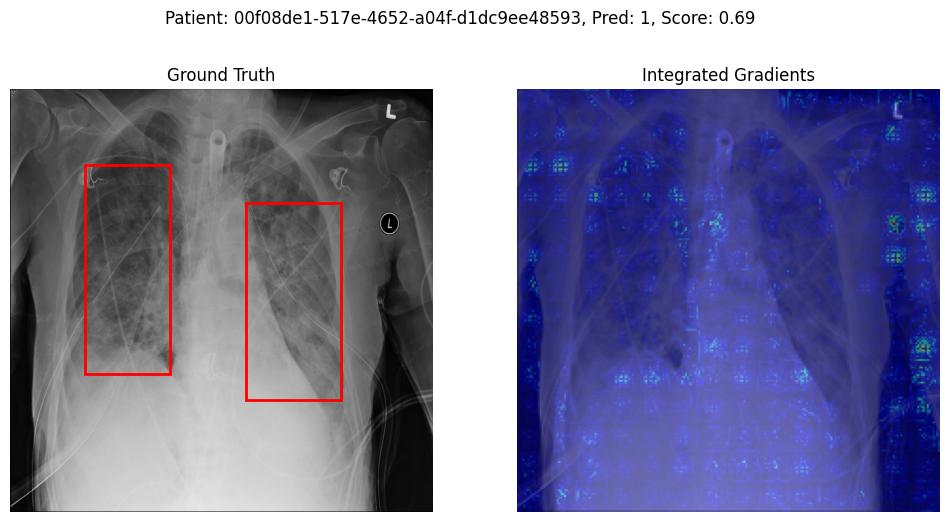

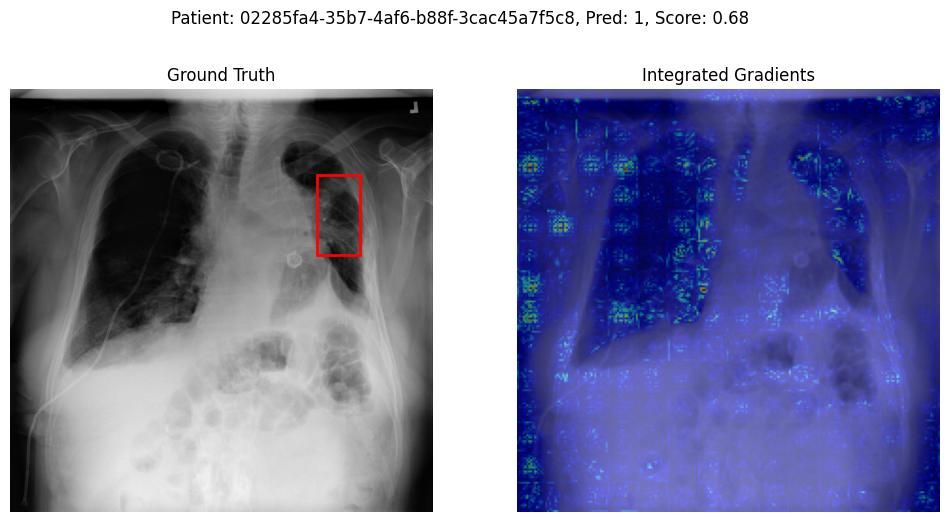

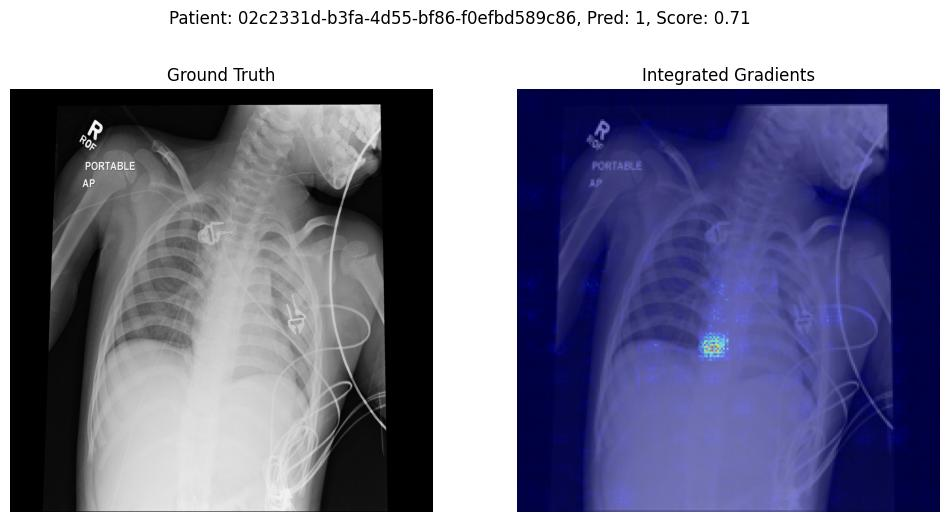

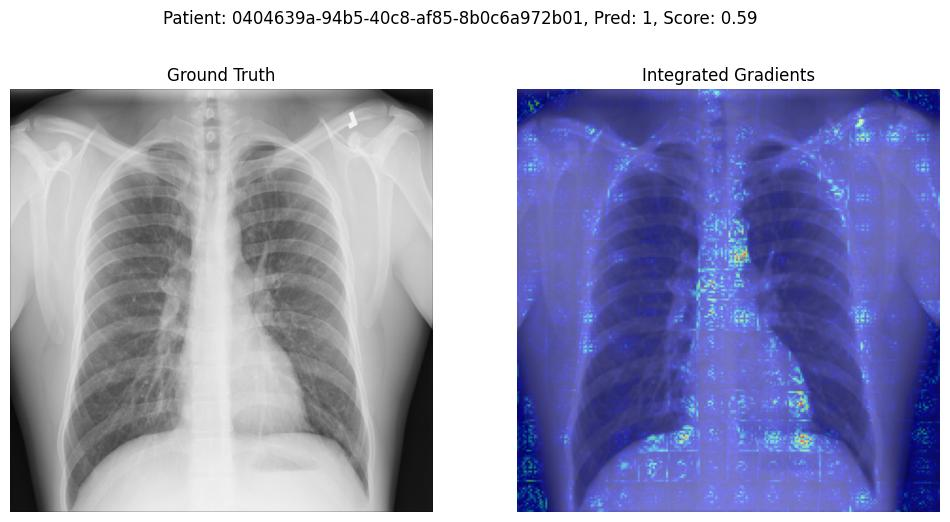

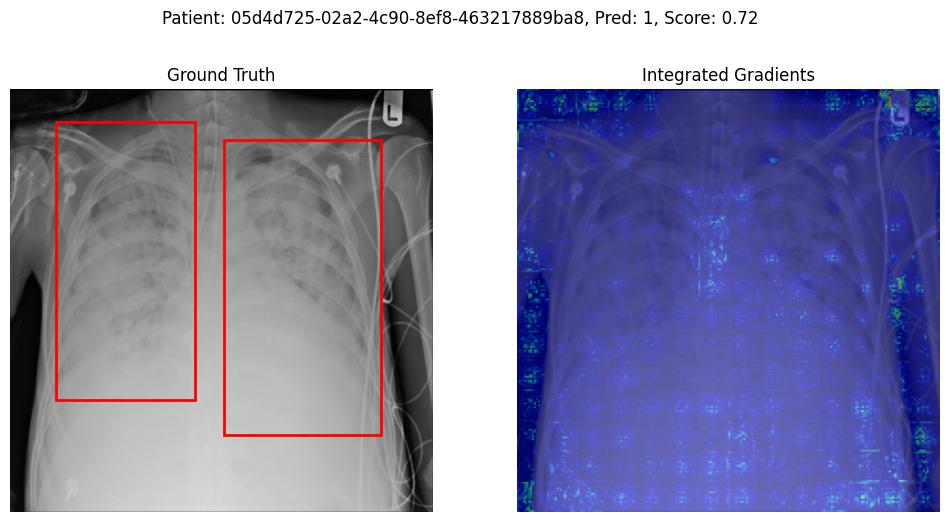

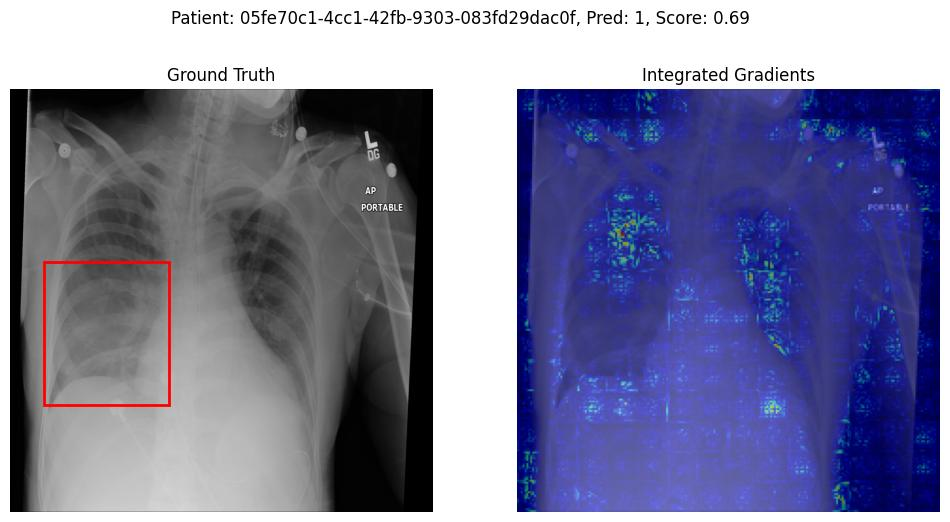

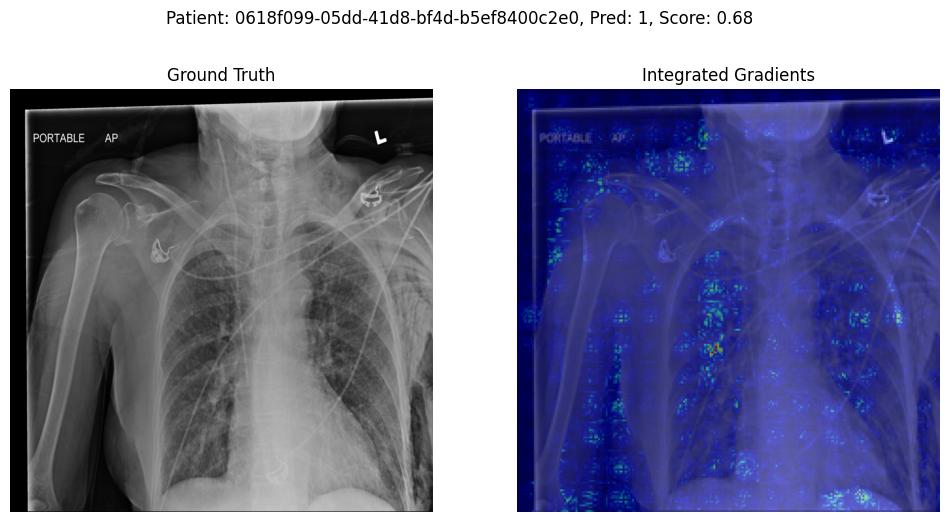

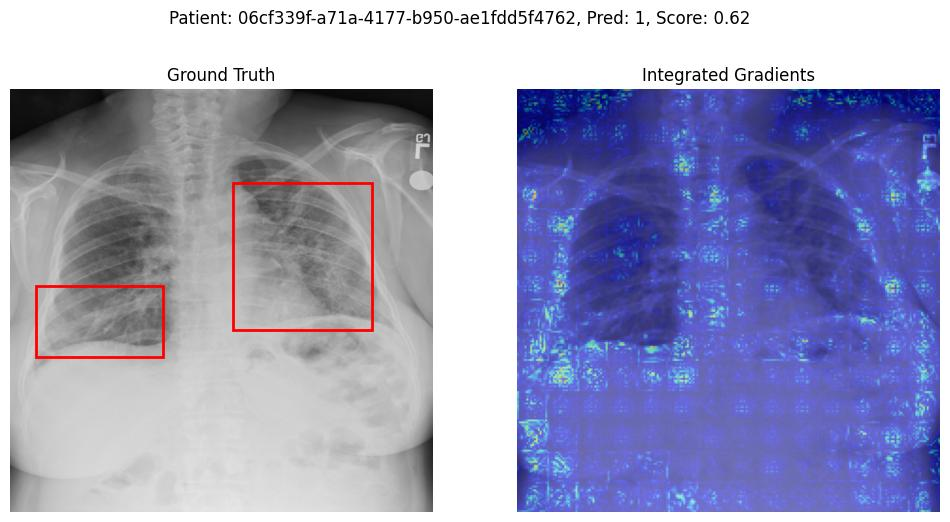

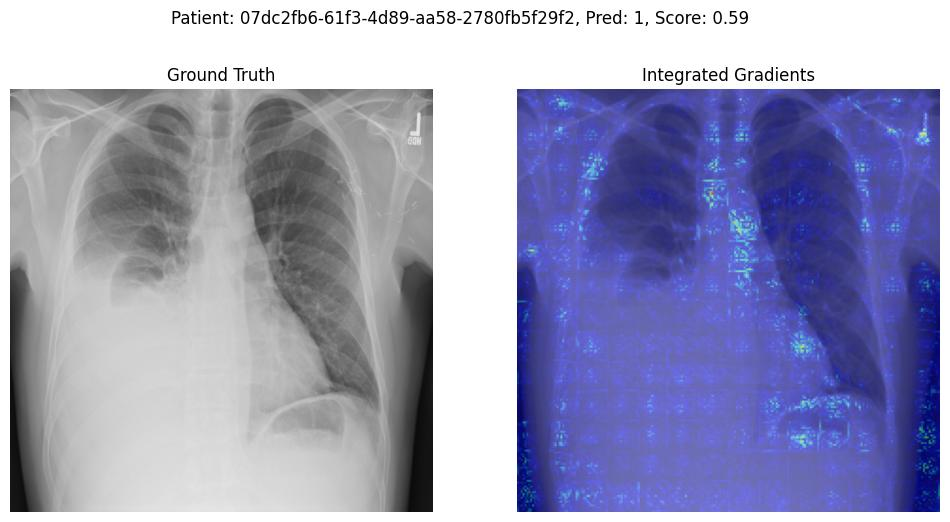

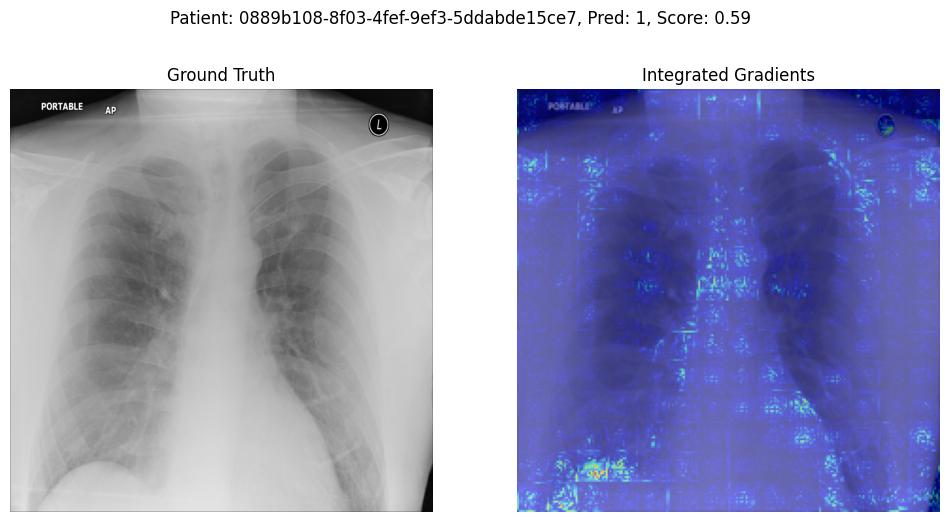

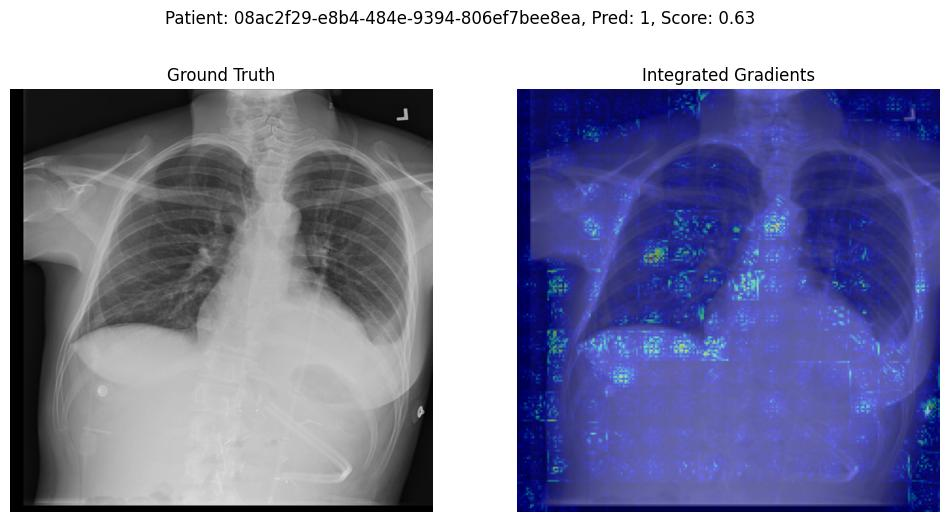

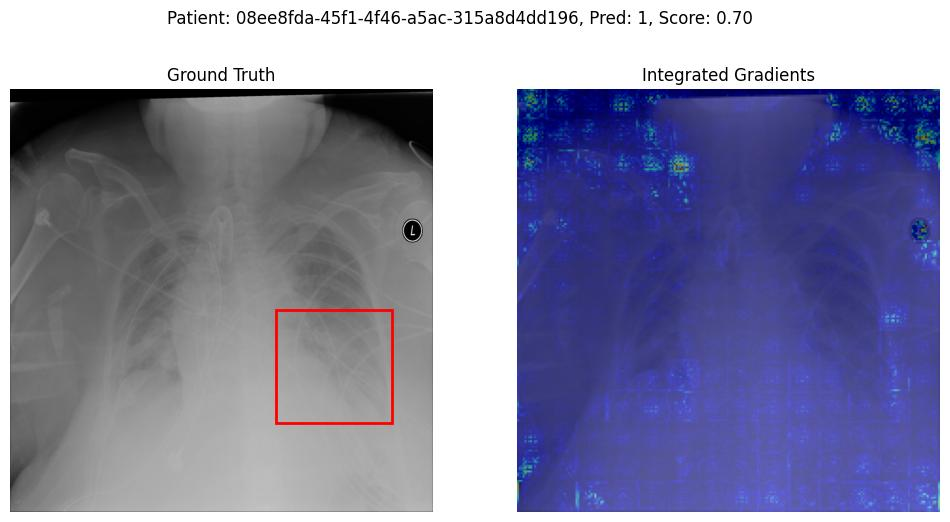

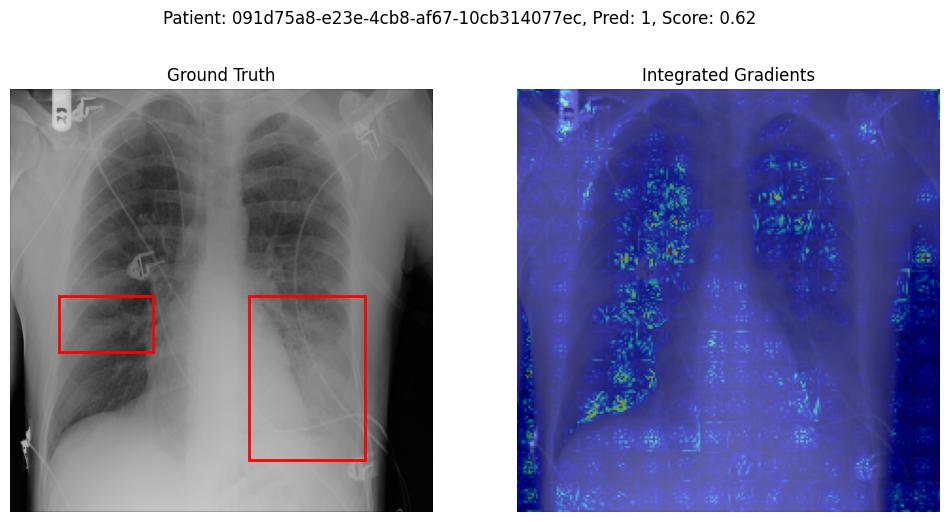

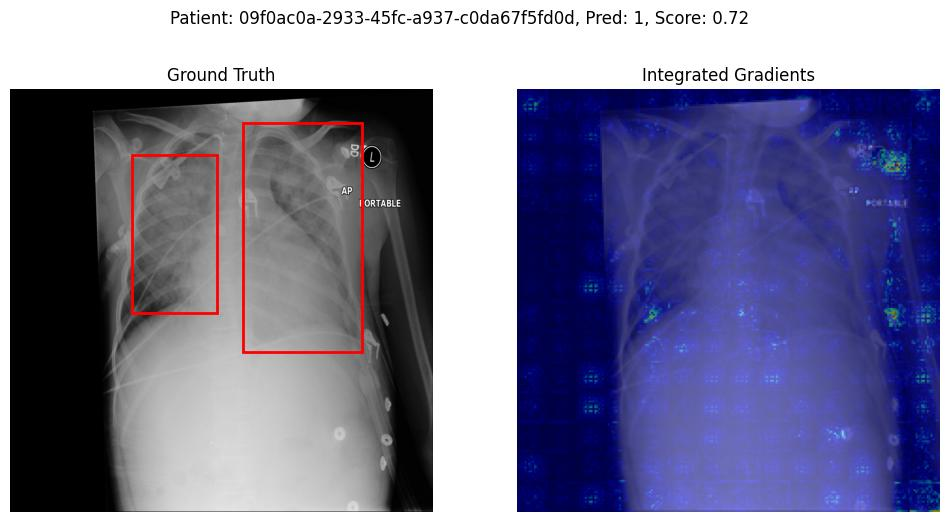

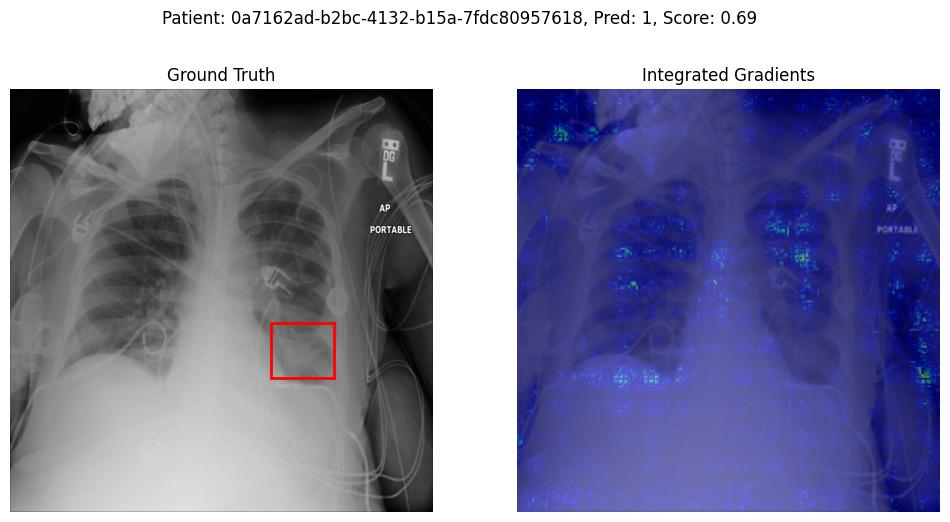

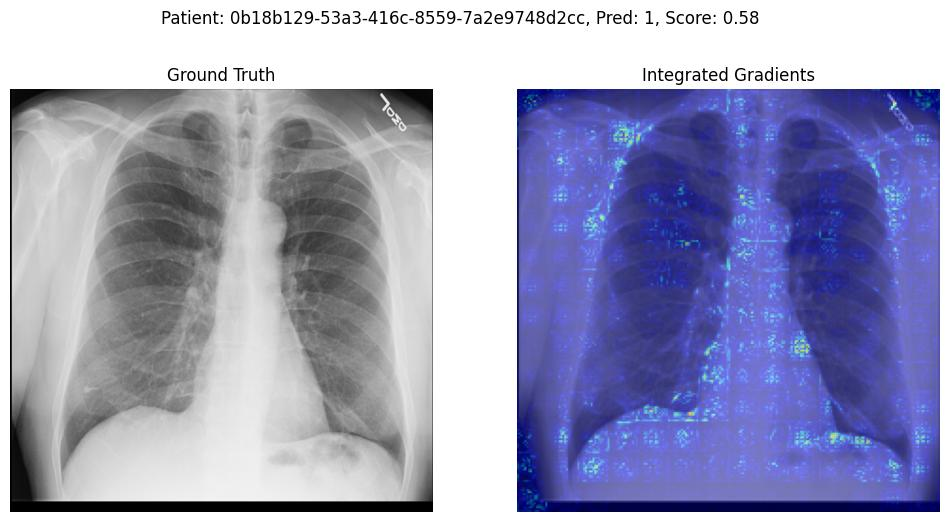

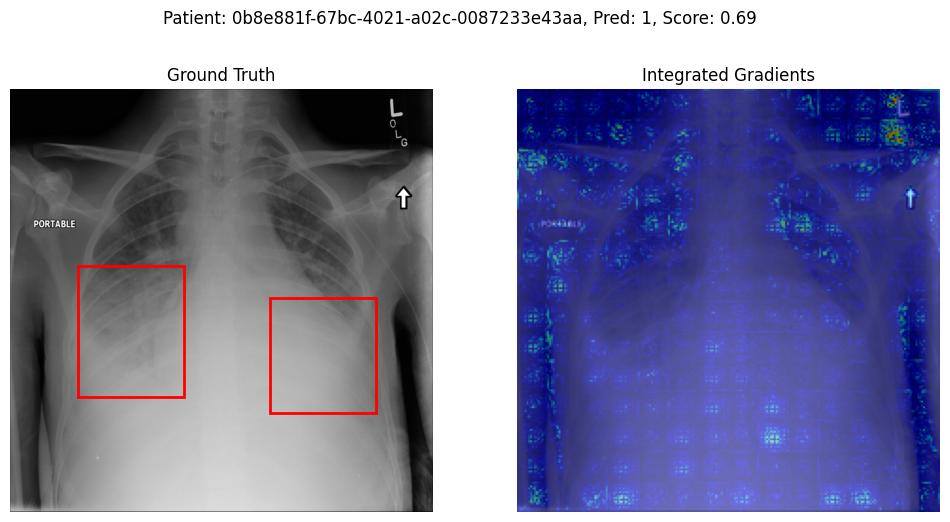

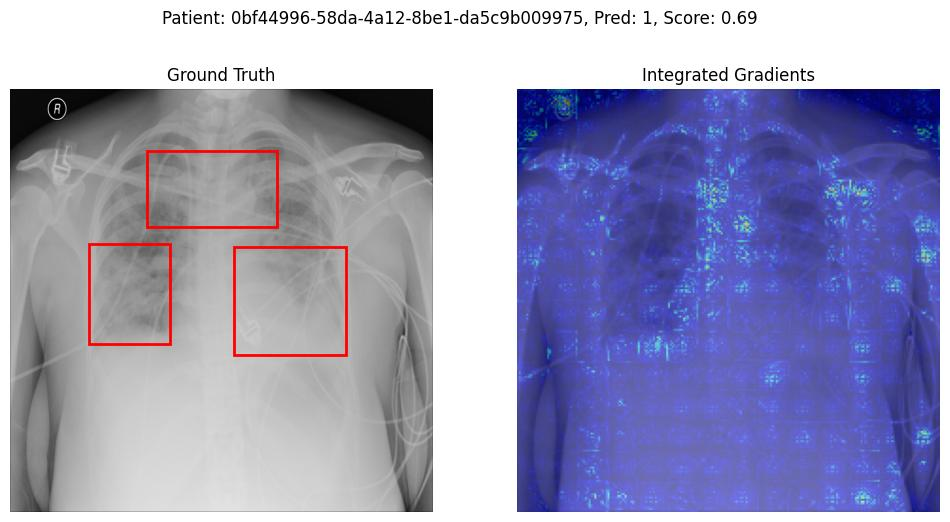

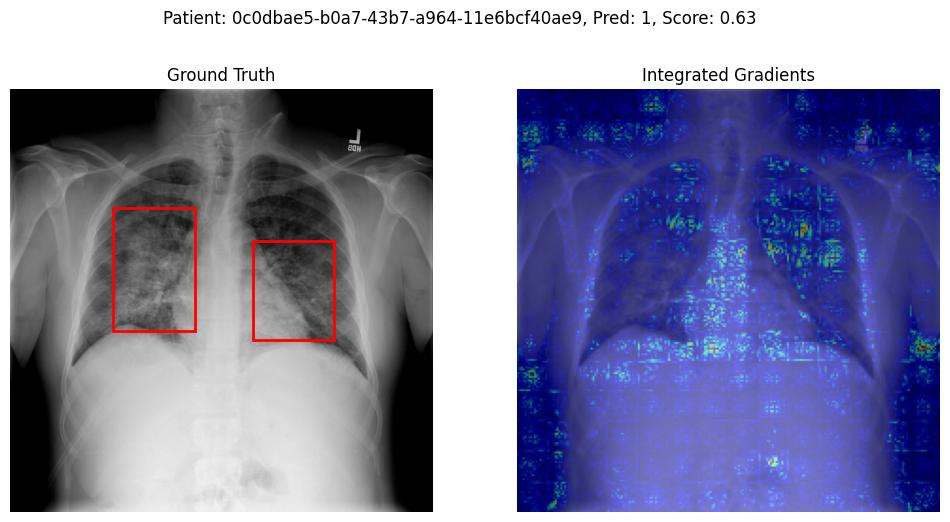

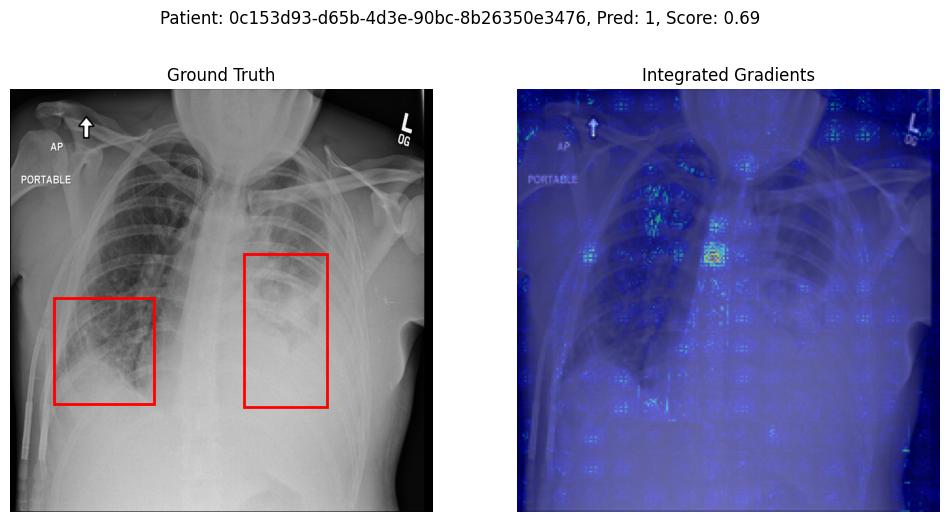

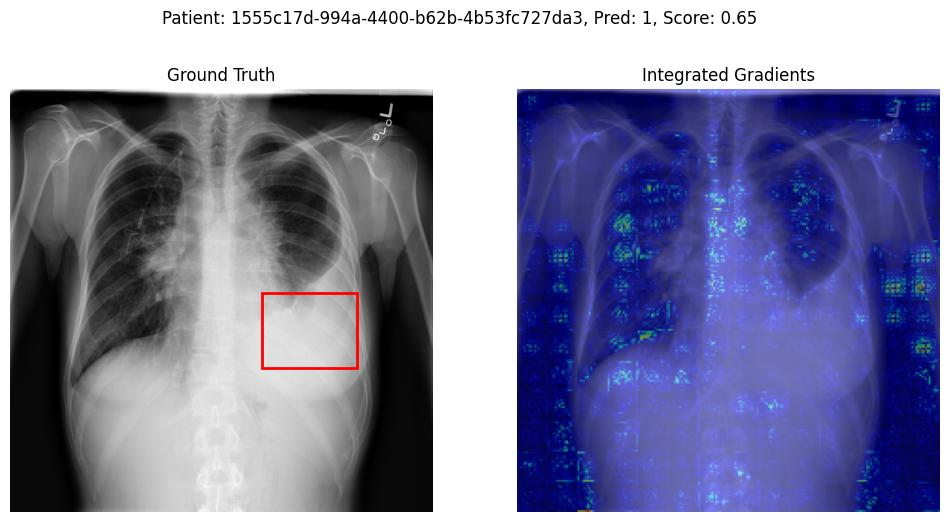

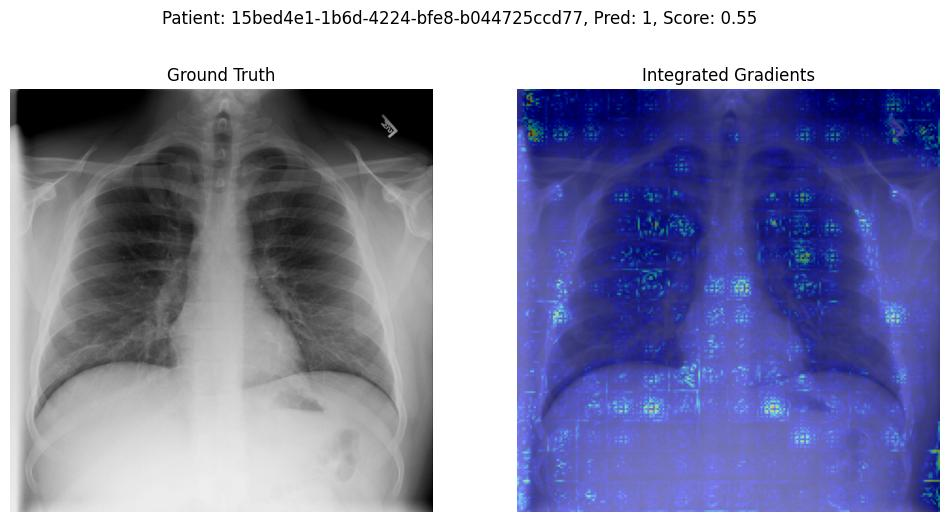

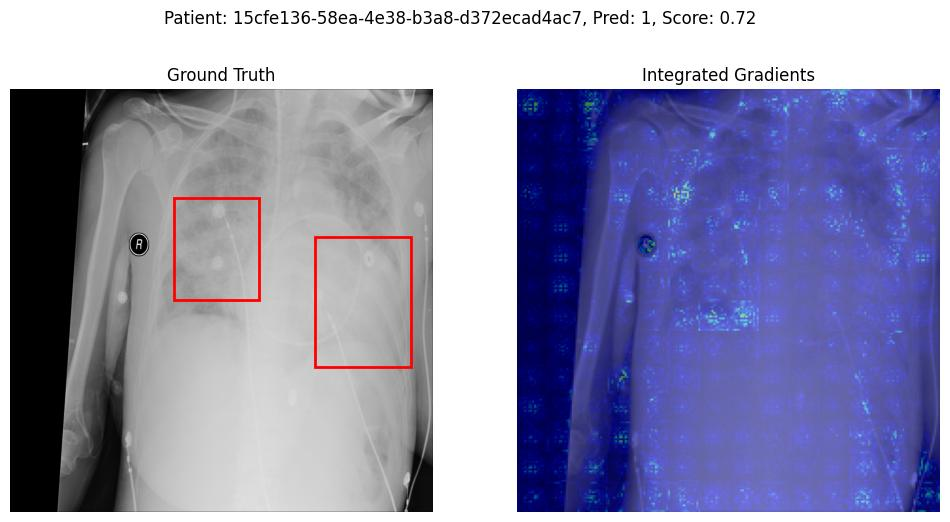

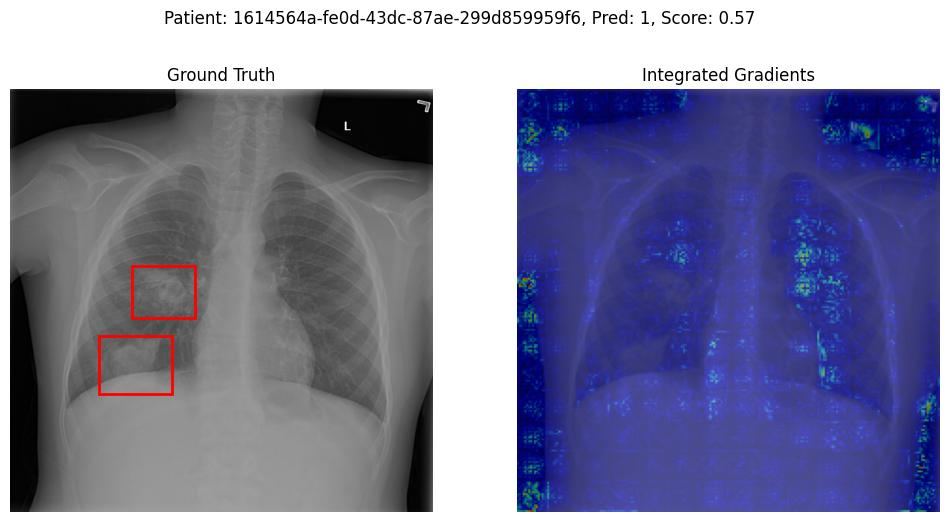

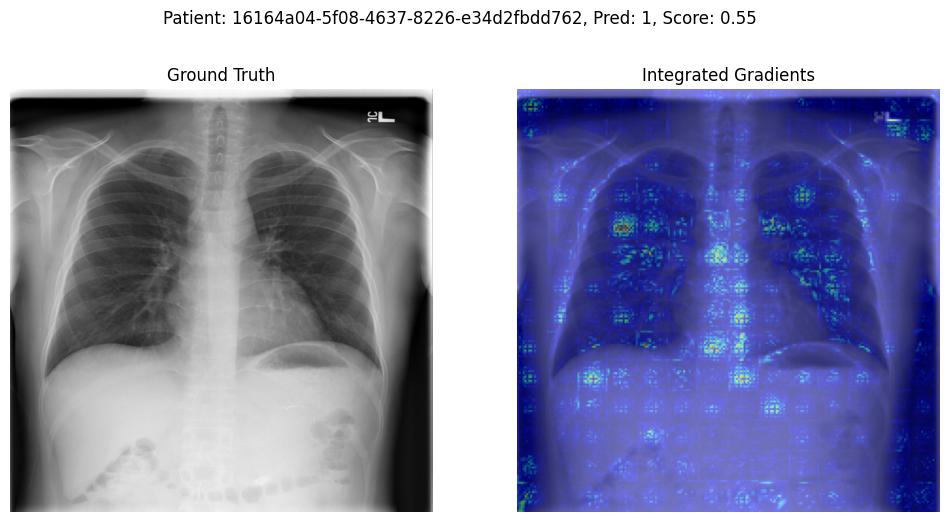

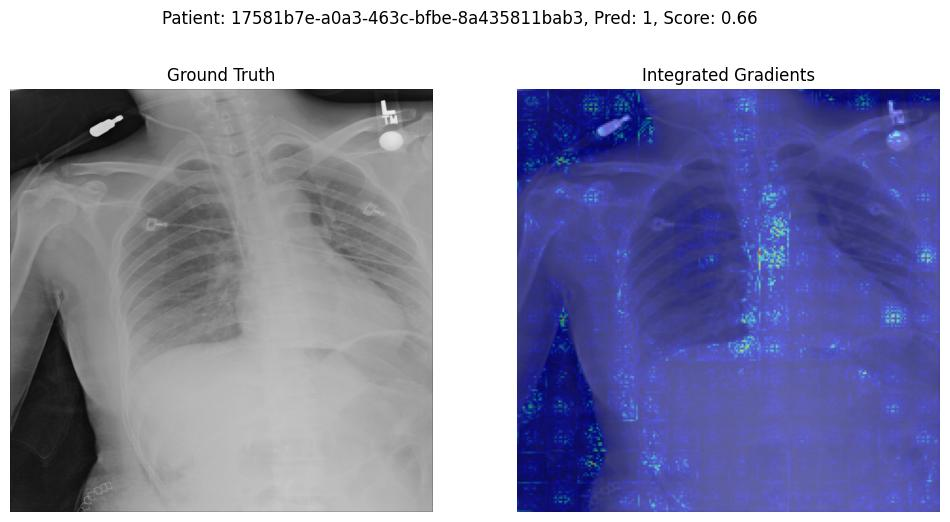

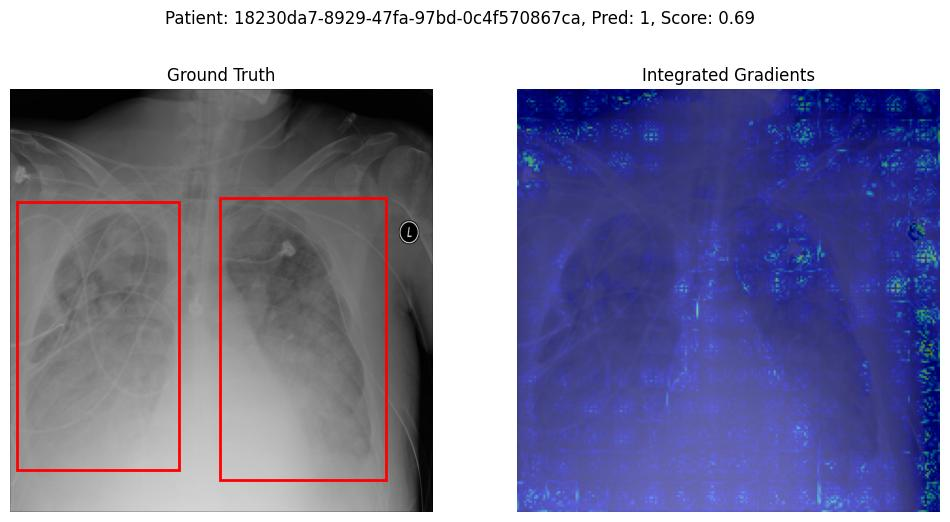

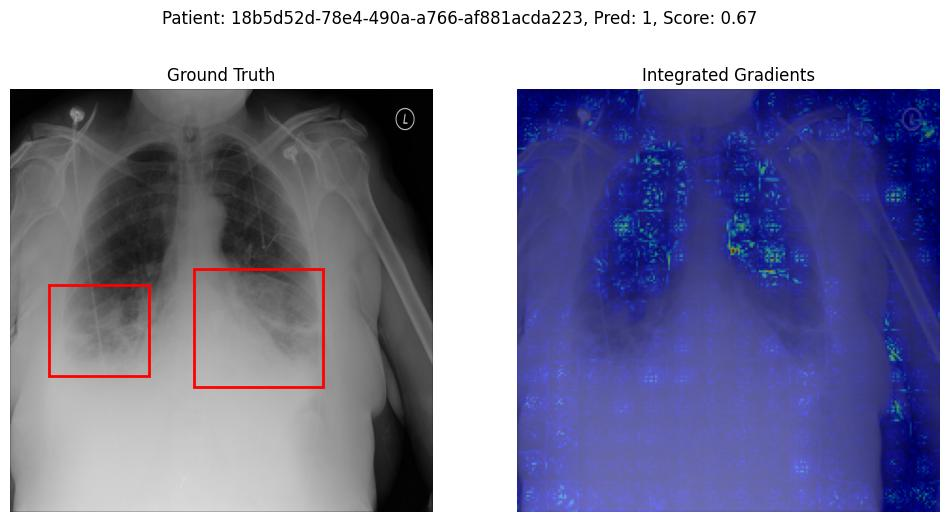

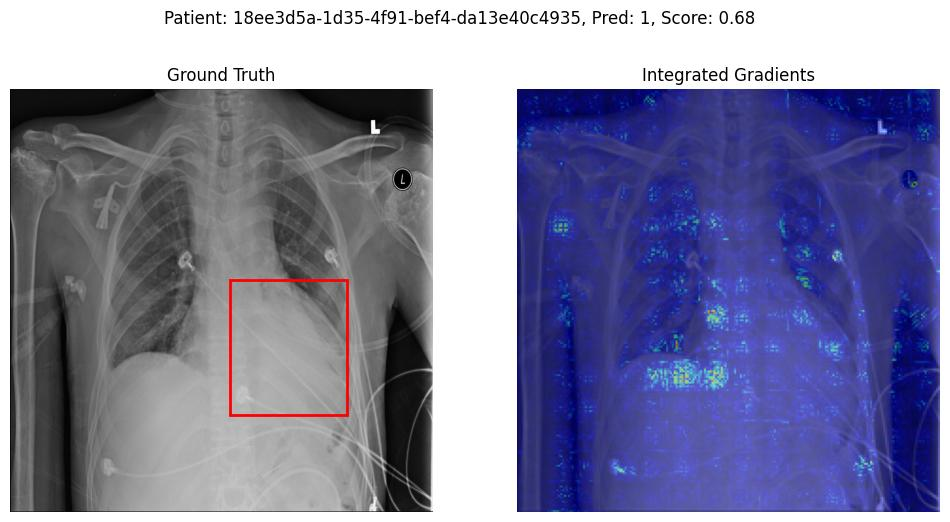

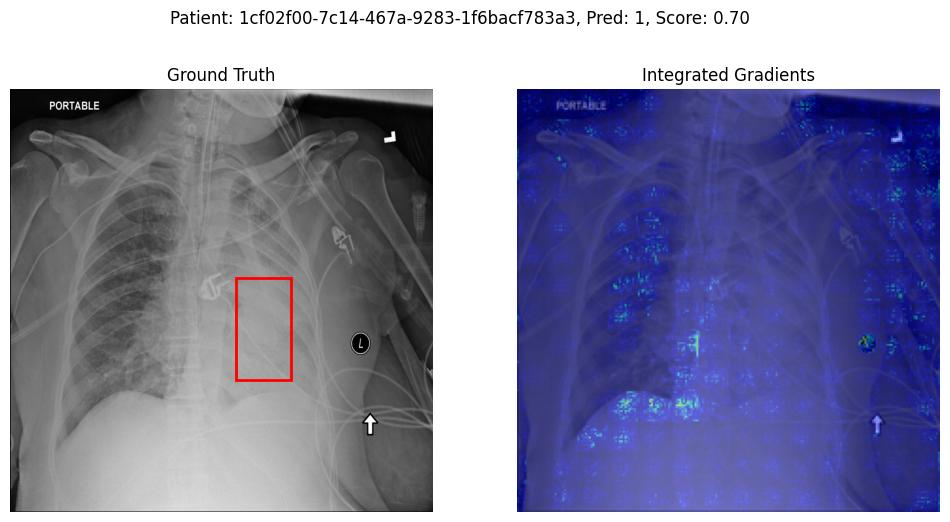

In [ ]:
# =======================
# 1️⃣ Imports & Config
# =======================
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from captum.attr import IntegratedGradients
import timm

# ---------------- Config ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
NUM_SAMPLES = 30    # number of patients to process
STEPS = 50          # IG steps
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'


model.eval()

# =======================
# 3️⃣ Wrap model for Captum
# =======================
class ClassificationOnlyModel(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.model = original_model
    def forward(self, x):
        return self.model(x)

model_cls = ClassificationOnlyModel(model).to(DEVICE)
model_cls.eval()
ig = IntegratedGradients(model_cls)

# =======================
# 4️⃣ Load CSV & prepare samples
# =======================
df = pd.read_csv(CSV_PATH)
sample_files = df['patientId'].unique()[:NUM_SAMPLES]

# =======================
# 5️⃣ Transform
# =======================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# =======================
# 6️⃣ Integrated Gradients Loop
# =======================
for pid in sample_files:
    img_path = f"{IMAGE_DIR}/{pid}.png"
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    # ---------- Prediction ----------
    with torch.no_grad():
        pred_logits = model_cls(img_tensor)
        pred_score = torch.sigmoid(pred_logits[0,0]).item()
        pred_class = int(pred_score > 0.5)

    # ---------- Compute IG ----------
    baseline = torch.zeros_like(img_tensor).to(DEVICE)
    attributions = ig.attribute(img_tensor, baselines=baseline, target=0, n_steps=STEPS)
    attr = attributions.squeeze(0).cpu().detach().numpy()       # [3,H,W]
    attr = np.sum(np.abs(attr), axis=0)                         # sum over channels -> [H,W]
    attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)  # normalize 0-1

    # ---------- Heatmap with matplotlib ----------
    cmap = plt.get_cmap('jet')
    ig_heatmap = cmap(attr)[...,:3]  # drop alpha channel, [H,W,3]

    # ---------- Combine with original image ----------
    orig_img_np = np.array(pil_img.resize((IMG_SIZE, IMG_SIZE)))/255.0
    combined = 0.5*orig_img_np + 0.5*ig_heatmap

    # ---------- Ground Truth Overlay ----------
    gt_rows = df[df['patientId']==pid]

    fig, axes = plt.subplots(1,2, figsize=(12,6))

    # GT
    axes[0].imshow(pil_img)
    for _, row in gt_rows.iterrows():
        if row['Target']==1:
            rect = plt.Rectangle((row['x'], row['y']), row['width'], row['height'],
                                 linewidth=2, edgecolor='red', facecolor='none')
            axes[0].add_patch(rect)
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')

    # IG heatmap
    axes[1].imshow(combined)
    axes[1].set_title('Integrated Gradients')
    axes[1].axis('off')

    plt.suptitle(f"Patient: {pid}, Pred: {pred_class}, Score: {pred_score:.2f}")
    plt.show()


**Observations**:

IG heatmaps for ViTs highlight the lung/thoracic region with greater precision than CNNs. Unlike CNNs, the activations here are often concentrated within subregions of the lungs, reflecting ViTs ability to focus on fine-grained pathaology. This patch-level attention allows the model to provide more localized and interpretable attribution maps.

## Insertion & Deletion Curves

**Concept**:

Insertion measures how the model's confidence rises as the important pixels are added back. Deletion measures how the model's confidence falls as those pixels are removed.

**Purpose**:

Used to evaluate the **faithfulness** of the explanations i.e. whether the highlighted regions truly influence the model's predictions or not.

## Entropy & Sparsity
**Concept**:

Entropy measures how spread-out the attention is on a saliency map, while Sparsity quantifies how concentrated it is (i.e. how much of the total area actually carries **meaningful activation**)

For highly focused attributions, the Entropy should be lower while the Sparsity should be higher.


**Purpose**:

Used to quantify how focused or diffused the model's visual explanations are across all the classes.



100%|██████████| 30/30 [35:36<00:00, 71.23s/it]


IG Entropy: 10.4069 ± 0.0453
IG Sparsity: 0.6108 ± 0.0973


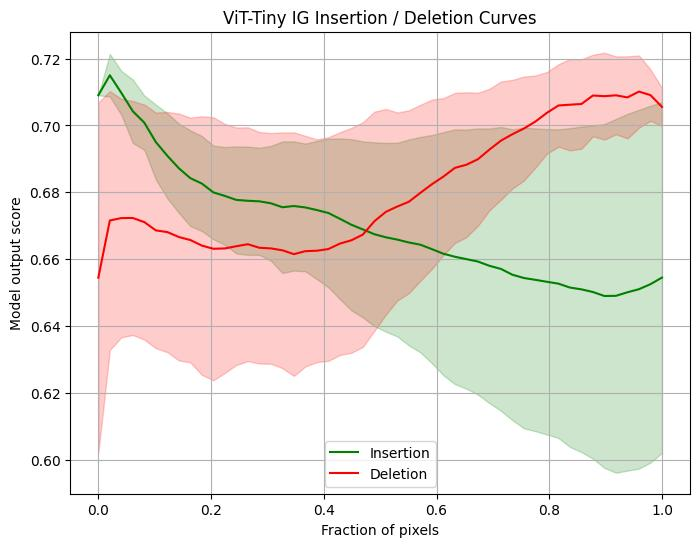

In [ ]:
# =======================
# 1️⃣ Imports
# =======================
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import timm
from captum.attr import IntegratedGradients
from torchvision import transforms

# =======================
# 2️⃣ Config
# =======================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
NUM_SAMPLES = 30
STEPS = 50
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'

# =======================
# 5️⃣ Helper Functions
# =======================
def compute_entropy(heatmap):
    h = heatmap.flatten()
    h = h / (h.sum() + 1e-8)
    return -(h * np.log(h + 1e-8)).sum()

def compute_sparsity(heatmap):
    return 1.0 - (heatmap > 0.05).sum() / heatmap.size

def apply_insertion_deletion(img_tensor, heatmap, model, steps=STEPS, mode="insertion"):
    _, C, H, W = img_tensor.shape
    flat_idx = np.argsort(heatmap.ravel())
    if mode=="insertion":
        masked_img = torch.zeros_like(img_tensor)
        indices_order = flat_idx[::-1]
    else:
        masked_img = img_tensor.clone()
        indices_order = flat_idx[::-1]
    total_pixels = H*W
    step_size = max(total_pixels//steps,1)
    scores = []
    with torch.no_grad():
        for i in range(0, total_pixels, step_size):
            idx = indices_order[:i]
            ys = idx // W
            xs = idx % W
            for y,x in zip(ys,xs):
                if mode=="insertion":
                    masked_img[0,:,y,x] = img_tensor[0,:,y,x]
                else:
                    masked_img[0,:,y,x] = 0
            out = model(masked_img)
            score = torch.sigmoid(out[0,0]).item()
            scores.append(score)
    scores = np.interp(np.linspace(0,1,steps), np.linspace(0,1,len(scores)), scores)
    return scores

# =======================
# 6️⃣ Loop over samples
# =======================
entropy_list = []
sparsity_list = []
insertion_curves = []
deletion_curves = []

for pid in tqdm(sample_files):
    img_path = f"{IMAGE_DIR}/{pid}.png"
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    # ---------- Integrated Gradients ----------
    baseline = torch.zeros_like(img_tensor).to(DEVICE)
    attributions = ig.attribute(img_tensor, baselines=baseline, target=0, n_steps=STEPS)
    attr = attributions.squeeze(0).cpu().detach().numpy()
    attr = np.sum(np.abs(attr), axis=0)
    attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

    # ---------- Entropy & Sparsity ----------
    entropy_list.append(compute_entropy(attr))
    sparsity_list.append(compute_sparsity(attr))

    # ---------- Insertion / Deletion Curves ----------
    insertion_curves.append(apply_insertion_deletion(img_tensor, attr, model_cls, mode="insertion"))
    deletion_curves.append(apply_insertion_deletion(img_tensor, attr, model_cls, mode="deletion"))

# =======================
# 7️⃣ Convert to np arrays & stats
# =======================
insertion_curves_np = np.array(insertion_curves)
deletion_curves_np = np.array(deletion_curves)
entropy_mean = np.mean(entropy_list)
entropy_std  = np.std(entropy_list)
sparsity_mean = np.mean(sparsity_list)
sparsity_std  = np.std(sparsity_list)

print(f"IG Entropy: {entropy_mean:.4f} ± {entropy_std:.4f}")
print(f"IG Sparsity: {sparsity_mean:.4f} ± {sparsity_std:.4f}")

# =======================
# 8️⃣ Plot Insertion / Deletion Curves
# =======================
x = np.linspace(0,1,STEPS)
plt.figure(figsize=(8,6))
plt.plot(x, insertion_curves_np.mean(axis=0), label="Insertion", color="green")
plt.fill_between(x, insertion_curves_np.mean(axis=0)-insertion_curves_np.std(axis=0),
                 insertion_curves_np.mean(axis=0)+insertion_curves_np.std(axis=0),
                 color="green", alpha=0.2)
plt.plot(x, deletion_curves_np.mean(axis=0), label="Deletion", color="red")
plt.fill_between(x, deletion_curves_np.mean(axis=0)-deletion_curves_np.std(axis=0),
                 deletion_curves_np.mean(axis=0)+deletion_curves_np.std(axis=0),
                 color="red", alpha=0.2)
plt.xlabel("Fraction of pixels")
plt.ylabel("Model output score")
plt.title("ViT-Tiny IG Insertion / Deletion Curves")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import auc
import numpy as np

# x-axis: fraction of pixels added/removed
x = np.linspace(0, 1, STEPS)

# Mean curves
ins_mean = insertion_curves_np.mean(axis=0)
del_mean = deletion_curves_np.mean(axis=0)

# Compute AUC
auc_insertion = auc(x, ins_mean)
auc_deletion = auc(x, del_mean)

print(f"AUC Insertion: {auc_insertion:.4f}")
print(f"AUC Deletion: {auc_deletion:.4f}")


AUC Insertion: 0.6700
AUC Deletion: 0.6809


**Observations**:

The moderately high Sparsity indicates that the model's attention is concentrated on a subset of pixels, while the lower Entropy confirms that the attributions are less diffuse and more focused. Together, these metrics suggest that ViT-Tiny identifies specific, diagnostically relevant subregions within the lungs. However, the flipped insertion and deletion curves and AUCs imply that, although the model highlights these pixels, they do not strongly increase confidence. In other words, the model does not rely heavily on these regions for its predictions.

## Grad-CAM: Visualizing model attention

**Concept**:

Grad-CAM highlights the image regions that are most responsible for the model's decision by tracing class-specific gradients throught the final feature maps.

**Purpose**:

In our notebook, we use it to interpret spatial focus in the first LayerNorm layer of the final Transformer encoder block (`model.blocks[-1].norm1`). This is the deepest feature extraction layer before the final normalization and classification head in ViT-Tiny.


**Quick references**
- Selvaraju et al., *Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization* (2017).  
- `pytorch-grad-cam` (Jacob Gildenblat) — used for production-ready Grad-CAM utilities.



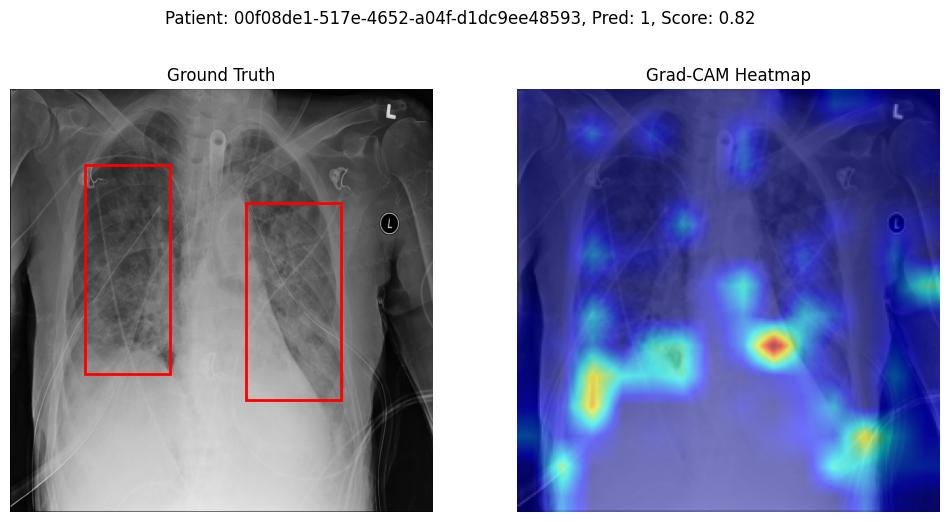

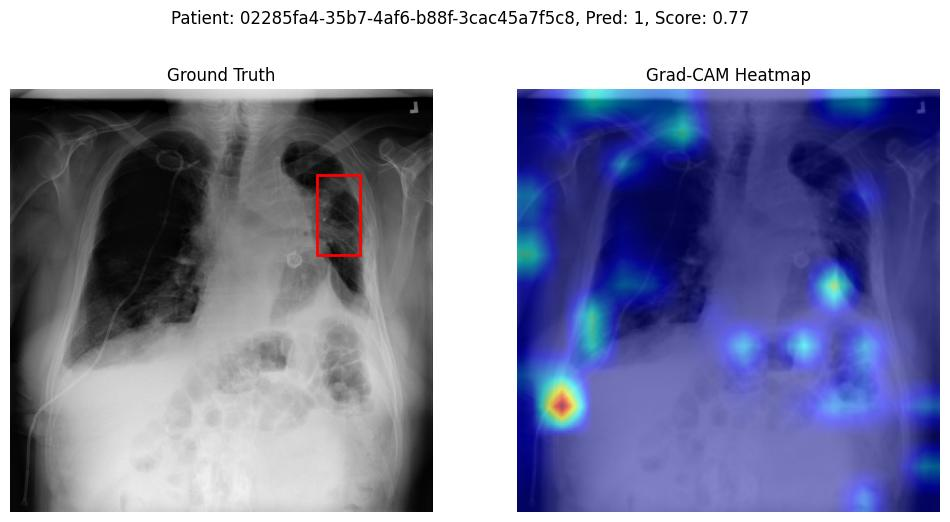

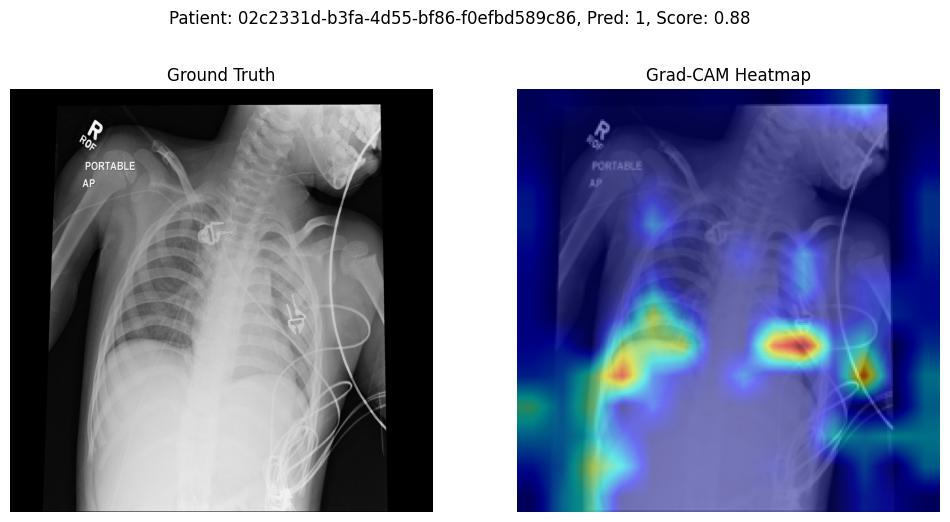

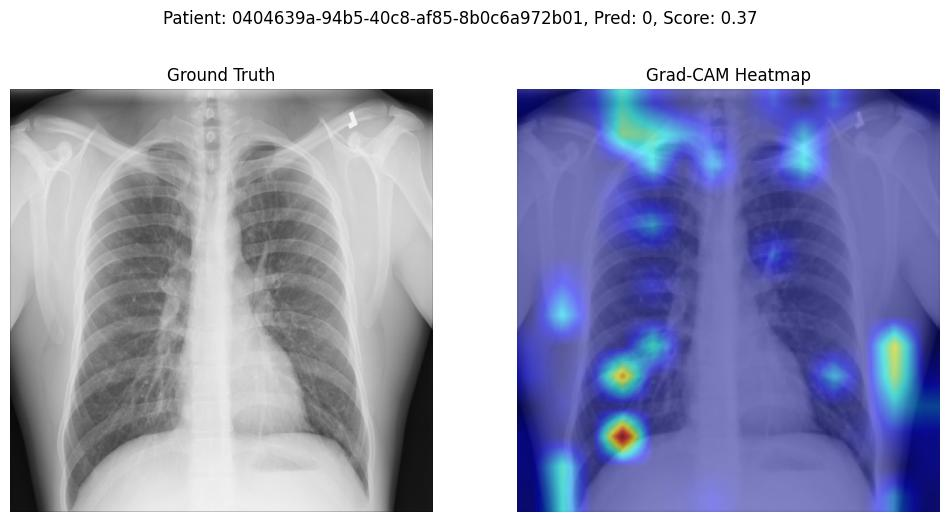

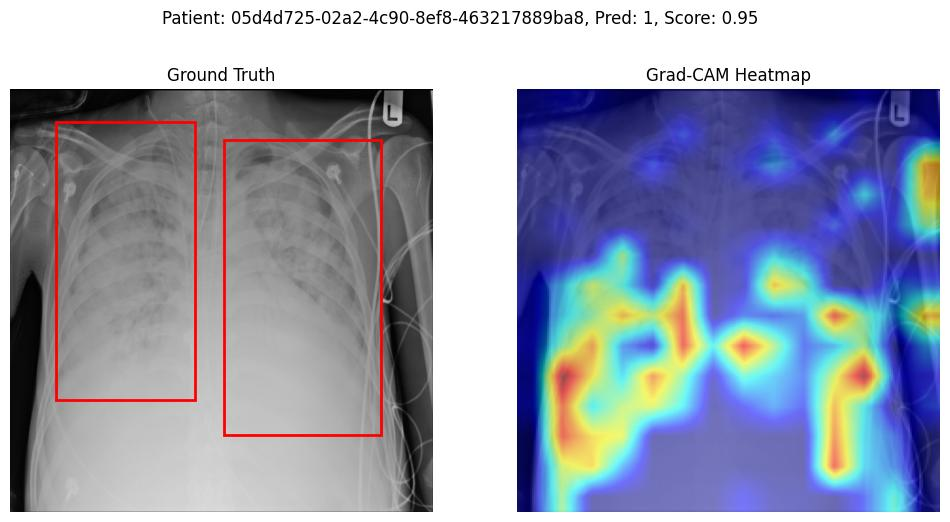

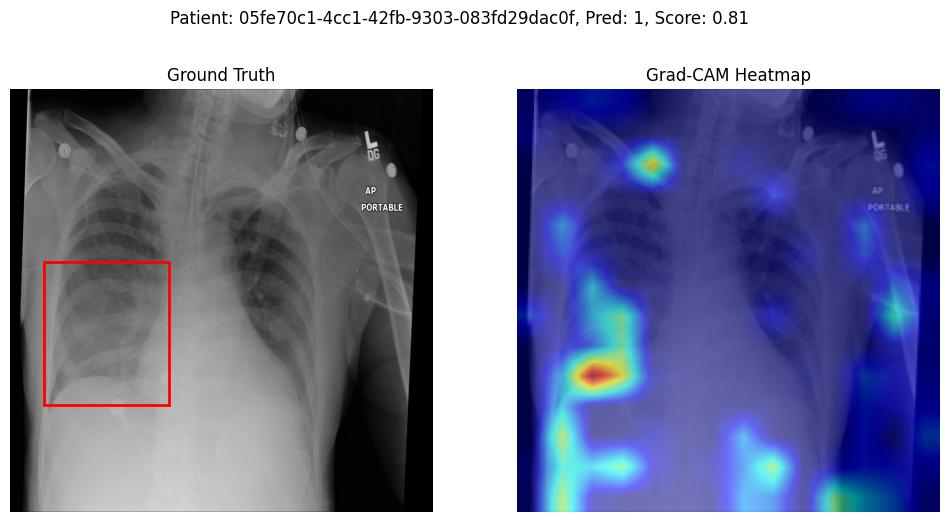

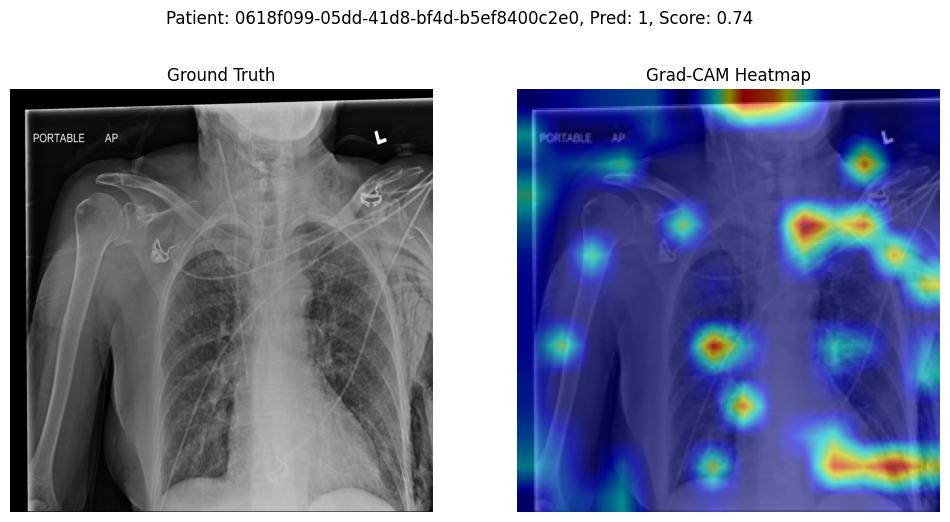

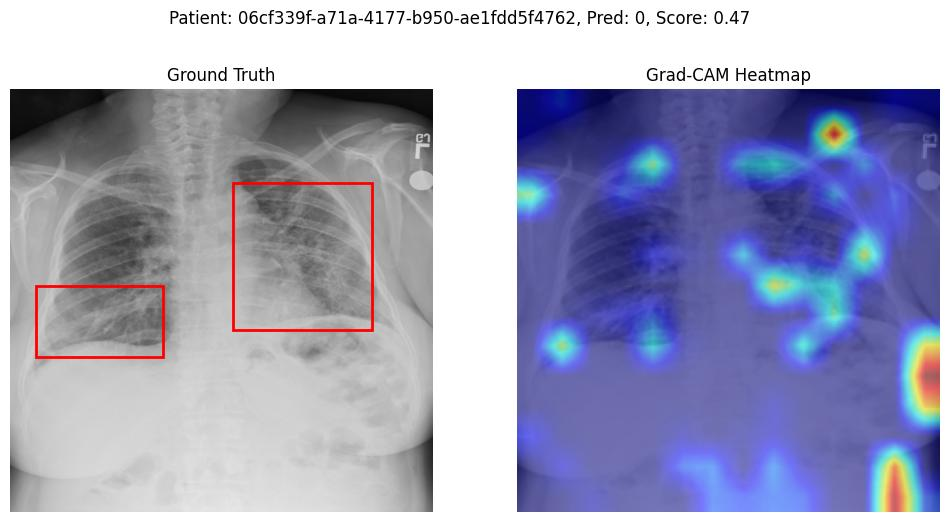

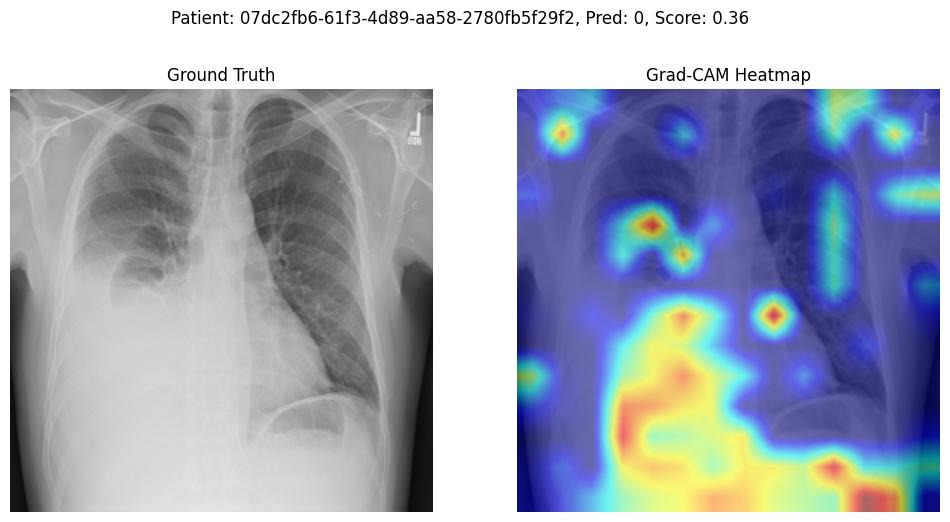

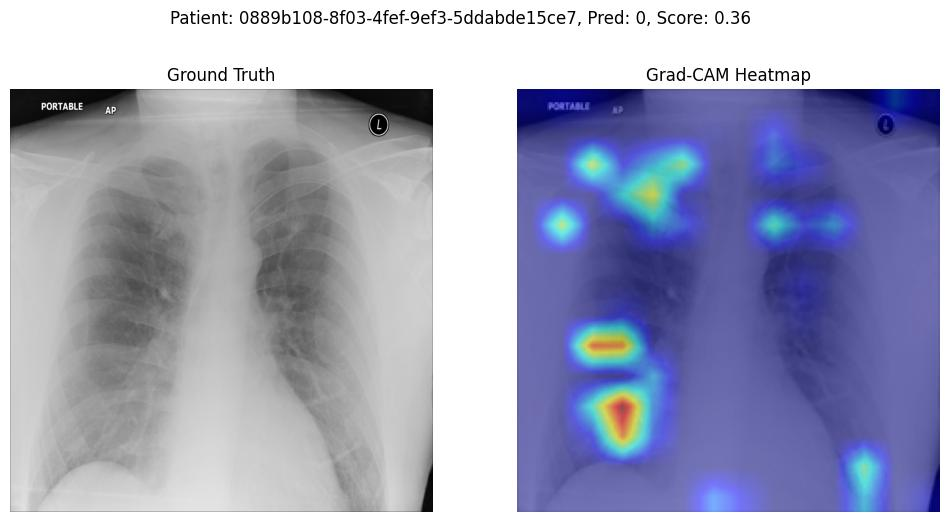

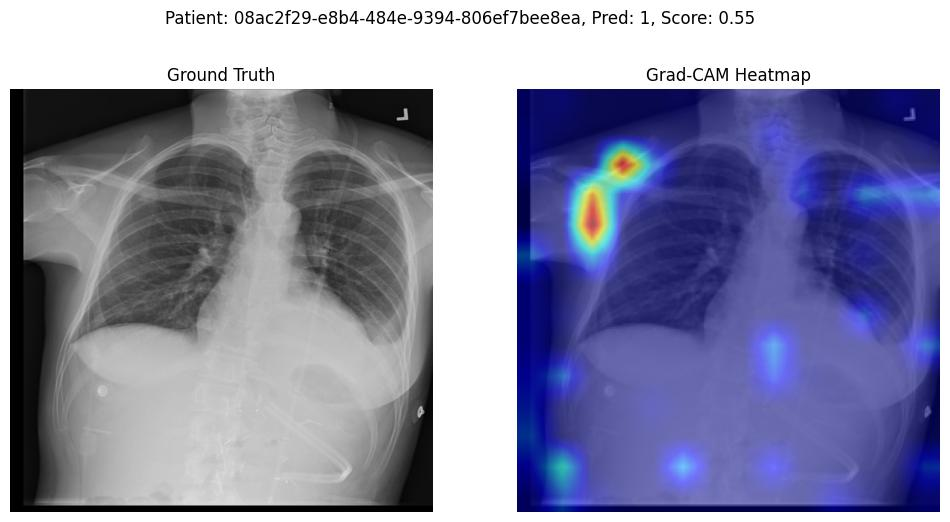

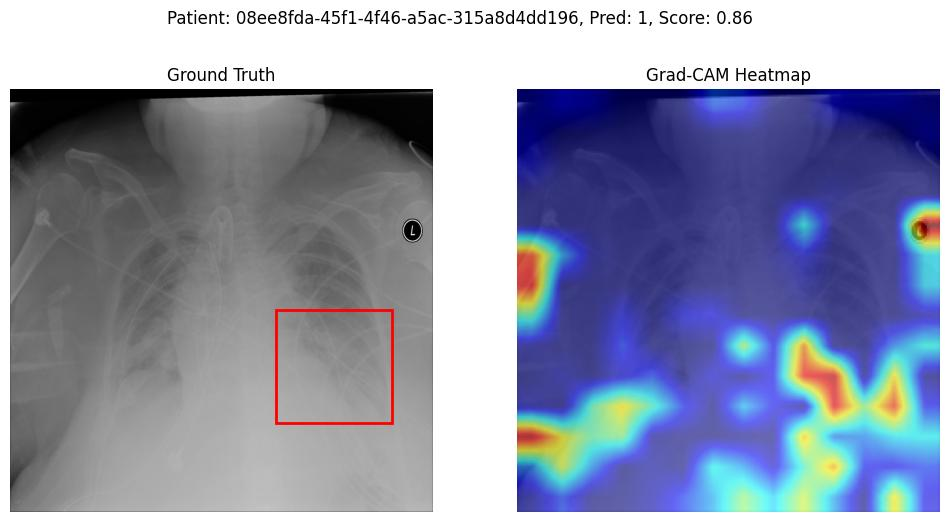

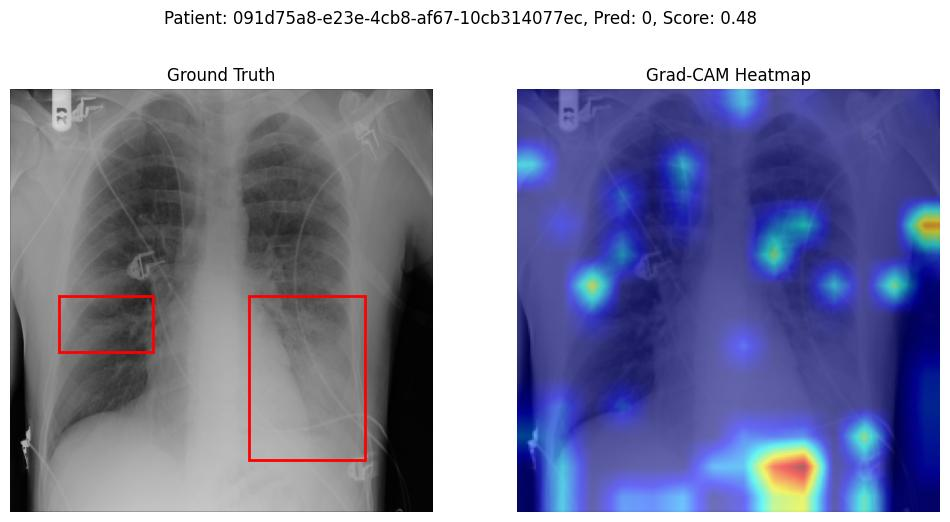

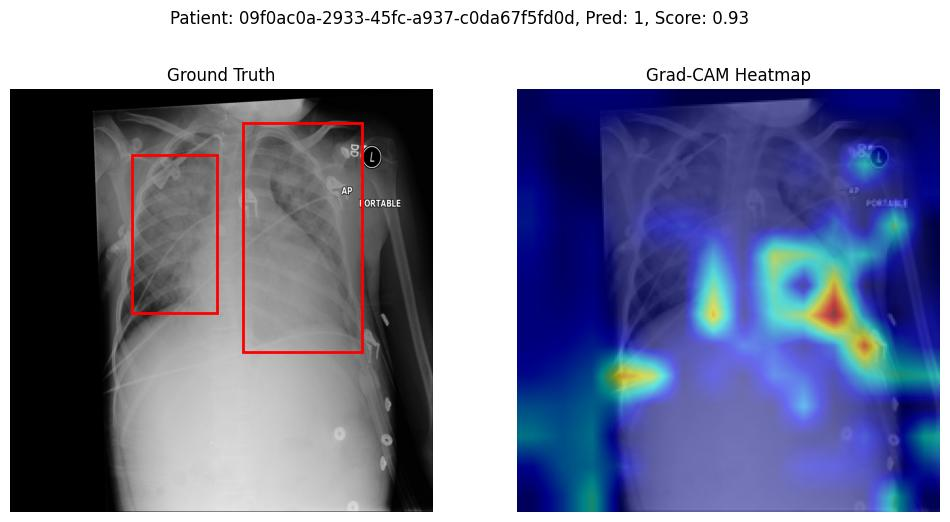

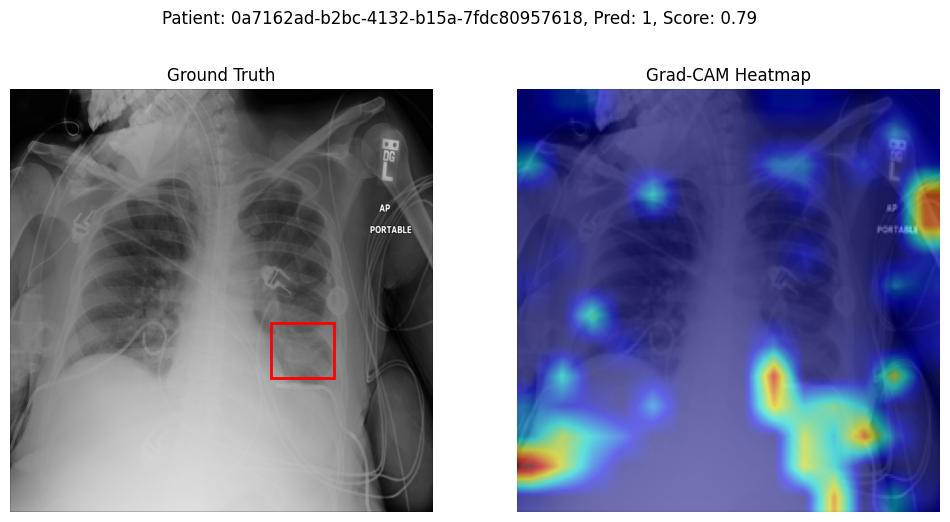

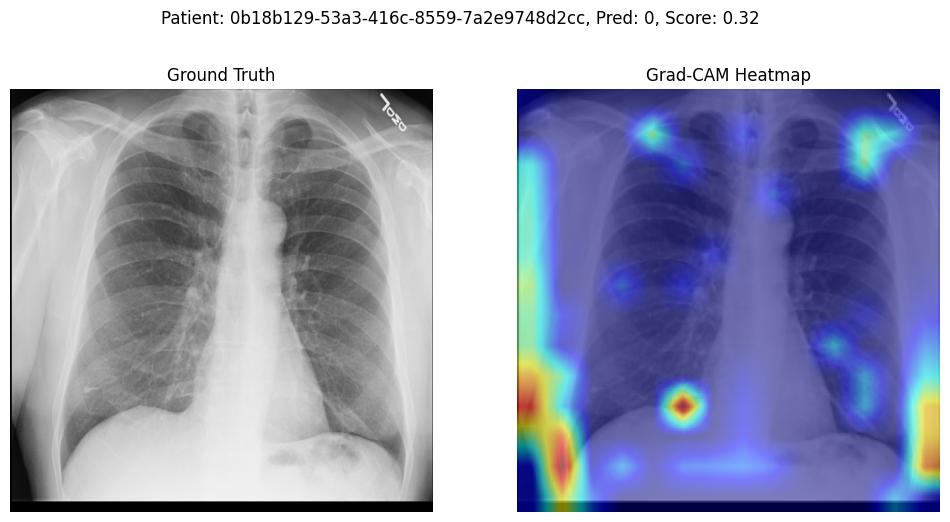

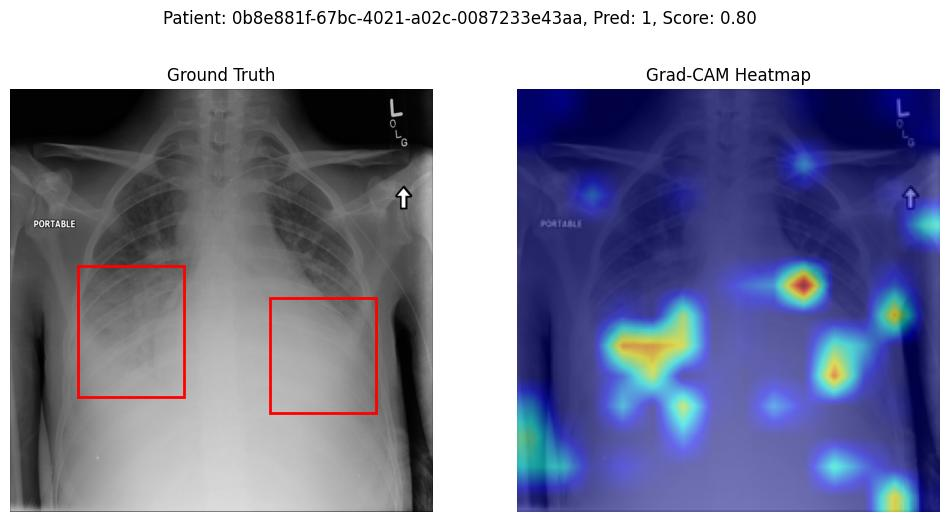

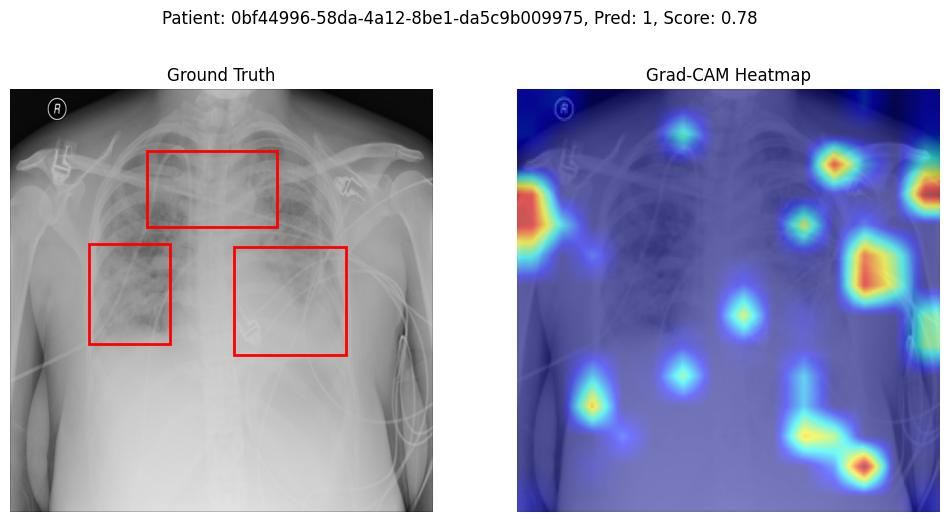

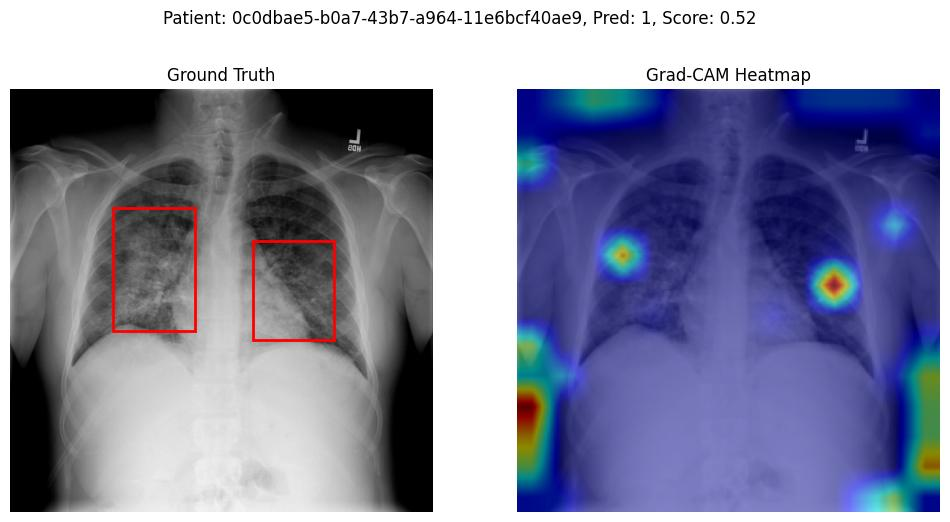

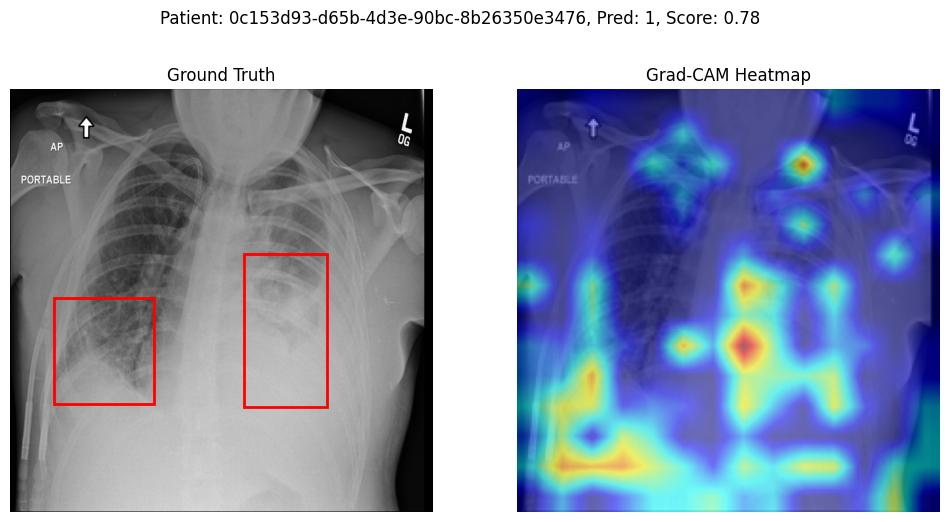

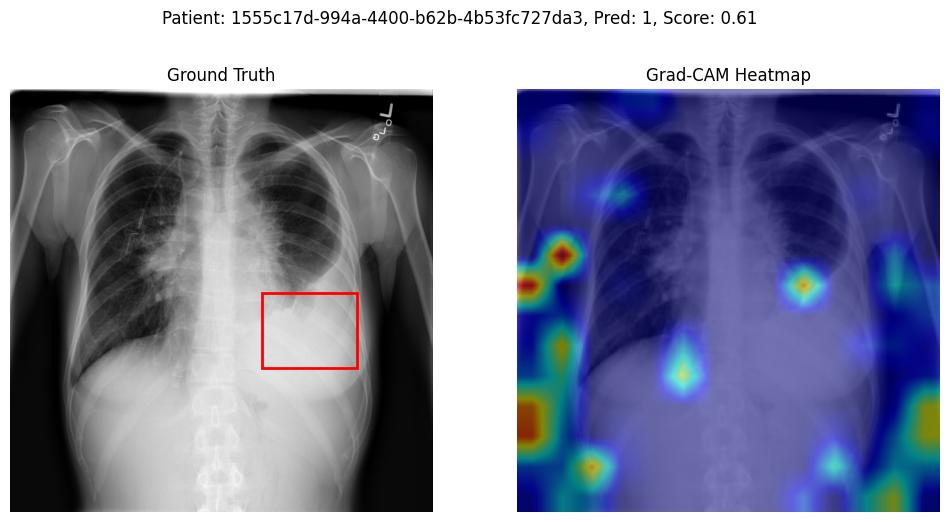

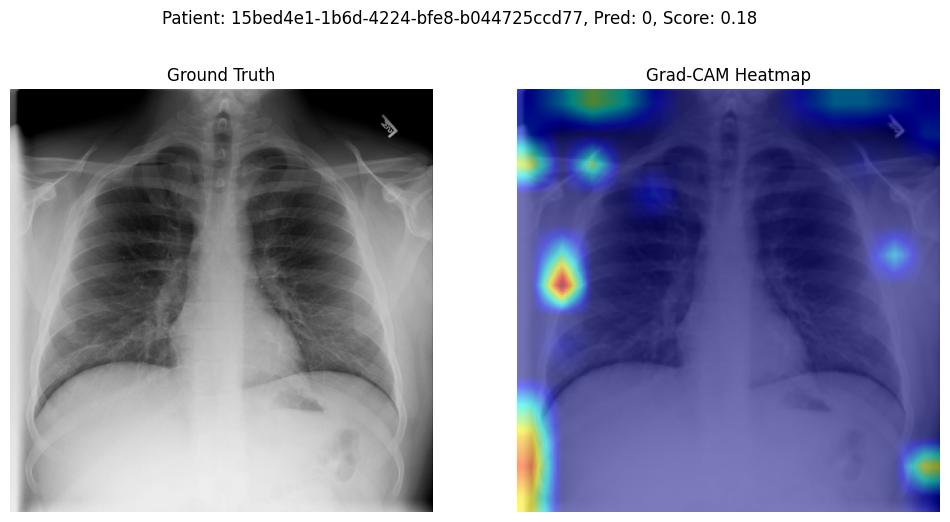

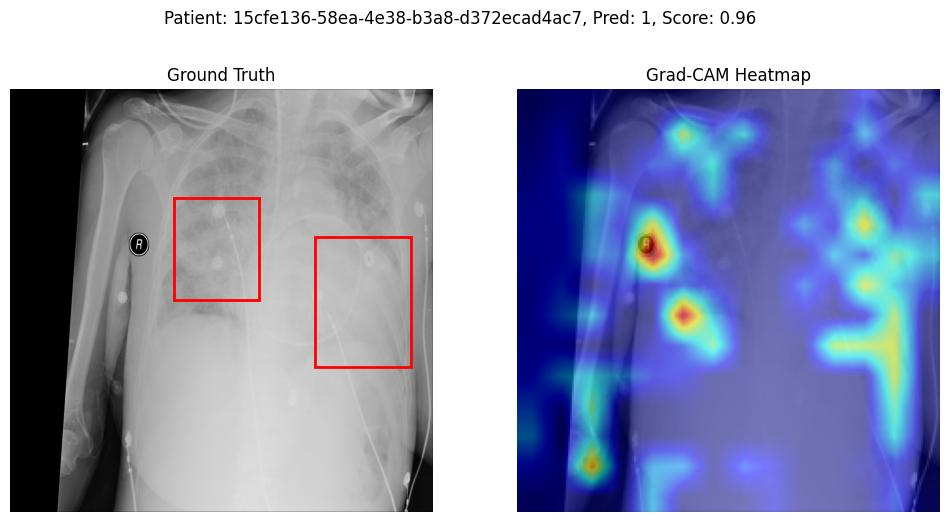

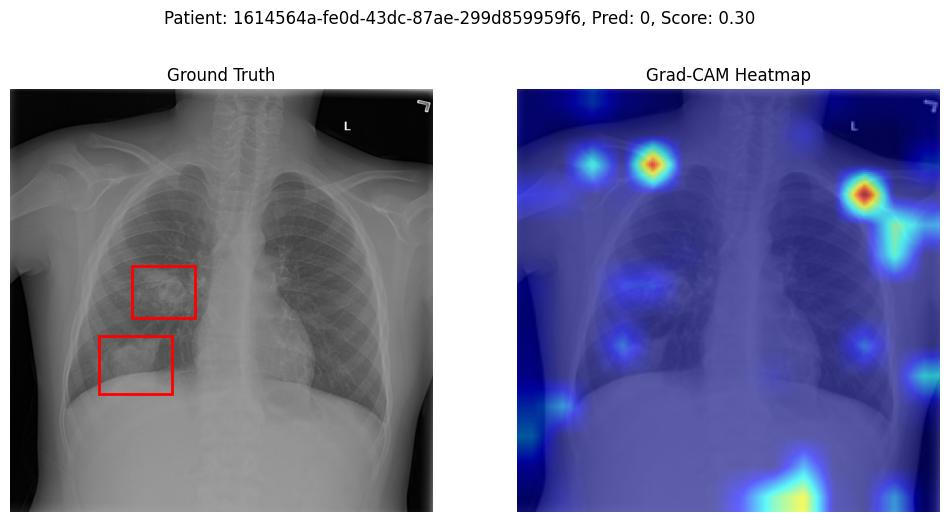

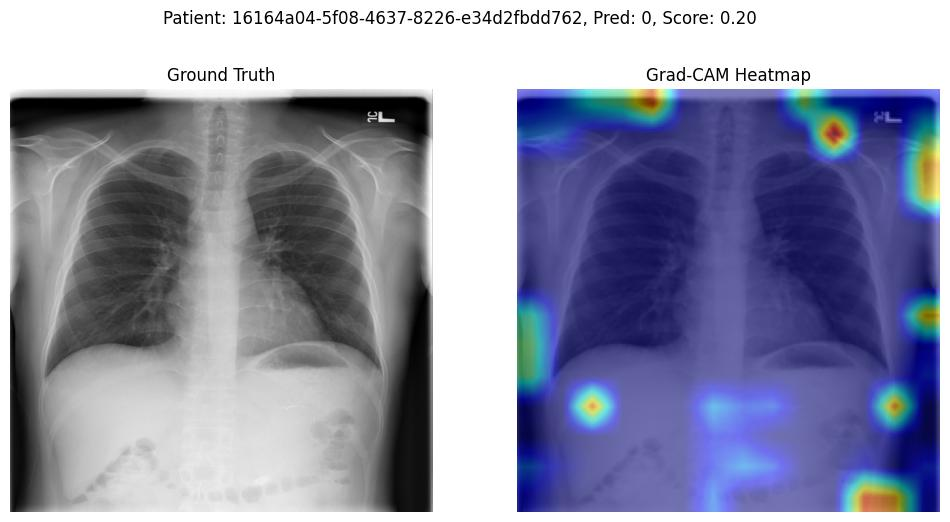

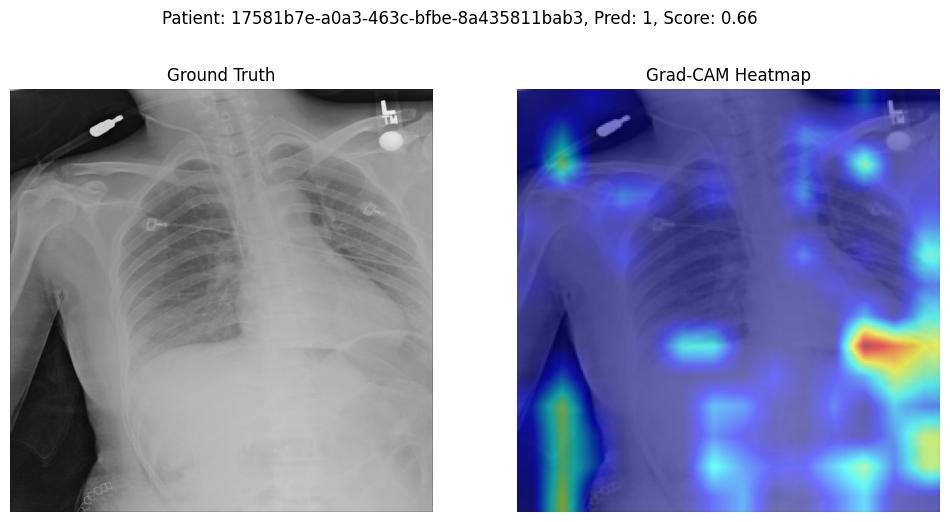

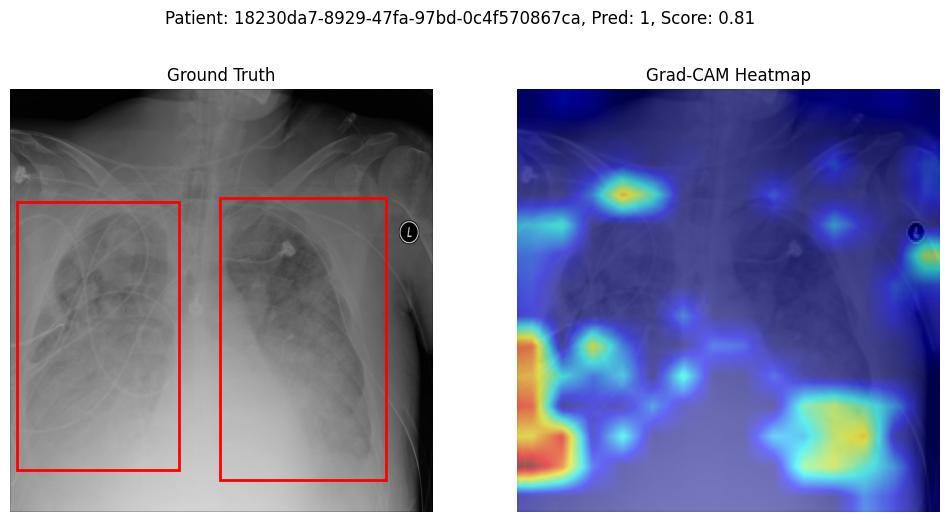

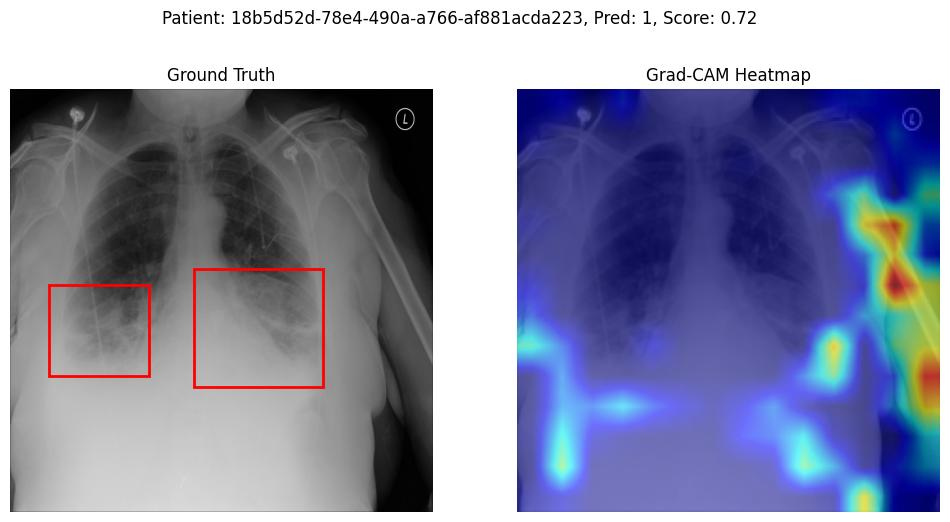

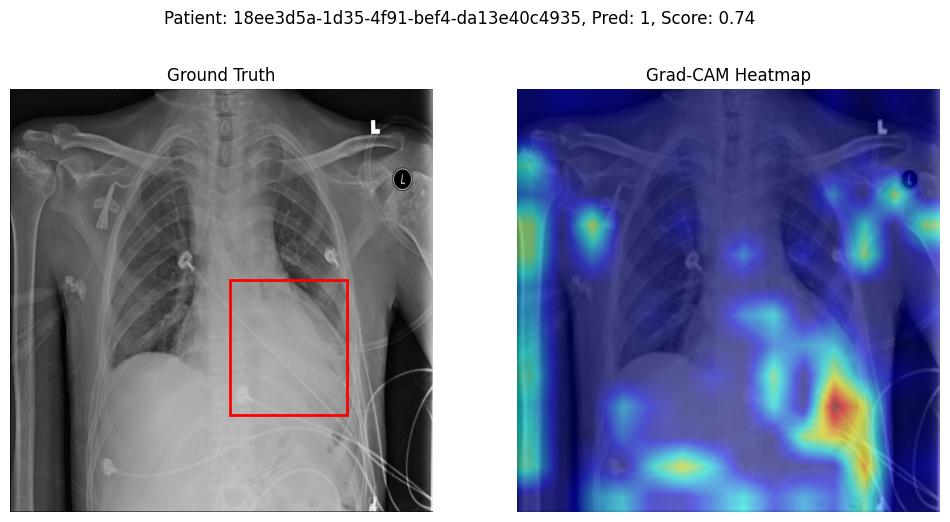

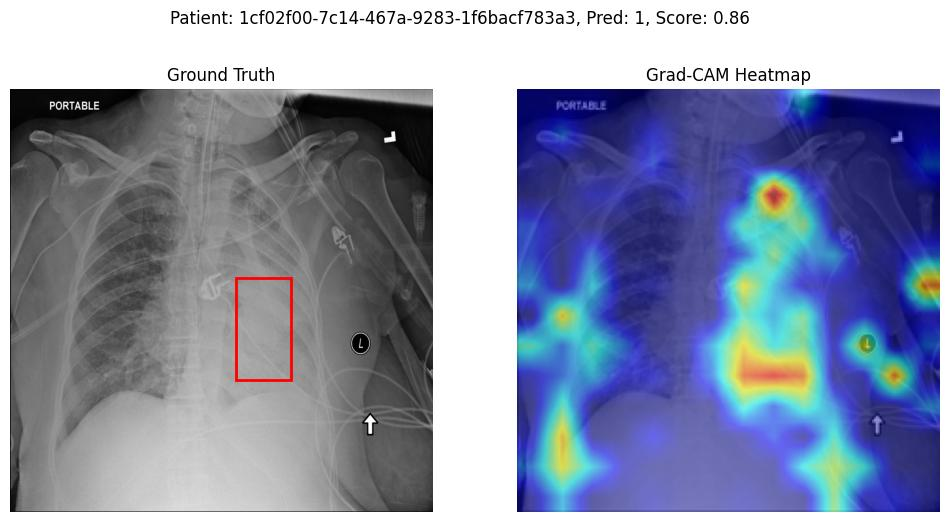

In [ ]:
# =======================
# 1️⃣ Imports & Config
# =======================
import os
import math
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import timm

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# ---------------- Config ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
NUM_SAMPLES = 30    # number of patients to process
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'


model.eval()

# =======================
# 3️⃣ Reshape transform for ViT Tiny
# =======================
def reshape_transform(tensor):
    batch_size, num_tokens, hidden_dim = tensor.size()
    spatial_size = int(math.sqrt(num_tokens - 1))  # exclude class token
    result = tensor[:, 1:, :].reshape(batch_size, spatial_size, spatial_size, hidden_dim)
    result = result.permute(0, 3, 1, 2)  # (B, C, H, W)
    return result

target_layers = [model.blocks[-1].norm1]  # last block normalization

cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

# =======================
# 4️⃣ Transform
# =======================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# =======================
# 5️⃣ Load CSV & prepare samples
# =======================
df = pd.read_csv(CSV_PATH)
sample_files = df['patientId'].unique()[:NUM_SAMPLES]

# =======================
# 6️⃣ Grad-CAM loop with GT overlay
# =======================
for pid in sample_files:
    img_path = os.path.join(IMAGE_DIR, f"{pid}.png")
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    # ---------- Prediction ----------
    with torch.no_grad():
        pred_score = model(img_tensor).item()
        pred_class = int(pred_score > 0.5)

    # ---------- Grad-CAM ----------
    targets = [ClassifierOutputTarget(0)]  # target class: pneumonia
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)[0]

    # ---------- Overlay heatmap ----------
    rgb_img = np.array(pil_img.resize((IMG_SIZE, IMG_SIZE)))/255.0
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # ---------- Ground Truth Overlay ----------
    gt_rows = df[df['patientId']==pid]

    fig, axes = plt.subplots(1,2, figsize=(12,6))

    # GT
    axes[0].imshow(pil_img)
    for _, row in gt_rows.iterrows():
        if row['Target'] == 1:
            rect = plt.Rectangle((row['x'], row['y']), row['width'], row['height'],
                                 linewidth=2, edgecolor='red', facecolor='none')
            axes[0].add_patch(rect)
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')

    # Grad-CAM heatmap
    axes[1].imshow(visualization)
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')

    plt.suptitle(f"Patient: {pid}, Pred: {pred_class}, Score: {pred_score:.2f}")
    plt.show()


**Observations**:

Grad-CAM heatmaps for ViT-Tiny tend to highlight broader, blob-like regions rather than having a focused activation, as seen in CNNs. While the attention is still concentrated within the clinically relevant regions, it is less localized, reflecting the ViT's global patch-based attention mechanism. In contrast, CNNs produce more focused activations due to the localized receptive fields of convolutional layers. 

100%|██████████| 30/30 [15:12<00:00, 30.40s/it]

Grad-CAM Entropy: 9.8505 ± 0.2901
Grad-CAM Sparsity: 0.3440 ± 0.1479


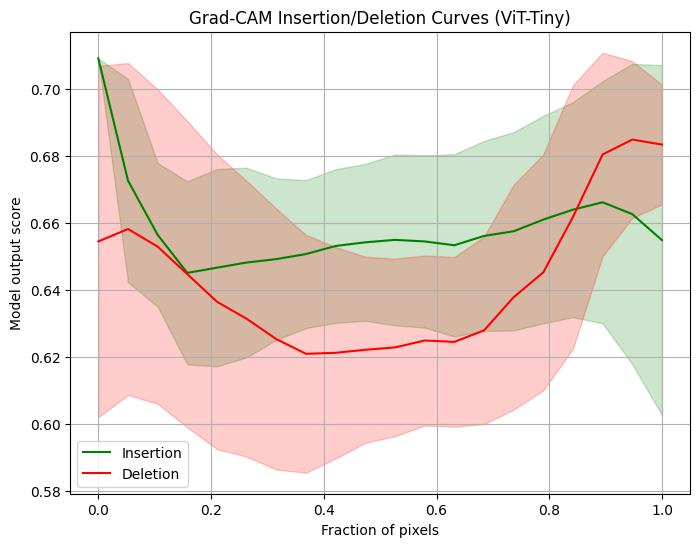

In [ ]:
import os
import math
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'
IMG_SIZE = 224
NUM_SAMPLES = 30
STEPS = 20
# ---------------------------------------

# Load CSV
df = pd.read_csv(CSV_PATH)
sample_files = df['patientId'].unique()[:NUM_SAMPLES]

# Transform for ViT input
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Ensure model is in eval mode
model.eval()

# ---------- Reshape transform for ViT-tiny ----------
def reshape_transform(tensor):
    # tensor: (batch, num_tokens, hidden_dim)
    batch_size, num_tokens, hidden_dim = tensor.size()
    spatial_size = int(math.sqrt(num_tokens - 1))  # exclude class token
    result = tensor[:, 1:, :].reshape(batch_size, spatial_size, spatial_size, hidden_dim)
    result = result.permute(0, 3, 1, 2)  # (B, C, H, W)
    return result

# Grad-CAM setup: last encoder layer norm
target_layer = [model.blocks[-1].norm1]
gradcam = GradCAM(model=model, target_layers=target_layer, reshape_transform=reshape_transform)

# ---------- Metric functions ----------
def compute_entropy_sparsity(heatmap):
    eps = 1e-8
    flat = heatmap.ravel()
    flat = flat / flat.sum()  # normalize
    entropy = -np.sum(flat * np.log(flat + eps))
    sparsity = (flat == 0).sum() / flat.size
    return entropy, sparsity

def apply_insertion_deletion(img_tensor, heatmap, model, steps=STEPS, mode="insertion"):
    _, C, H, W = img_tensor.shape
    flat_idx = np.argsort(heatmap.ravel())  # low -> high importance

    if mode=="insertion":
        masked_img = torch.zeros_like(img_tensor).to(DEVICE)
        indices_order = flat_idx[::-1]  # high importance first
    elif mode=="deletion":
        masked_img = img_tensor.clone().to(DEVICE)
        indices_order = flat_idx[::-1]  # high importance first
    else:
        raise ValueError("mode must be 'insertion' or 'deletion'")

    total_pixels = H*W
    step_size = max(total_pixels//steps, 1)
    scores = []

    for i in range(0, total_pixels, step_size):
        idx = indices_order[:i]
        ys = idx // W
        xs = idx % W
        for y, x in zip(ys, xs):
            if mode=="insertion":
                masked_img[0, :, y, x] = img_tensor[0, :, y, x]
            else:
                masked_img[0, :, y, x] = 0
        with torch.no_grad():
            out = model(masked_img)
            score = torch.sigmoid(out[0,0]).item()
        scores.append(score)

    scores = np.interp(np.linspace(0,1,steps), np.linspace(0,1,len(scores)), scores)
    return scores

# ---------- Storage ----------
entropies, sparsities = [], []
insertion_curves, deletion_curves = [], []

# ---------- Loop over dataset ----------
for pid in tqdm(sample_files):
    img_path = os.path.join(IMAGE_DIR, pid + ".png")
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    # Grad-CAM mask
    target = [ClassifierOutputTarget(0)]
    cam_mask = gradcam(input_tensor=img_tensor, targets=target)[0]
    cam_mask = (cam_mask - cam_mask.min()) / (cam_mask.max() - cam_mask.min() + 1e-8)

    # Metrics
    entropy, sparsity = compute_entropy_sparsity(cam_mask)
    entropies.append(entropy)
    sparsities.append(sparsity)

    insertion_scores = apply_insertion_deletion(img_tensor, cam_mask, model, mode="insertion")
    deletion_scores = apply_insertion_deletion(img_tensor, cam_mask, model, mode="deletion")
    insertion_curves.append(insertion_scores)
    deletion_curves.append(deletion_scores)

# ---------- Convert to numpy ----------
entropies = np.array(entropies)
sparsities = np.array(sparsities)
insertion_curves = np.array(insertion_curves)
deletion_curves = np.array(deletion_curves)

# ---------- Print results ----------
print(f"Grad-CAM Entropy: {entropies.mean():.4f} ± {entropies.std():.4f}")
print(f"Grad-CAM Sparsity: {sparsities.mean():.4f} ± {sparsities.std():.4f}")

# ---------- Plot mean ± std curves ----------
x = np.linspace(0,1,STEPS)
plt.figure(figsize=(8,6))
plt.plot(x, insertion_curves.mean(axis=0), label="Insertion", color="green")
plt.fill_between(x, insertion_curves.mean(axis=0)-insertion_curves.std(axis=0),
                 insertion_curves.mean(axis=0)+insertion_curves.std(axis=0),
                 color="green", alpha=0.2)
plt.plot(x, deletion_curves.mean(axis=0), label="Deletion", color="red")
plt.fill_between(x, deletion_curves.mean(axis=0)-deletion_curves.std(axis=0),
                 deletion_curves.mean(axis=0)+deletion_curves.std(axis=0),
                 color="red", alpha=0.2)
plt.xlabel("Fraction of pixels")
plt.ylabel("Model output score")
plt.title("Grad-CAM Insertion/Deletion Curves (ViT-Tiny)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import auc
import numpy as np

# x-axis: fraction of pixels added/removed
x = np.linspace(0, 1, STEPS)

# Mean curves across all samples
ins_mean = insertion_curves.mean(axis=0)
del_mean = deletion_curves.mean(axis=0)

# Compute AUC
auc_insertion = auc(x, ins_mean)
auc_deletion = auc(x, del_mean)

print(f"Insertion AUC: {auc_insertion:.4f}")
print(f"Deletion AUC: {auc_deletion:.4f}")


Insertion AUC: 0.6573
Deletion AUC: 0.6417


**Observations**:

The relatively low Sparsity indicates that the attention is distributed more uniformly across a majority of pixels. The moderately low Entropy suggests that these activations further have meaningful regions instead of the focus being fully diffused. This pattern reflects the ViT’s inherent global attention, which is then guided to more relevant areas by the Grad-CAM variants' mechanism. The unintuitive curve structure of the Insertion/Deletion graph indicates this pattern conflict too.

## Grad-CAM++: Visualizing model attention

**Concept**:

Grad-CAM++ refines Grad-CAM by incorporating higher-order gradient information. This enhances localization and handling of multiple object instances.

**Purpose**:

Used to asses how finely the model distinguishes multiple features or parts within an image.

**Quick references**:

Chattopadhyay et al., Grad-CAM++: Improved Visual Explanations for Deep Convolutional Networks, WACV 2018.

Gildenblat, pytorch-grad-cam library — robust reference implementation.

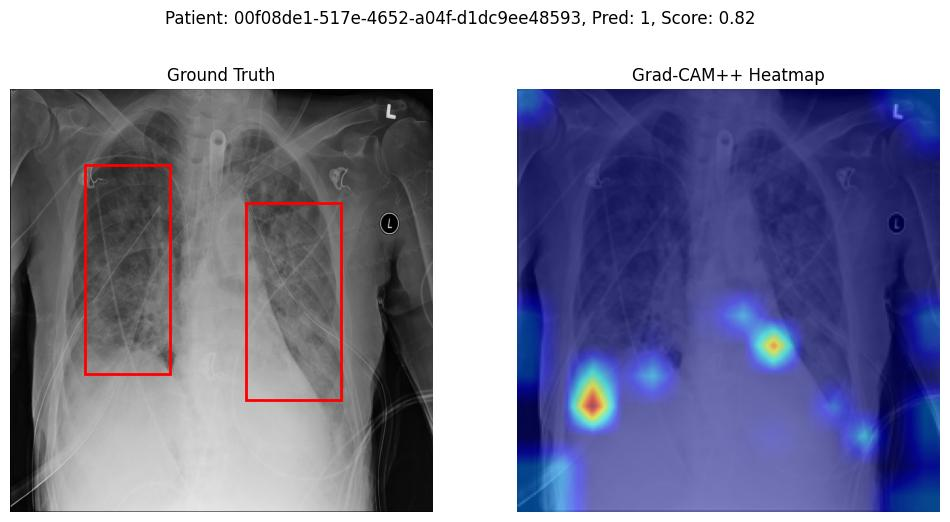

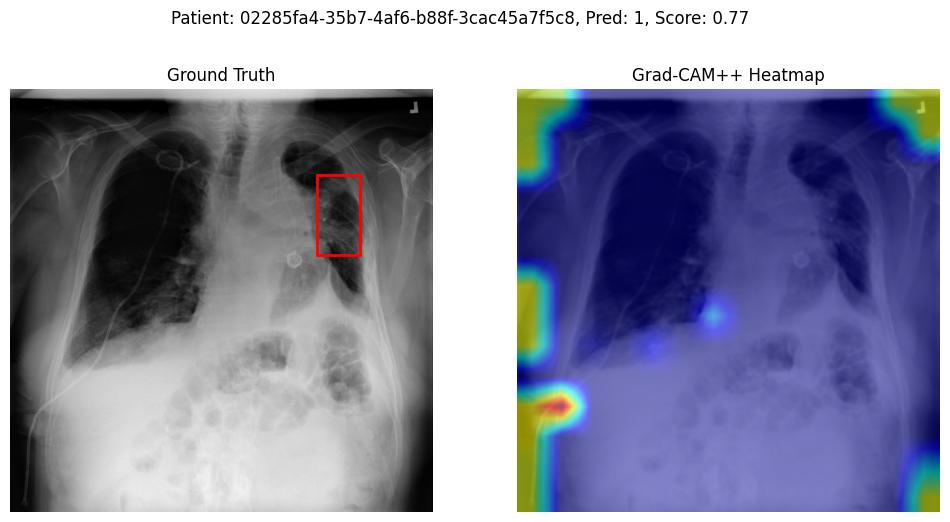

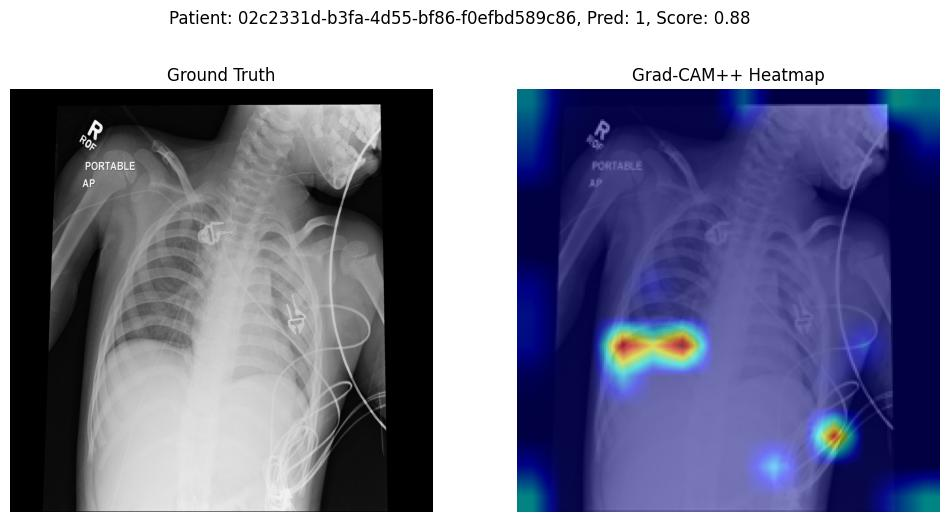

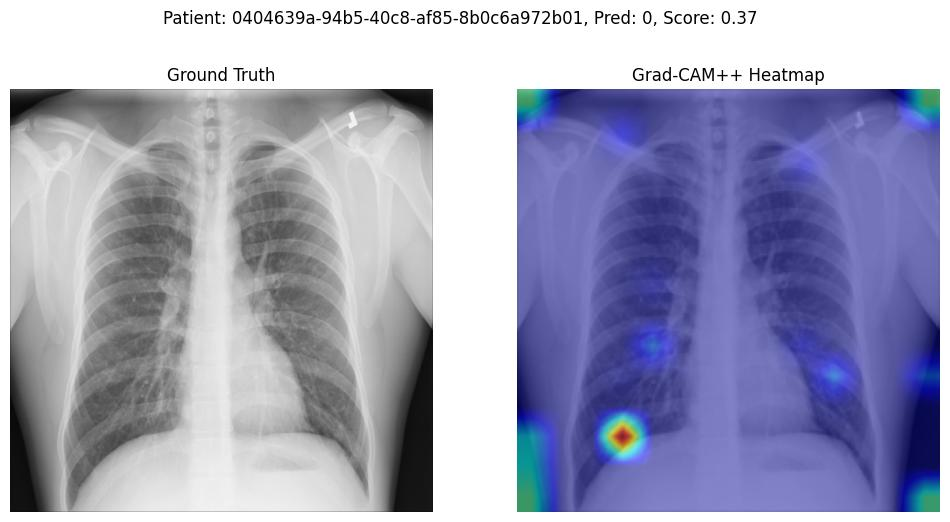

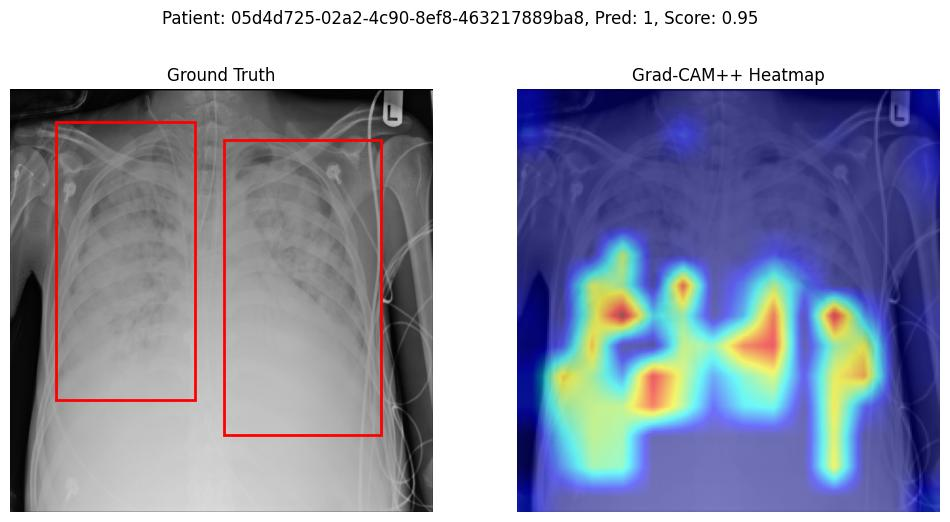

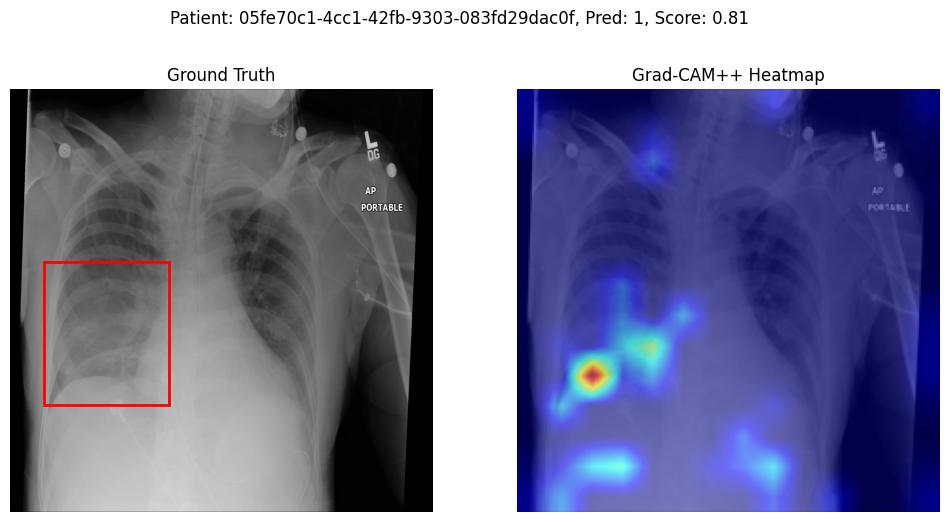

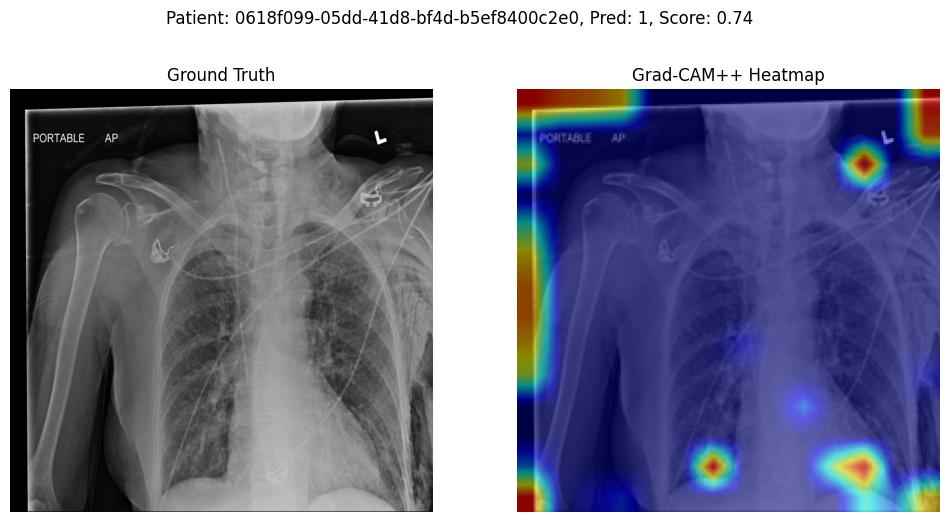

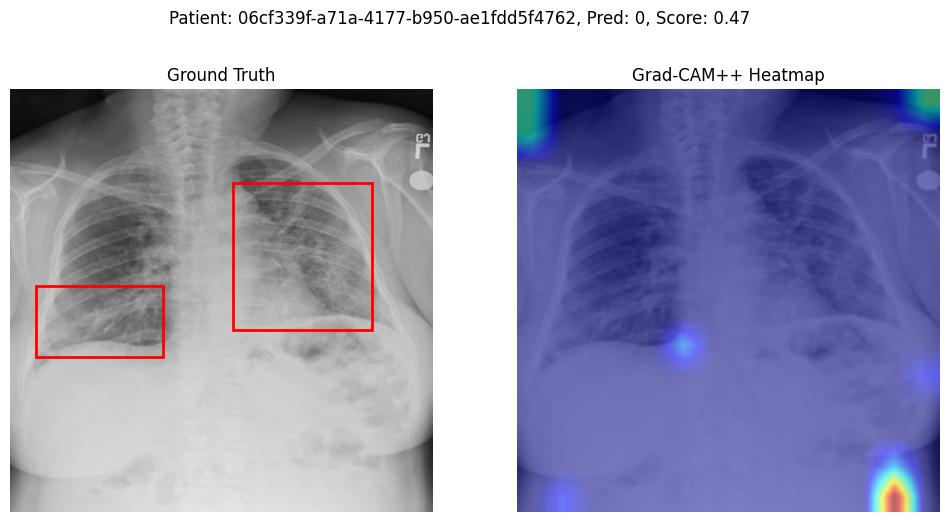

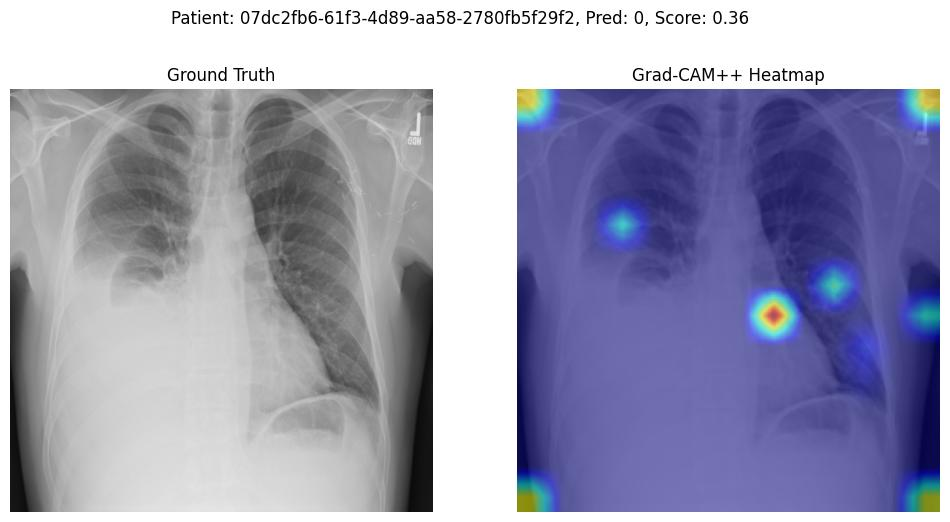

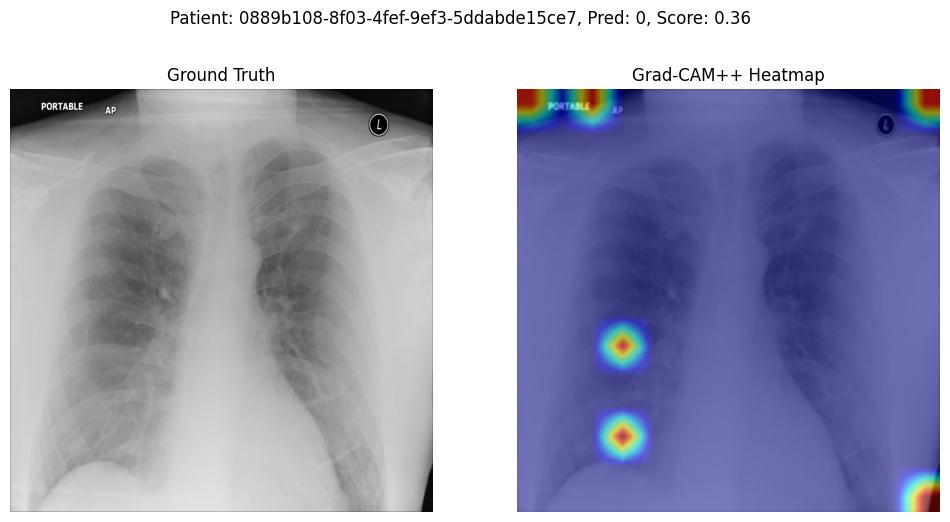

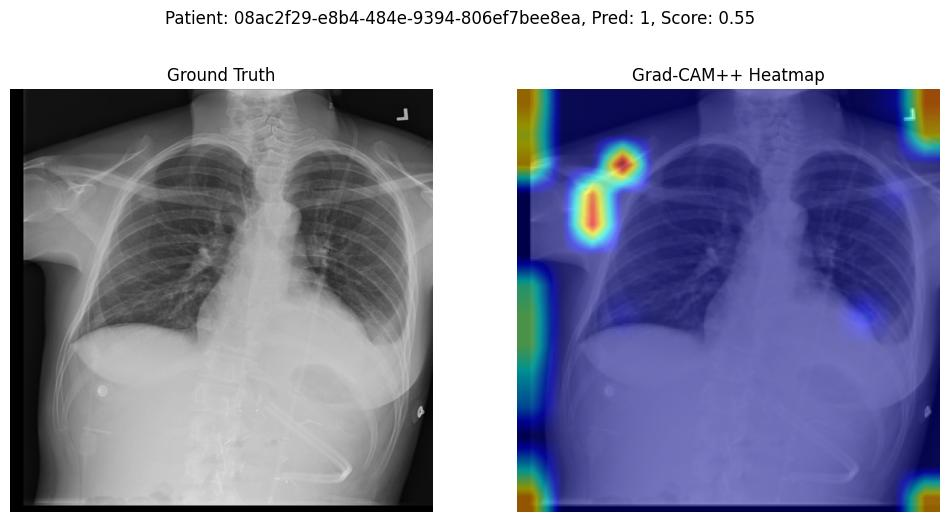

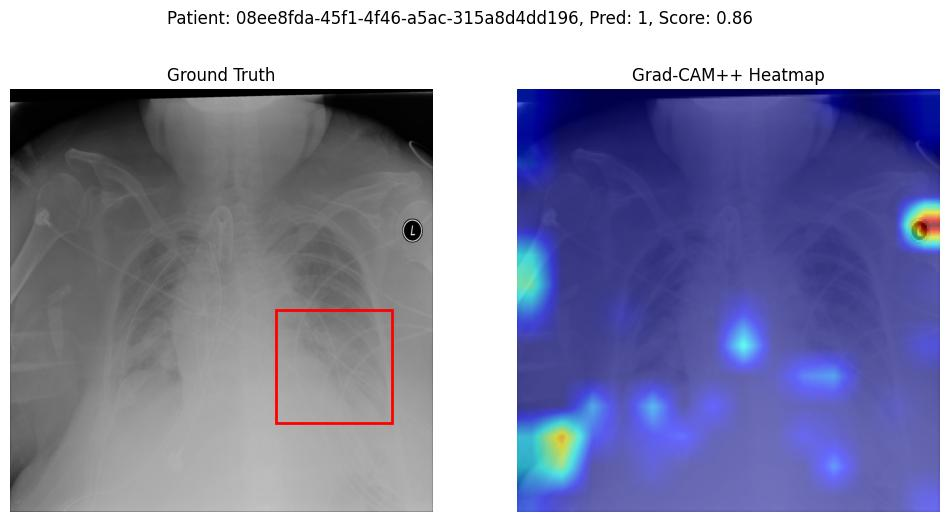

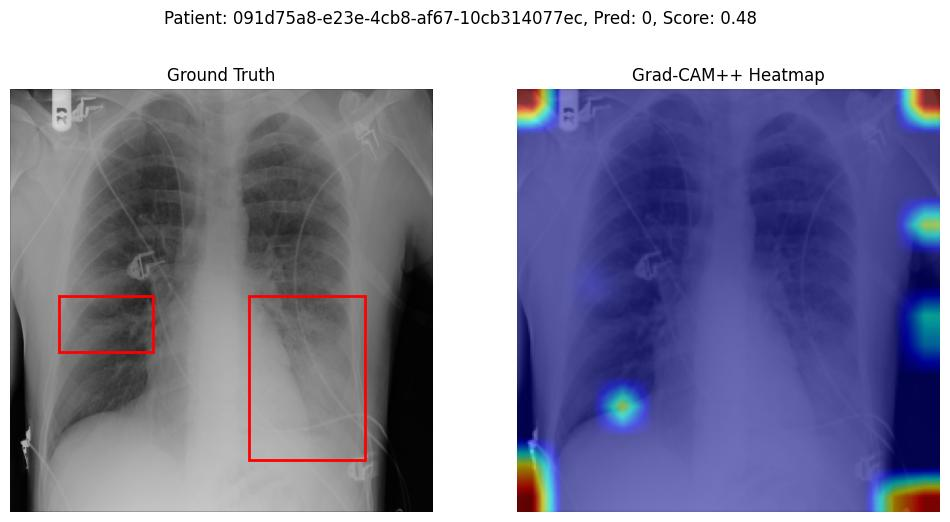

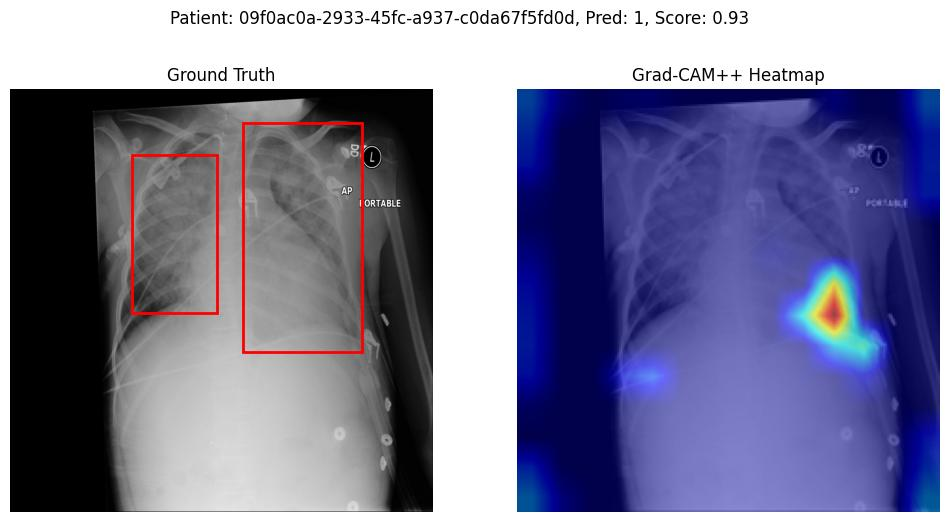

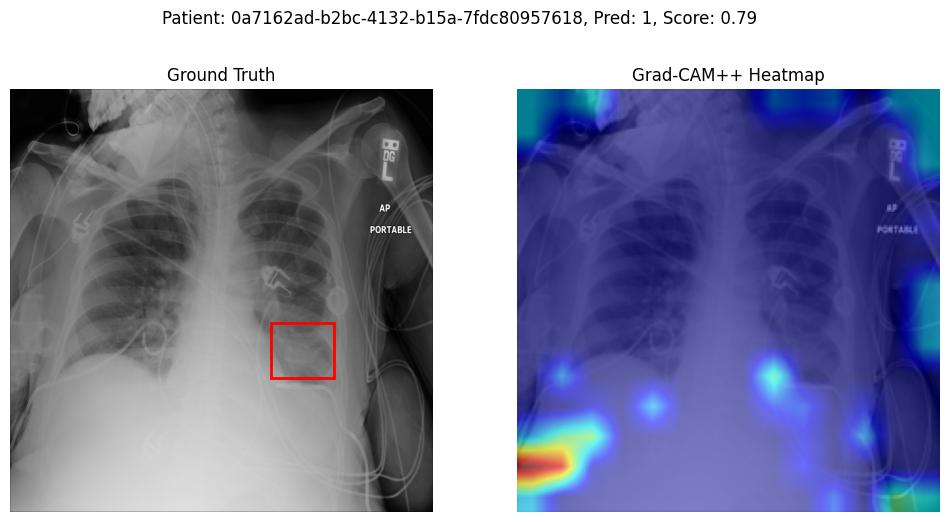

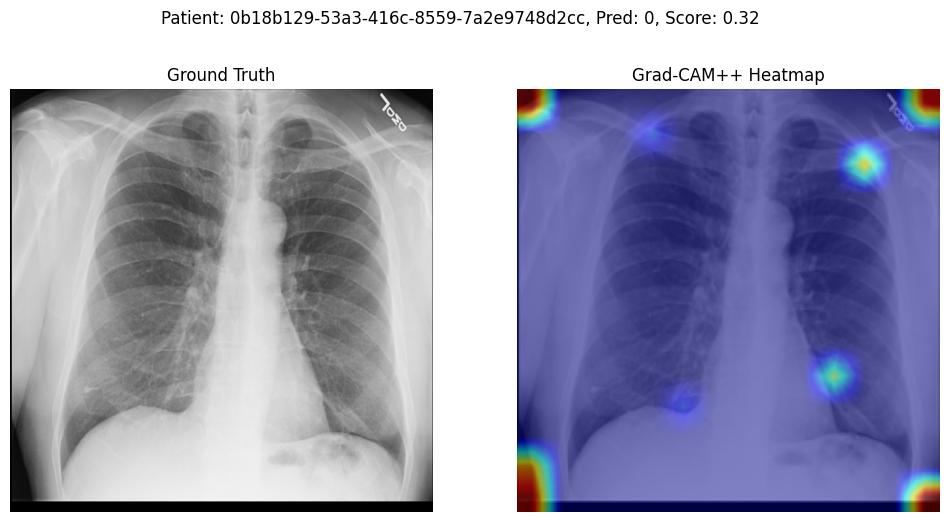

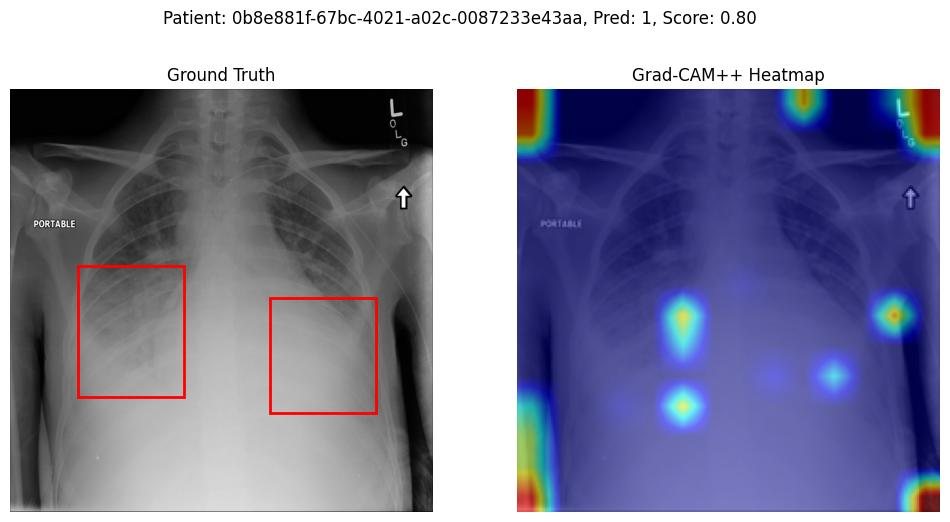

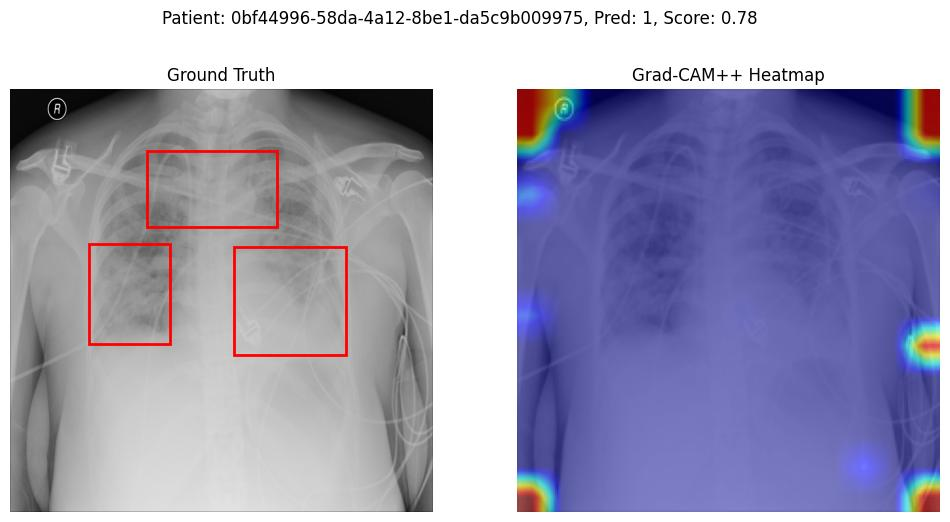

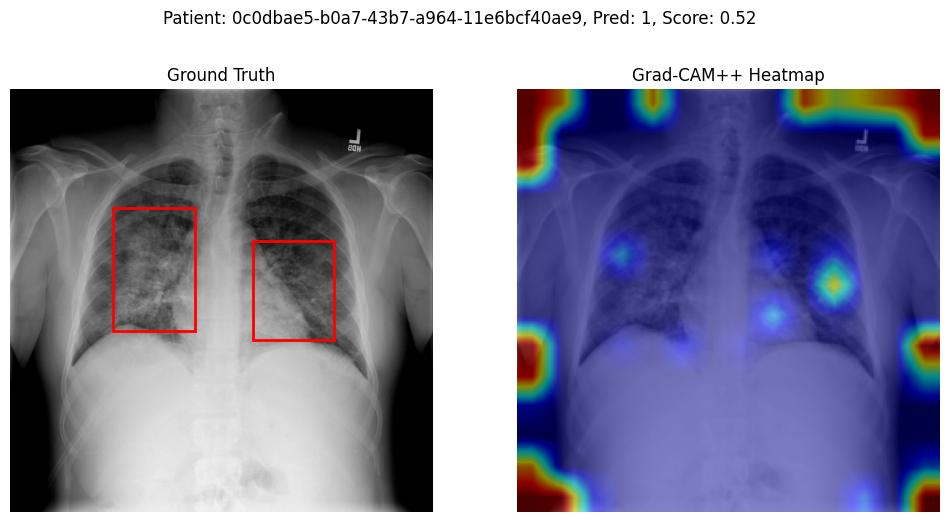

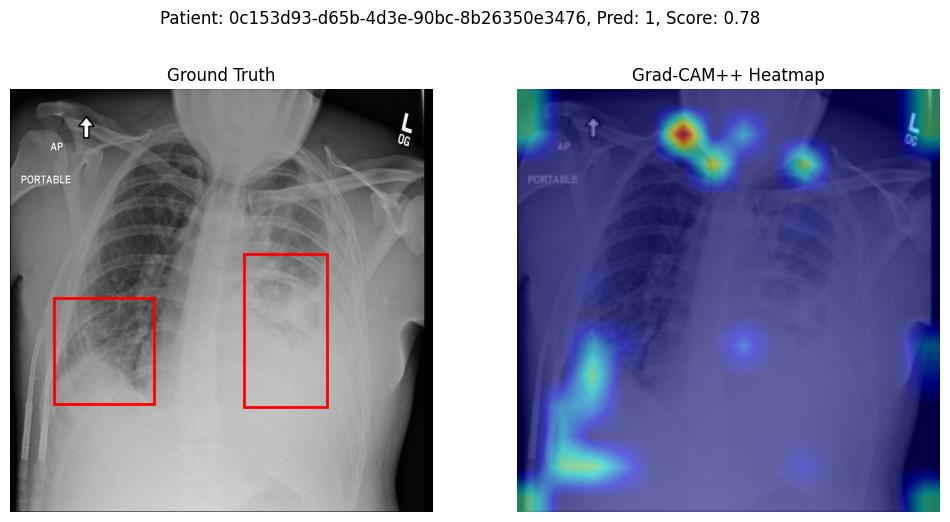

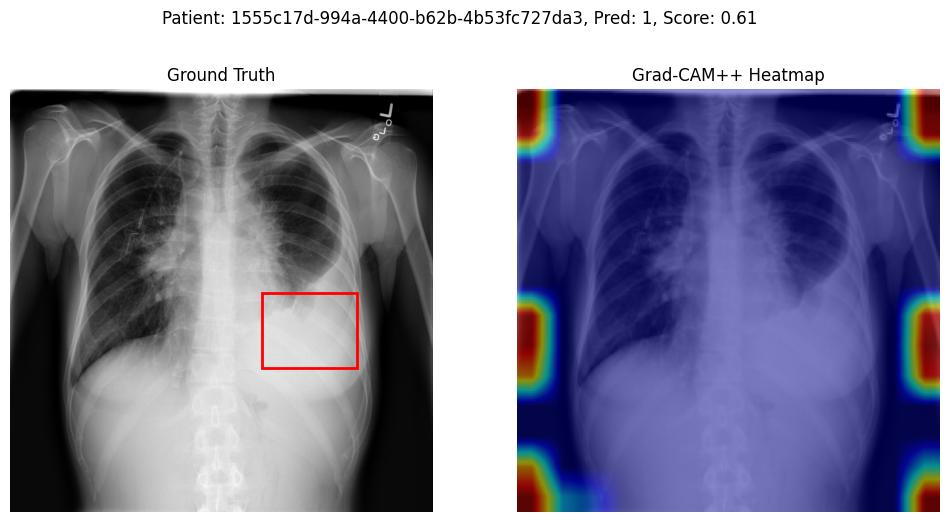

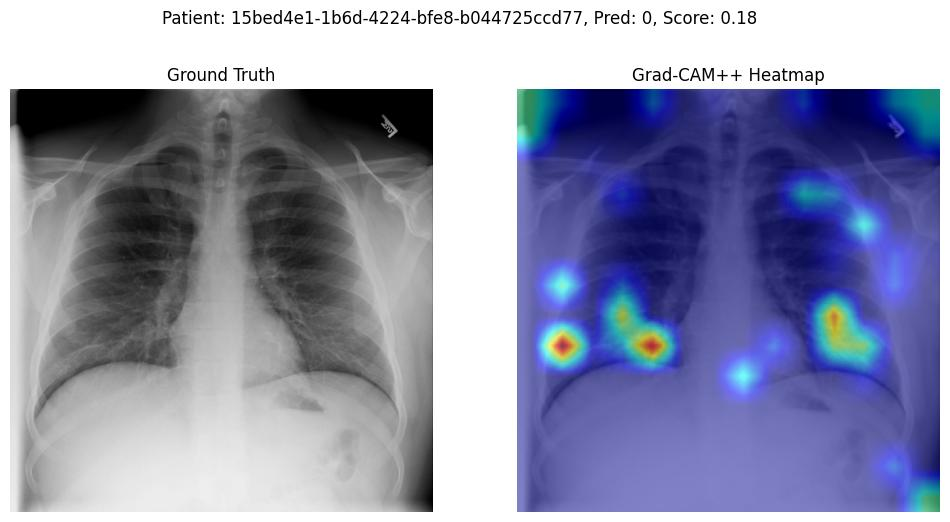

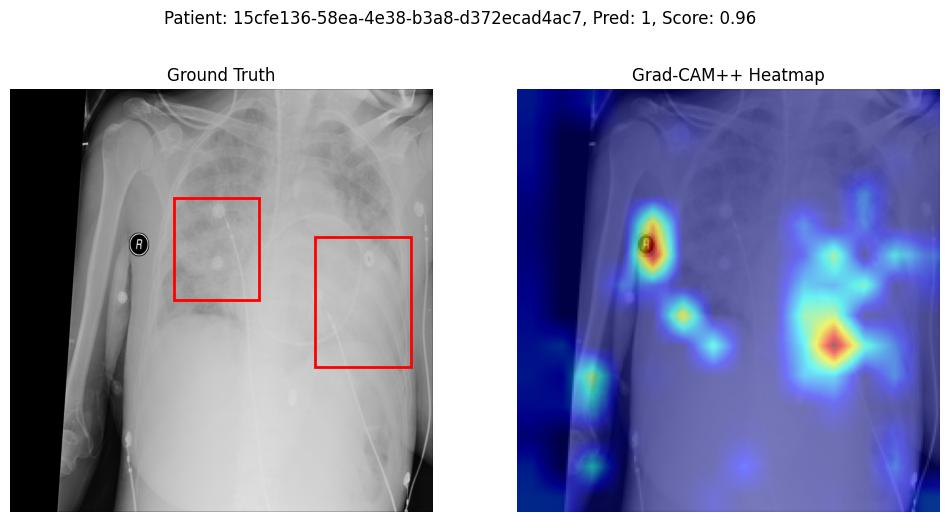

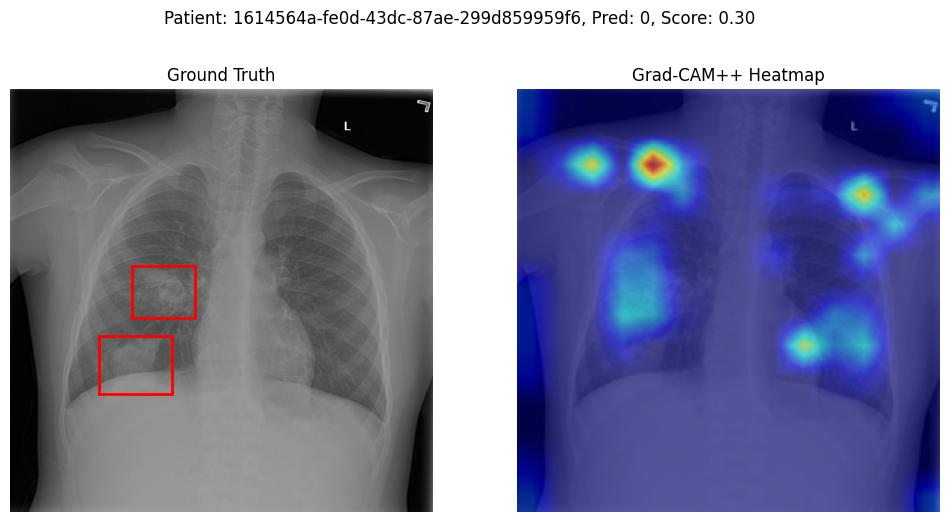

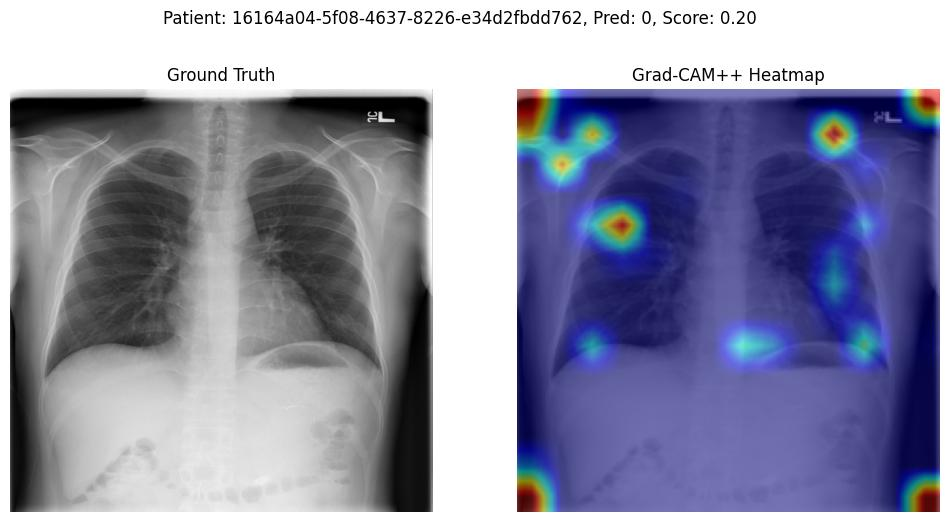

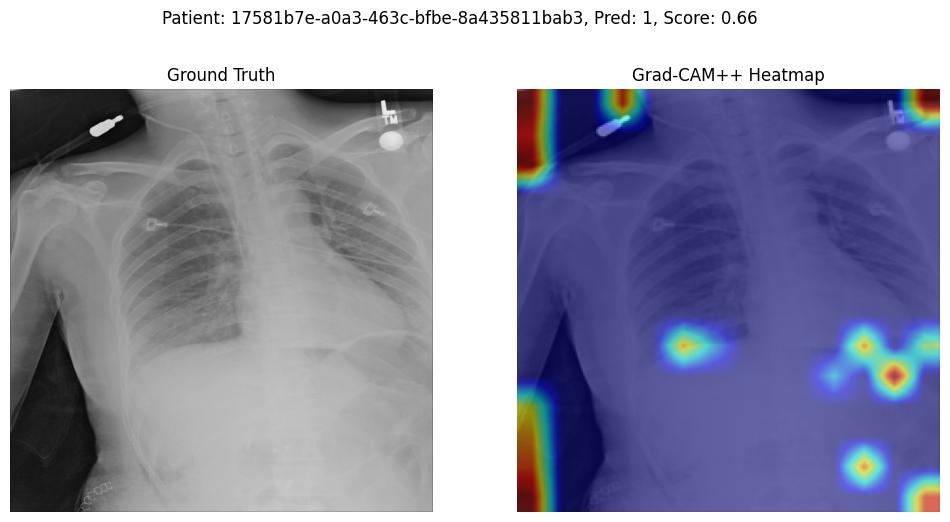

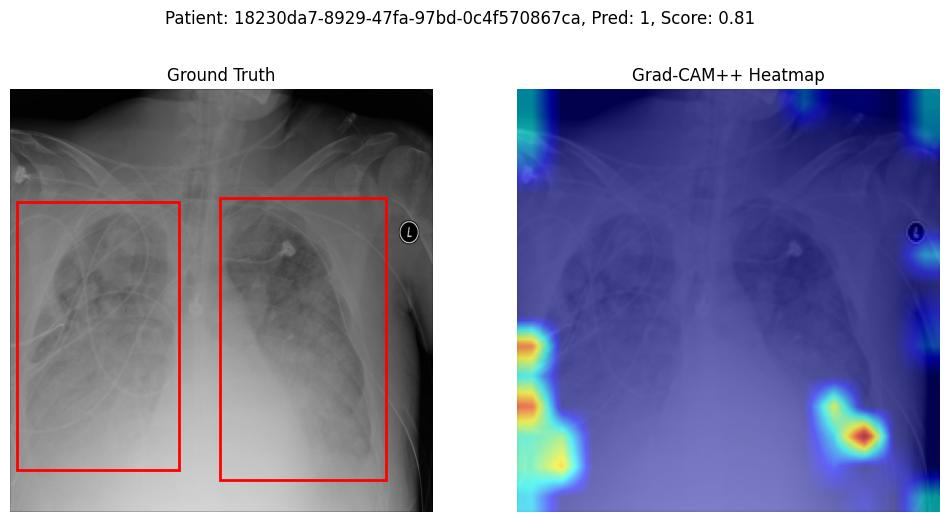

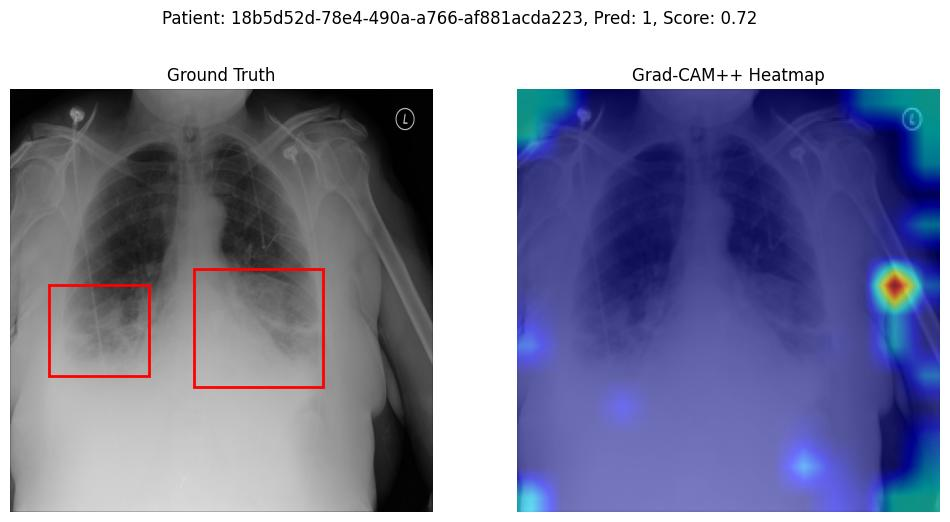

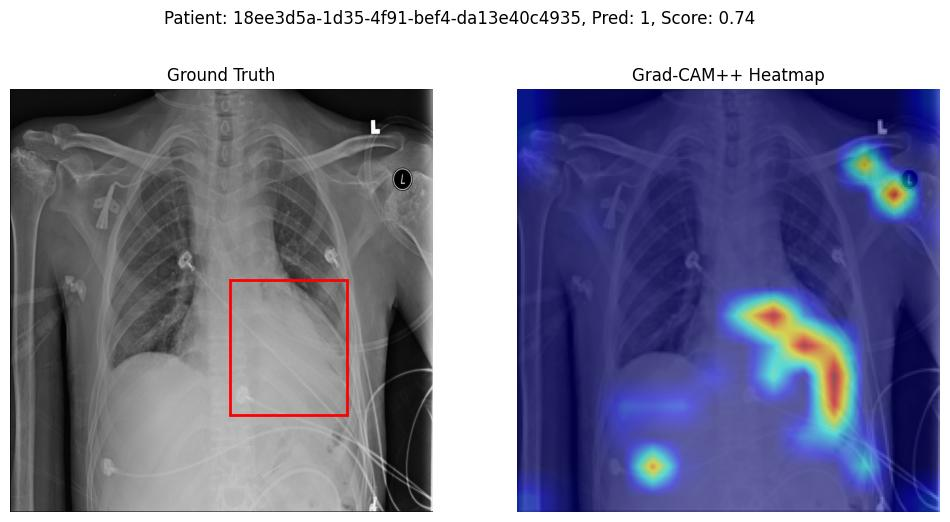

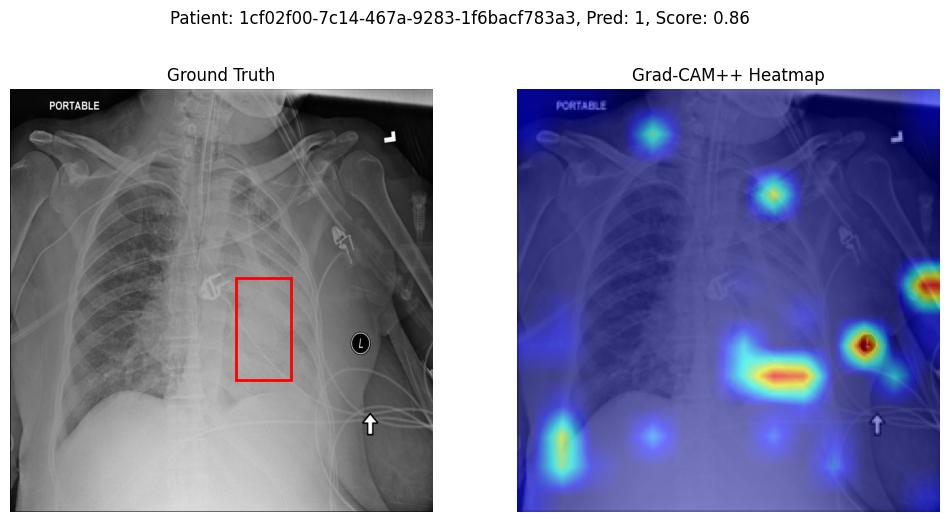

In [ ]:
# =======================
# 1️⃣ Imports & Config
# =======================
import os
import math
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import timm

from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# ---------------- Config ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
NUM_SAMPLES = 30    # number of patients to process
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'

# =======================
# 2️⃣ Load model
# =======================
model = timm.create_model('vit_tiny_patch16_224', pretrained=False)
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 1),
    nn.Sigmoid()
)
model.to(DEVICE)

SAVE_PATH = '/content/drive/MyDrive/RSNA_subset/vit_best_epoch/higher_accuracy_vit.pth'
model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
model.eval()

# =======================
# 3️⃣ Reshape transform for ViT Tiny
# =======================
def reshape_transform(tensor):
    batch_size, num_tokens, hidden_dim = tensor.size()
    spatial_size = int(math.sqrt(num_tokens - 1))  # exclude class token
    result = tensor[:, 1:, :].reshape(batch_size, spatial_size, spatial_size, hidden_dim)
    result = result.permute(0, 3, 1, 2)  # (B, C, H, W)
    return result

target_layers = [model.blocks[-1].norm1]  # last block normalization

cam = GradCAMPlusPlus(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

# =======================
# 4️⃣ Transform
# =======================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# =======================
# 5️⃣ Load CSV & prepare samples
# =======================
df = pd.read_csv(CSV_PATH)
sample_files = df['patientId'].unique()[:NUM_SAMPLES]

# =======================
# 6️⃣ Grad-CAM loop with GT overlay
# =======================
for pid in sample_files:
    img_path = os.path.join(IMAGE_DIR, f"{pid}.png")
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    # ---------- Prediction ----------
    with torch.no_grad():
        pred_score = model(img_tensor).item()
        pred_class = int(pred_score > 0.5)

    # ---------- Grad-CAM ----------
    targets = [ClassifierOutputTarget(0)]  # target class: pneumonia
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)[0]

    # ---------- Overlay heatmap ----------
    rgb_img = np.array(pil_img.resize((IMG_SIZE, IMG_SIZE)))/255.0
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # ---------- Ground Truth Overlay ----------
    gt_rows = df[df['patientId']==pid]

    fig, axes = plt.subplots(1,2, figsize=(12,6))

    # GT
    axes[0].imshow(pil_img)
    for _, row in gt_rows.iterrows():
        if row['Target'] == 1:
            rect = plt.Rectangle((row['x'], row['y']), row['width'], row['height'],
                                 linewidth=2, edgecolor='red', facecolor='none')
            axes[0].add_patch(rect)
    axes[0].set_title('Ground Truth')
    axes[0].axis('off')

    # Grad-CAM heatmap
    axes[1].imshow(visualization)
    axes[1].set_title('Grad-CAM++ Heatmap')
    axes[1].axis('off')

    plt.suptitle(f"Patient: {pid}, Pred: {pred_class}, Score: {pred_score:.2f}")
    plt.show()


**Observations**:

Grad-CAM++ heatmaps often highlight corner regions in addition to the lungs, more so than Grad-CAM. This occurs because Grad-CAM++ considers higher-order gradient terms and assigns non-zero weight to pixels with even weak influence, producing more distributed activations. Consequently, weakly correlated or edge regions may appear highlighted, whereas Grad-CAM tends to focus on the strongest, most dominant regions.

100%|██████████| 30/30 [15:12<00:00, 30.42s/it]


Grad-CAM Entropy: 9.0063 ± 0.4853
Grad-CAM Sparsity: 0.6825 ± 0.1422


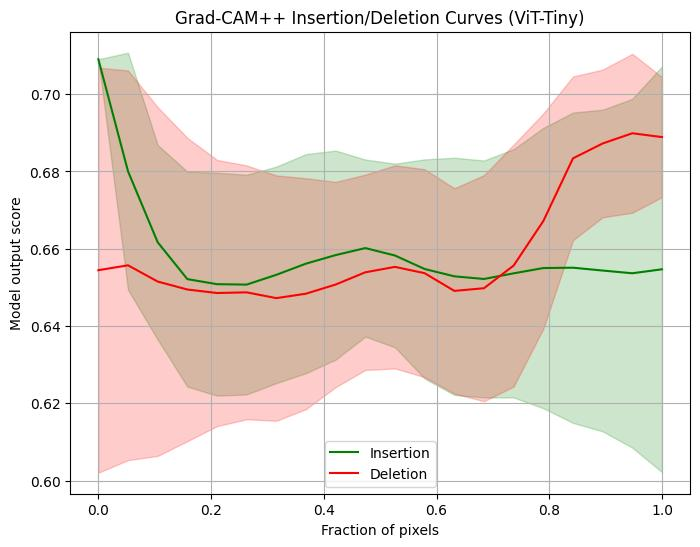

In [ ]:
import os
import math
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'
IMG_SIZE = 224
NUM_SAMPLES = 30
STEPS = 20
# ---------------------------------------

# Load CSV
df = pd.read_csv(CSV_PATH)
sample_files = df['patientId'].unique()[:NUM_SAMPLES]

# Transform for ViT input
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Ensure model is in eval mode
model.eval()

# ---------- Reshape transform for ViT-tiny ----------
def reshape_transform(tensor):
    # tensor: (batch, num_tokens, hidden_dim)
    batch_size, num_tokens, hidden_dim = tensor.size()
    spatial_size = int(math.sqrt(num_tokens - 1))  # exclude class token
    result = tensor[:, 1:, :].reshape(batch_size, spatial_size, spatial_size, hidden_dim)
    result = result.permute(0, 3, 1, 2)  # (B, C, H, W)
    return result

# Grad-CAM setup: last encoder layer norm
target_layer = [model.blocks[-1].norm1]
gradcam = GradCAMPlusPlus(model=model, target_layers=target_layer, reshape_transform=reshape_transform)

# ---------- Metric functions ----------
def compute_entropy_sparsity(heatmap):
    eps = 1e-8
    flat = heatmap.ravel()
    flat = flat / flat.sum()  # normalize
    entropy = -np.sum(flat * np.log(flat + eps))
    sparsity = (flat == 0).sum() / flat.size
    return entropy, sparsity

def apply_insertion_deletion(img_tensor, heatmap, model, steps=STEPS, mode="insertion"):
    _, C, H, W = img_tensor.shape
    flat_idx = np.argsort(heatmap.ravel())  # low -> high importance

    if mode=="insertion":
        masked_img = torch.zeros_like(img_tensor).to(DEVICE)
        indices_order = flat_idx[::-1]  # high importance first
    elif mode=="deletion":
        masked_img = img_tensor.clone().to(DEVICE)
        indices_order = flat_idx[::-1]  # high importance first
    else:
        raise ValueError("mode must be 'insertion' or 'deletion'")

    total_pixels = H*W
    step_size = max(total_pixels//steps, 1)
    scores = []

    for i in range(0, total_pixels, step_size):
        idx = indices_order[:i]
        ys = idx // W
        xs = idx % W
        for y, x in zip(ys, xs):
            if mode=="insertion":
                masked_img[0, :, y, x] = img_tensor[0, :, y, x]
            else:
                masked_img[0, :, y, x] = 0
        with torch.no_grad():
            out = model(masked_img)
            score = torch.sigmoid(out[0,0]).item()
        scores.append(score)

    scores = np.interp(np.linspace(0,1,steps), np.linspace(0,1,len(scores)), scores)
    return scores

# ---------- Storage ----------
entropies, sparsities = [], []
insertion_curves, deletion_curves = [], []

# ---------- Loop over dataset ----------
for pid in tqdm(sample_files):
    img_path = os.path.join(IMAGE_DIR, pid + ".png")
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    # Grad-CAM mask
    target = [ClassifierOutputTarget(0)]
    cam_mask = gradcam(input_tensor=img_tensor, targets=target)[0]
    cam_mask = (cam_mask - cam_mask.min()) / (cam_mask.max() - cam_mask.min() + 1e-8)

    # Metrics
    entropy, sparsity = compute_entropy_sparsity(cam_mask)
    entropies.append(entropy)
    sparsities.append(sparsity)

    insertion_scores = apply_insertion_deletion(img_tensor, cam_mask, model, mode="insertion")
    deletion_scores = apply_insertion_deletion(img_tensor, cam_mask, model, mode="deletion")
    insertion_curves.append(insertion_scores)
    deletion_curves.append(deletion_scores)

# ---------- Convert to numpy ----------
entropies = np.array(entropies)
sparsities = np.array(sparsities)
insertion_curves = np.array(insertion_curves)
deletion_curves = np.array(deletion_curves)

# ---------- Print results ----------
print(f"Grad-CAM Entropy: {entropies.mean():.4f} ± {entropies.std():.4f}")
print(f"Grad-CAM Sparsity: {sparsities.mean():.4f} ± {sparsities.std():.4f}")

# ---------- Plot mean ± std curves ----------
x = np.linspace(0,1,STEPS)
plt.figure(figsize=(8,6))
plt.plot(x, insertion_curves.mean(axis=0), label="Insertion", color="green")
plt.fill_between(x, insertion_curves.mean(axis=0)-insertion_curves.std(axis=0),
                 insertion_curves.mean(axis=0)+insertion_curves.std(axis=0),
                 color="green", alpha=0.2)
plt.plot(x, deletion_curves.mean(axis=0), label="Deletion", color="red")
plt.fill_between(x, deletion_curves.mean(axis=0)-deletion_curves.std(axis=0),
                 deletion_curves.mean(axis=0)+deletion_curves.std(axis=0),
                 color="red", alpha=0.2)
plt.xlabel("Fraction of pixels")
plt.ylabel("Model output score")
plt.title("Grad-CAM++ Insertion/Deletion Curves (ViT-Tiny)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(f"Grad-CAM++ Entropy: {entropies.mean():.4f} ± {entropies.std():.4f}")
print(f"Grad-CAM++ Sparsity: {sparsities.mean():.4f} ± {sparsities.std():.4f}")


Grad-CAM++ Entropy: 9.0063 ± 0.4853
Grad-CAM++ Sparsity: 0.6825 ± 0.1422


**Observations**:

Grad-CAM++ heatmaps have a higher Sparsity and lower Entropy compared to Grad-CAM, indicating that the attention is more concentrated on a smaller set of influential pixels. While Grad-CAM highlights broader regions, Grad-CAM++ selectively emphasizes the most critical subregions within the lungs, producing sharper explanations, even though the weak activations in the corner regions may flare up due to higher-order gradient weighting. The impact of these weaker activations is seen in the unintuitive curve structure of the Insertion/Deletion graph. 

In [ ]:
from sklearn.metrics import auc
import numpy as np

# x-axis: fraction of pixels added/removed
x = np.linspace(0, 1, STEPS)

# Mean curves across all samples
ins_mean = insertion_curves.mean(axis=0)
del_mean = deletion_curves.mean(axis=0)

# Compute AUC
auc_insertion = auc(x, ins_mean)
auc_deletion = auc(x, del_mean)

print(f"Insertion AUC: {auc_insertion:.4f}")
print(f"Deletion AUC: {auc_deletion:.4f}")


Insertion AUC: 0.6576
Deletion AUC: 0.6588


## Attention Rollout

**Concept**:

Attention Rollout aggregates attention weight across the transformer layers to visualize how information flows from the input token to the class token.

**Purpose**:

It is used to understand token-level attention propagation and to identify the spatial regions that are strongly integrated by the ViT.

In [ ]:
# =======================
# 1️⃣ Imports & Config
# =======================
import os
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import pandas as pd
import cv2

# ---------------- Config ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
NUM_SAMPLES = 30
IMAGE_DIR = '/content/drive/MyDrive/RSNA_subset/images'
CSV_PATH = '/content/drive/MyDrive/RSNA_subset/labels_subset.csv'

# ---------------- Model ----------------
# before-localization model
model.eval().to(DEVICE)

# =======================
# 2️⃣ Transform
# =======================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# =======================
# 3️⃣ Sample files
# =======================
df = pd.read_csv(CSV_PATH)
sample_files = df['patientId'].unique()[:NUM_SAMPLES]

# =======================
# 4️⃣ Patch Attention: Store weights
# =======================
for block in model.blocks:
    attn_module = block.attn
    if not hasattr(attn_module, "_original_forward"):
        attn_module._original_forward = attn_module.forward

    def forward_with_weights(self_module, x, **kwargs):
        B, N, C = x.shape
        qkv = self_module.qkv(x).reshape(B, N, 3, self_module.num_heads, C // self_module.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)
        attn = (q @ k.transpose(-2, -1)) * self_module.scale
        attn = attn.softmax(dim=-1)
        self_module.attn_output_weights = attn
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = self_module.proj(out)
        out = self_module.proj_drop(out)
        return out

    attn_module.forward = forward_with_weights.__get__(attn_module, attn_module.__class__)

# =======================
# 5️⃣ Attention Rollout Class (same)
# =======================
class AttentionRollout:
    def __init__(self, model, discard_ratio=0.0, head_fusion="mean"):
        self.model = model
        self.discard_ratio = discard_ratio
        self.head_fusion = head_fusion
        self.attentions = []

        # register hooks
        for block in self.model.blocks:
            block.attn.register_forward_hook(self._get_attention)

    def _get_attention(self, module, input, output):
        if hasattr(module, 'attn_output_weights'):
            attn_weights = module.attn_output_weights
            if attn_weights is not None:
                self.attentions.append(attn_weights.detach())

    def __call__(self, x):
        self.attentions = []
        _ = self.model(x)

        if not self.attentions:
            raise RuntimeError("No attention weights captured.")

        N = self.attentions[0].size(-1)
        result = torch.eye(N, device=x.device)

        for attention in self.attentions:
            # fuse heads
            if self.head_fusion == "mean":
                attn_heads_fused = attention.mean(dim=1)
            elif self.head_fusion == "max":
                attn_heads_fused = attention.max(dim=1)[0]
            else:
                raise ValueError("Unknown head_fusion")

            # discard ratio
            if self.discard_ratio > 0:
                flat = attn_heads_fused.view(-1)
                k = int(flat.size(0)*(1-self.discard_ratio))
                if k>0:
                    _, indices = flat.topk(k, largest=False)
                    flat[indices] = 0
                attn_heads_fused = flat.view(attn_heads_fused.size())

            result = torch.matmul(attn_heads_fused, result)

        return result[0]  # first batch N x N

# =======================
# 6️⃣ Rollout → Fully Zoomed-out Heatmap
# =======================
def rollout_to_mask_global(rollout, img_tensor, final_size=224, blur=True, blur_kernel=11):
    mask = rollout(img_tensor)           # N x N
    num_patches = mask.shape[1] - 1
    cls_row = mask[0, 1:]               # CLS to all patches

    cls_row = cls_row / (cls_row.max() + 1e-8)  # normalize

    side = int(math.sqrt(num_patches))
    patch_grid = cls_row.reshape(side, side).detach().cpu().numpy()

    # strong blur for smooth global attention
    if blur:
        patch_grid = cv2.GaussianBlur(patch_grid, (blur_kernel, blur_kernel), 0)

    # upscale using bicubic for smoother map
    mask_img = cv2.resize(patch_grid, (final_size, final_size), interpolation=cv2.INTER_CUBIC)
    mask_img = mask_img / (mask_img.max() + 1e-8)
    return mask_img


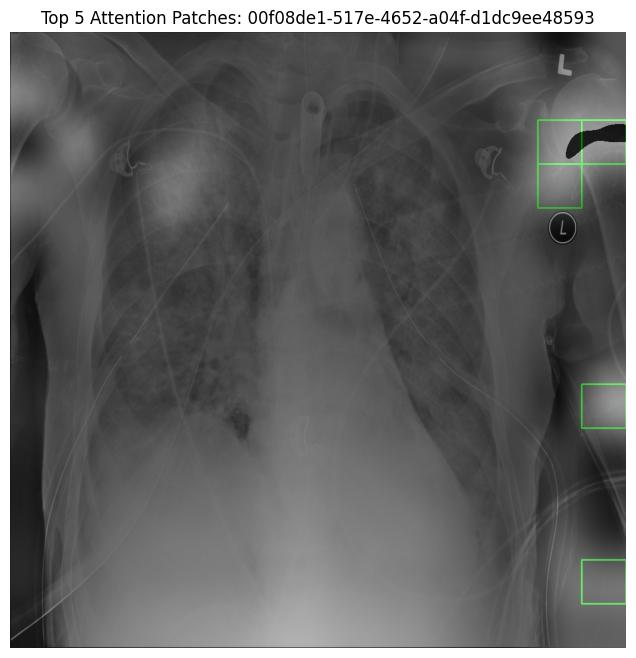

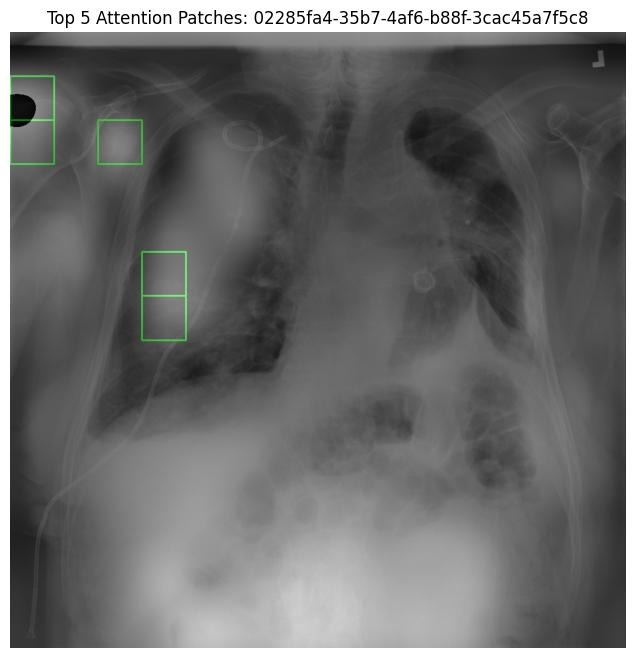

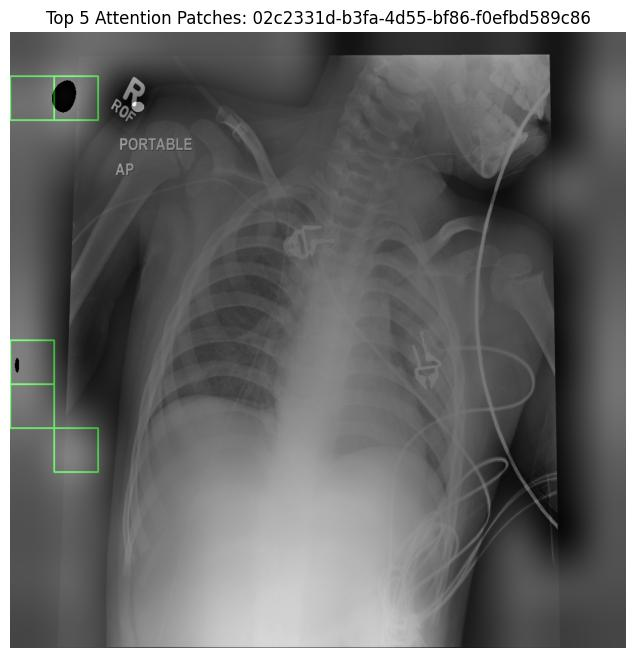

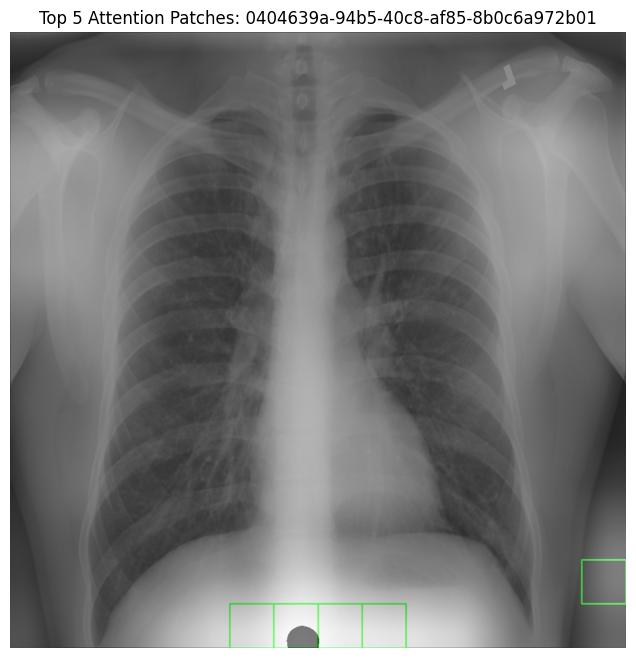

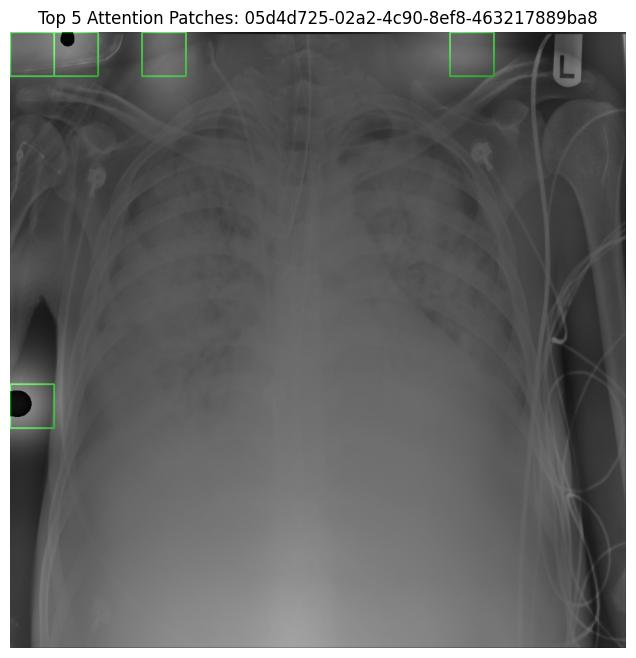

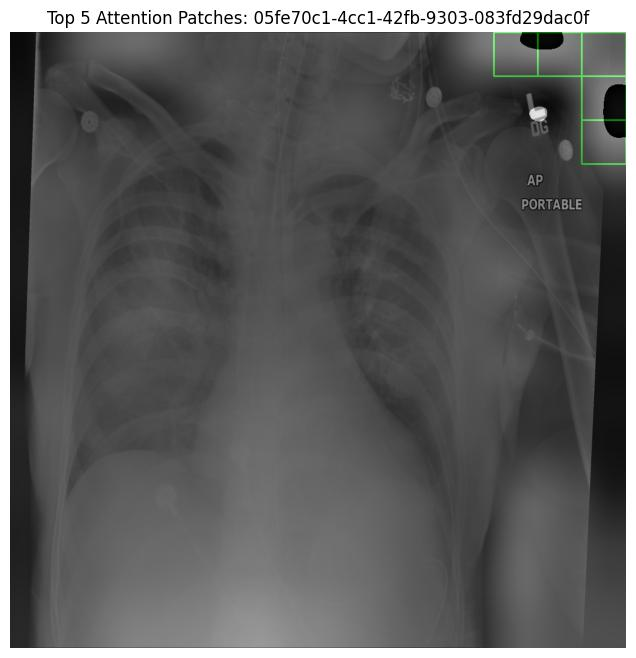

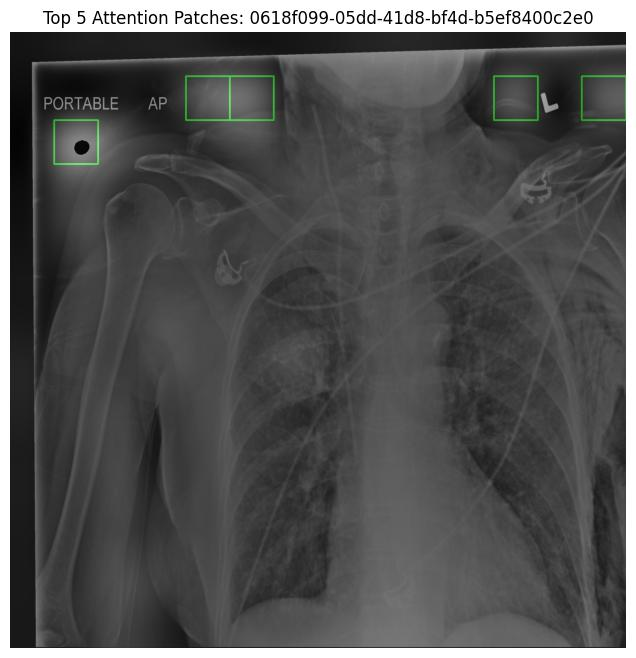

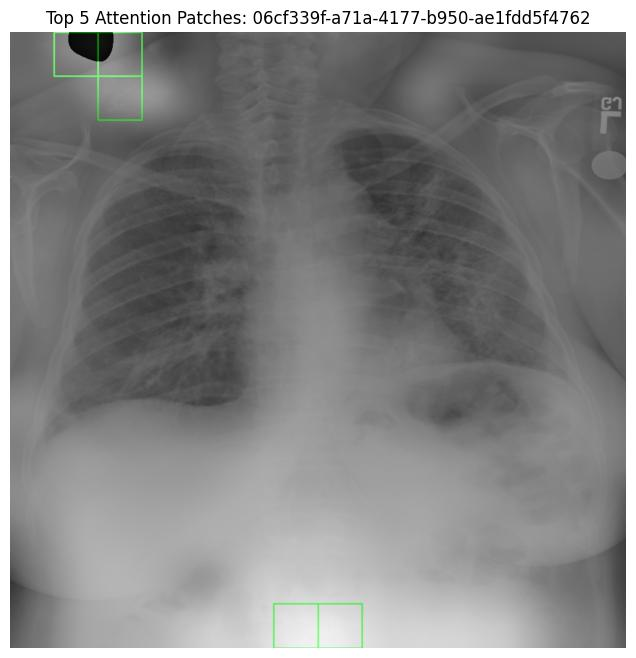

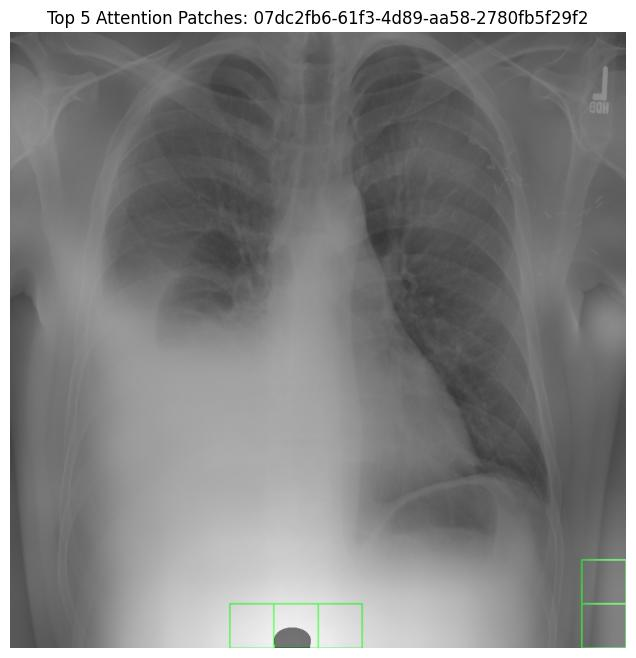

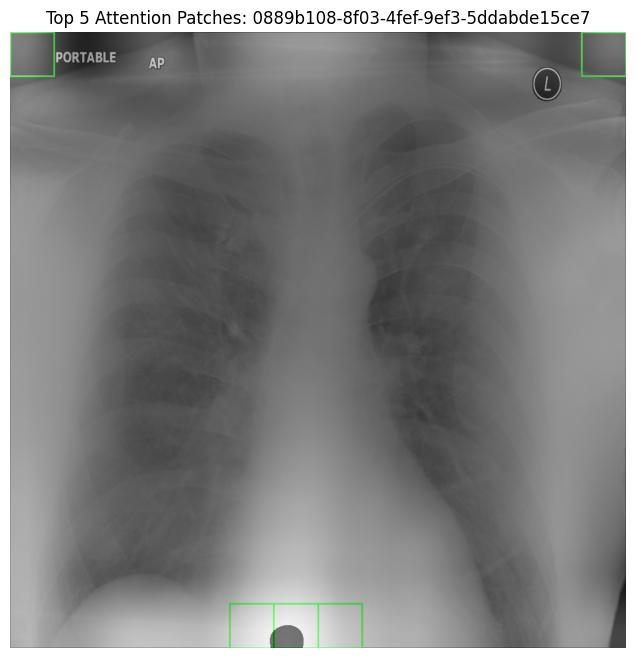

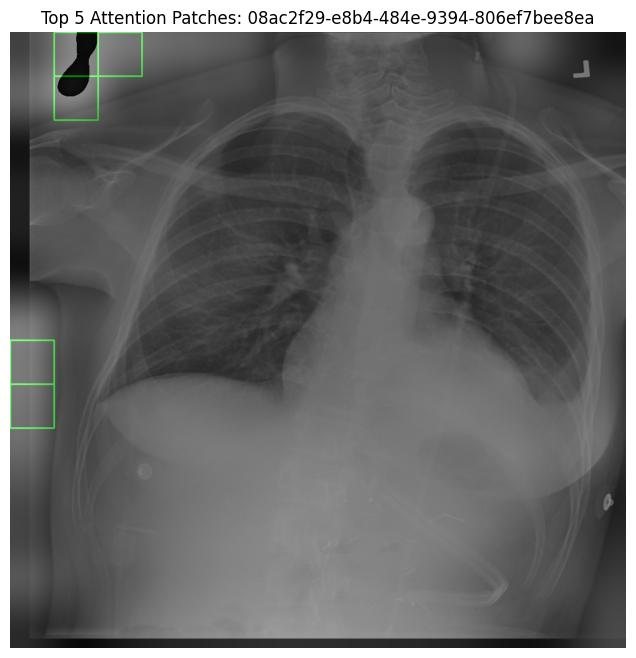

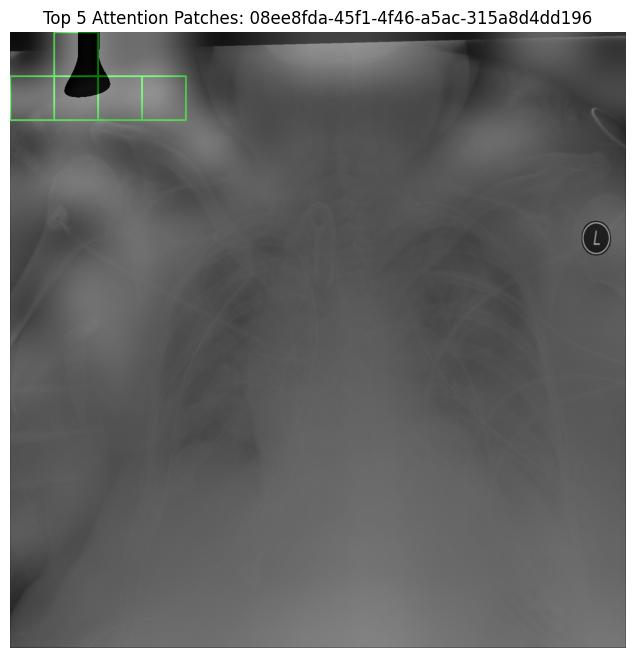

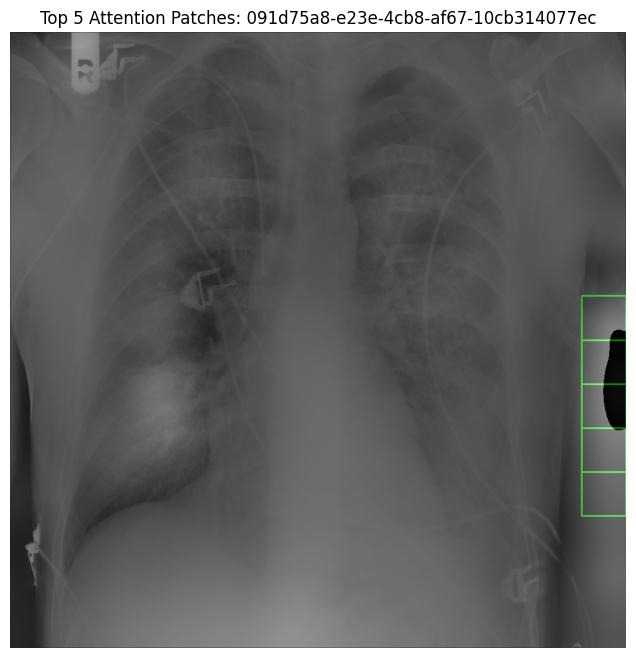

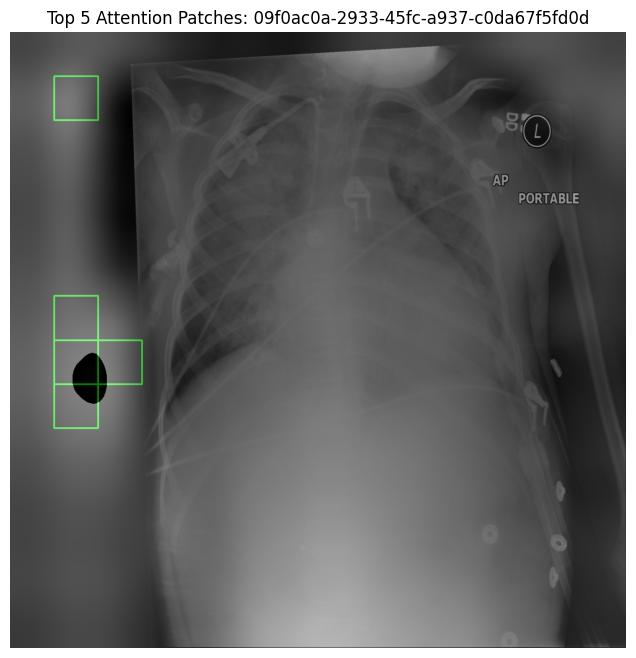

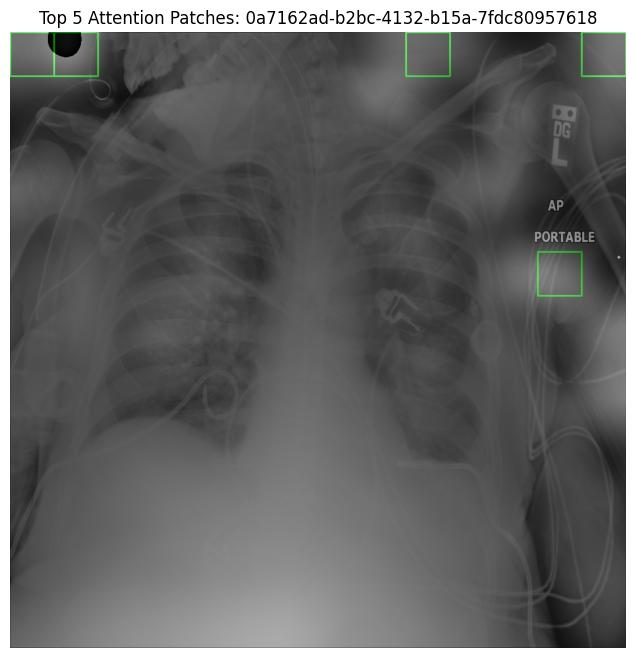

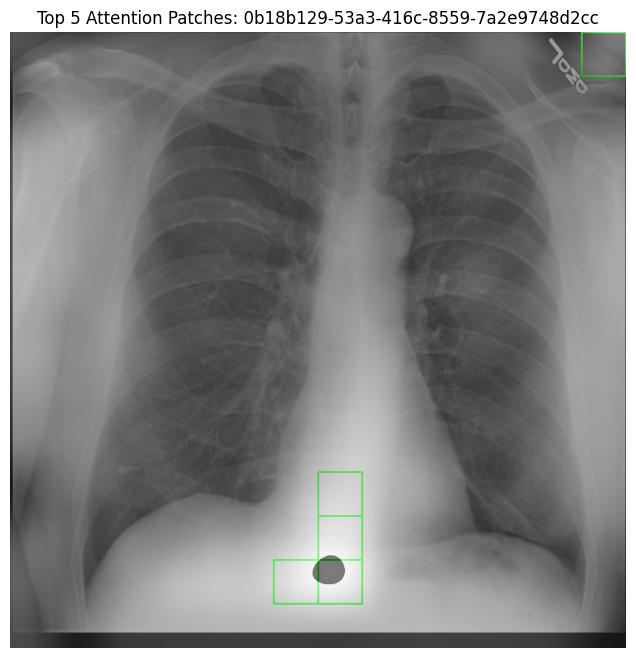

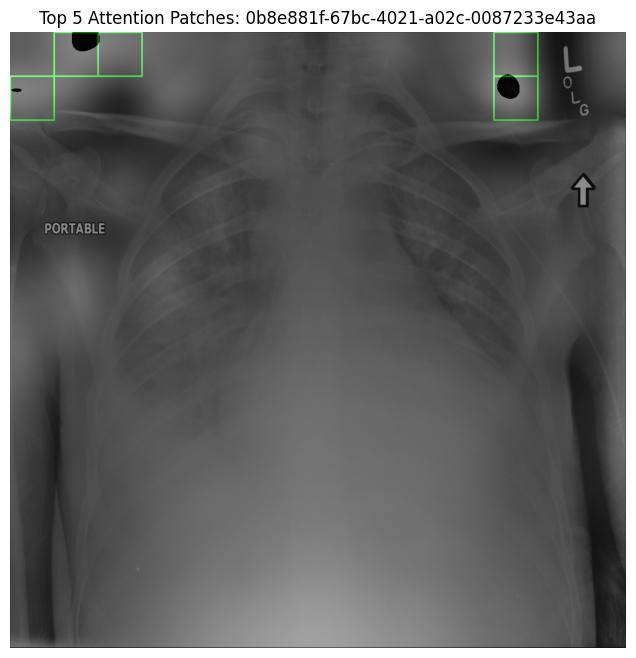

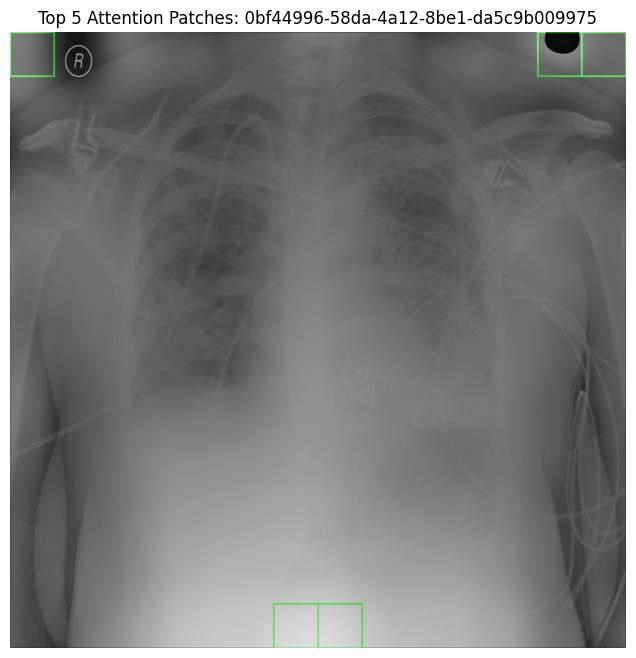

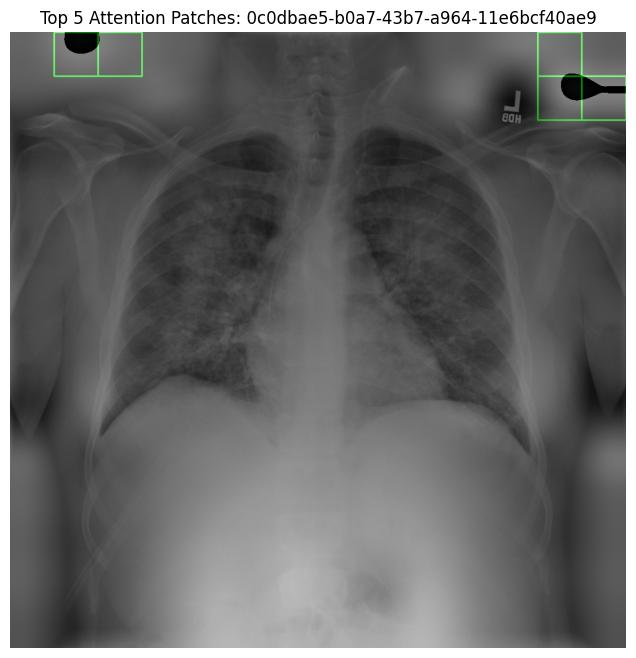

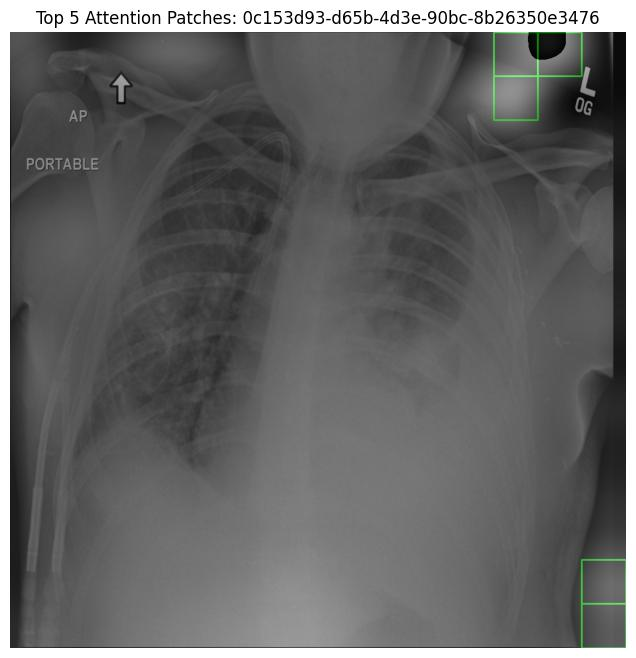

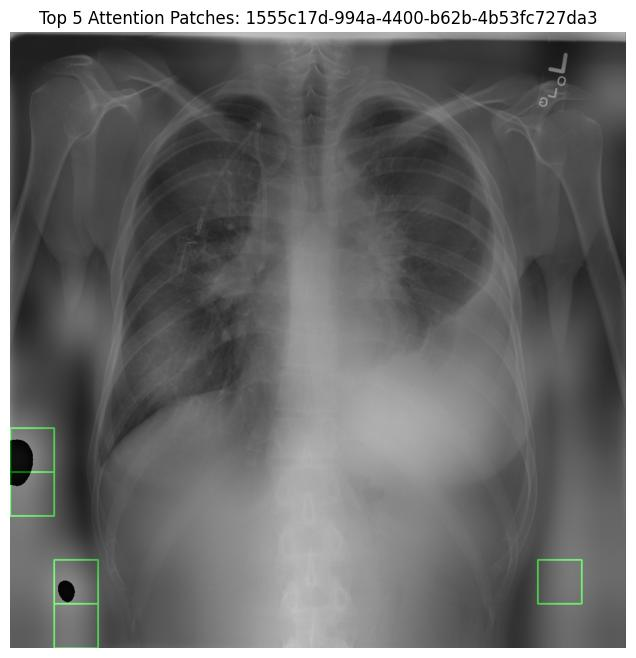

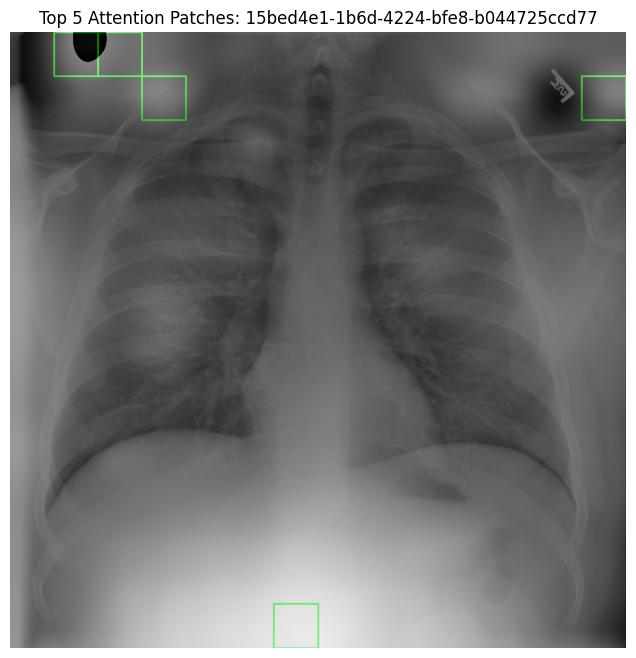

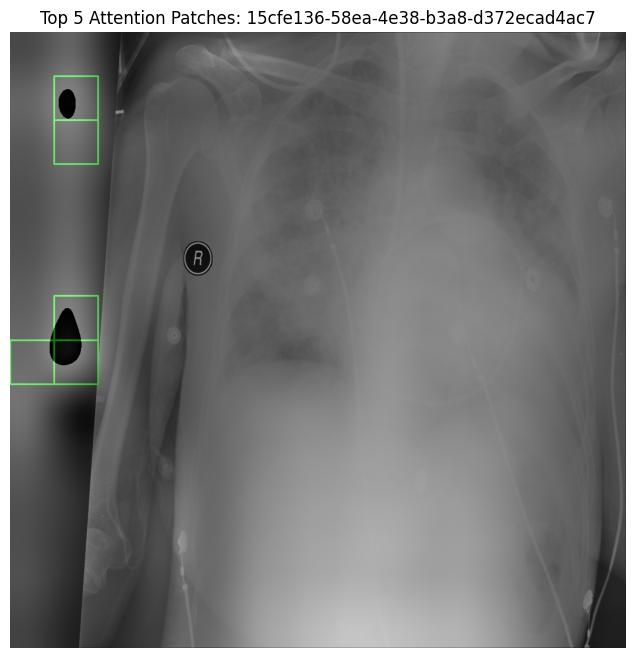

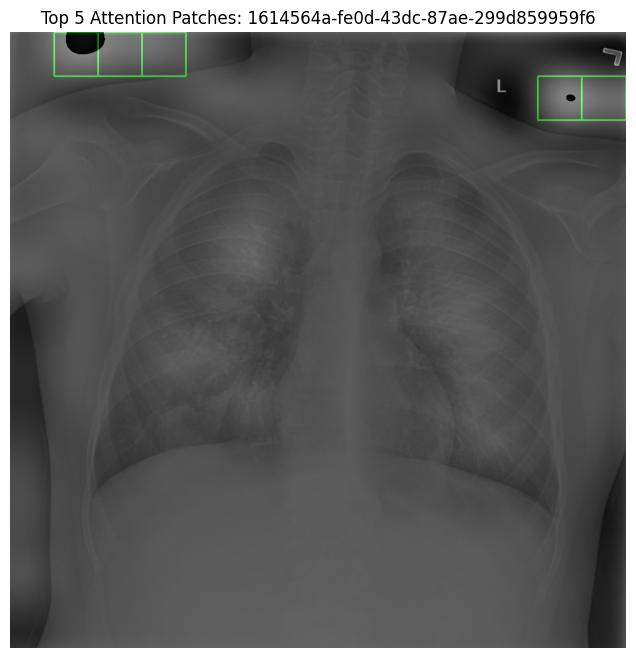

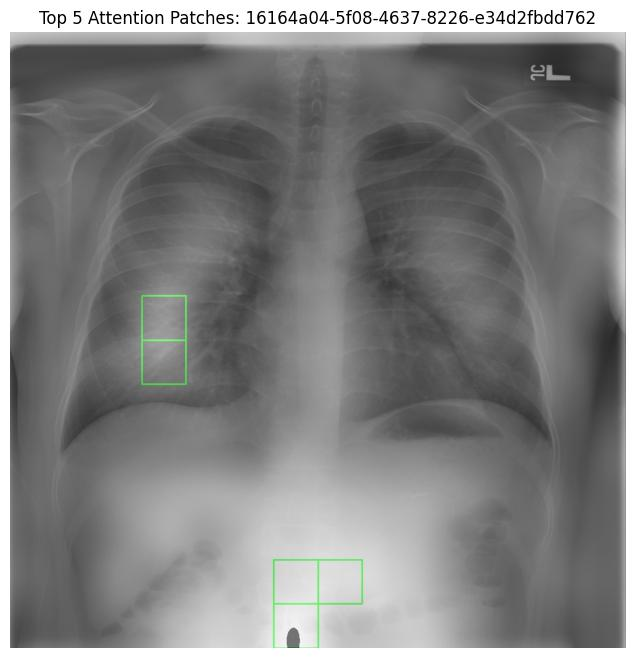

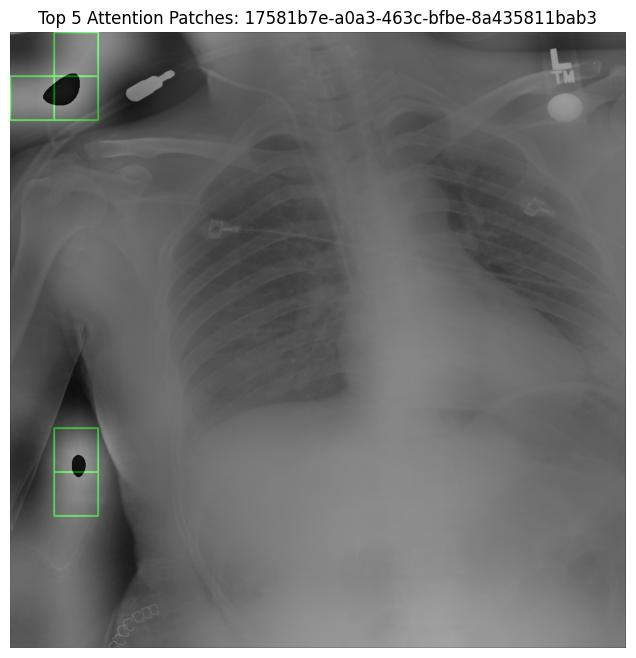

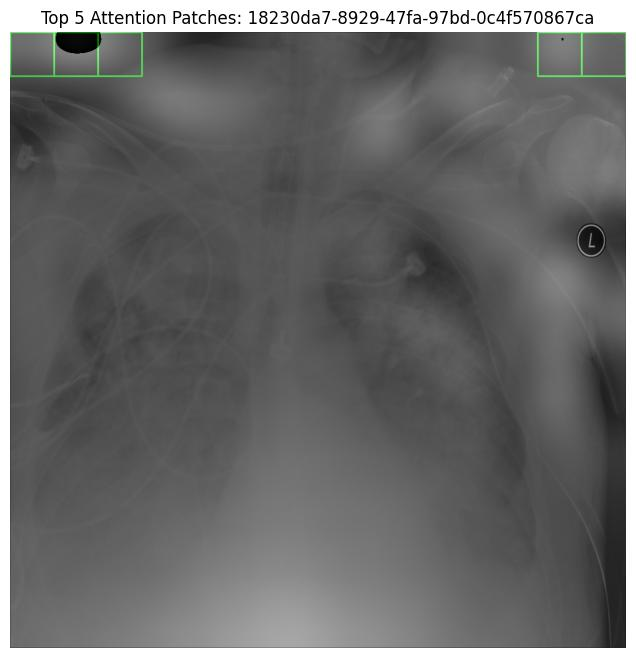

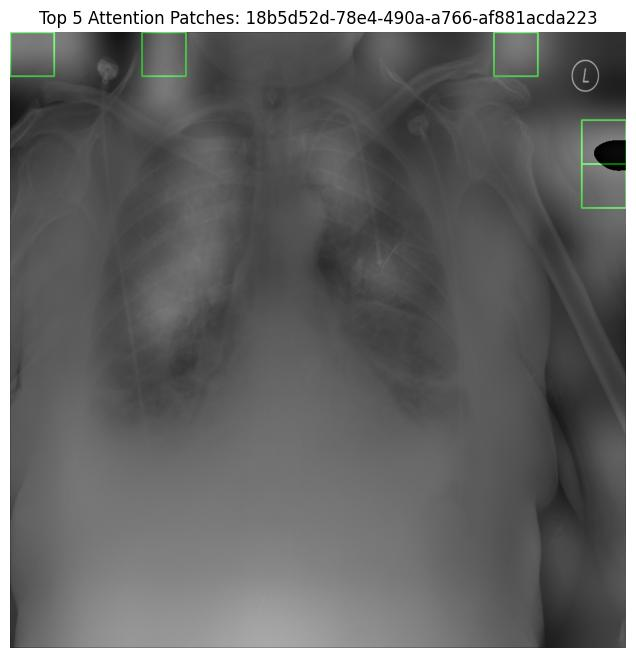

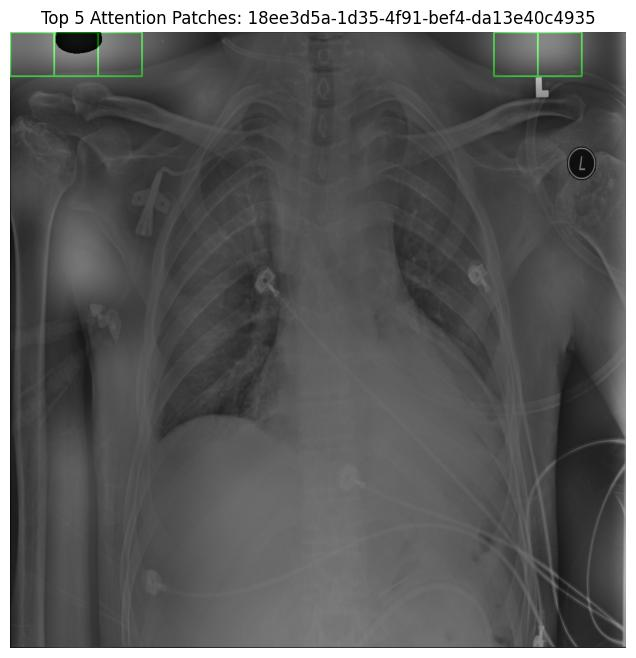

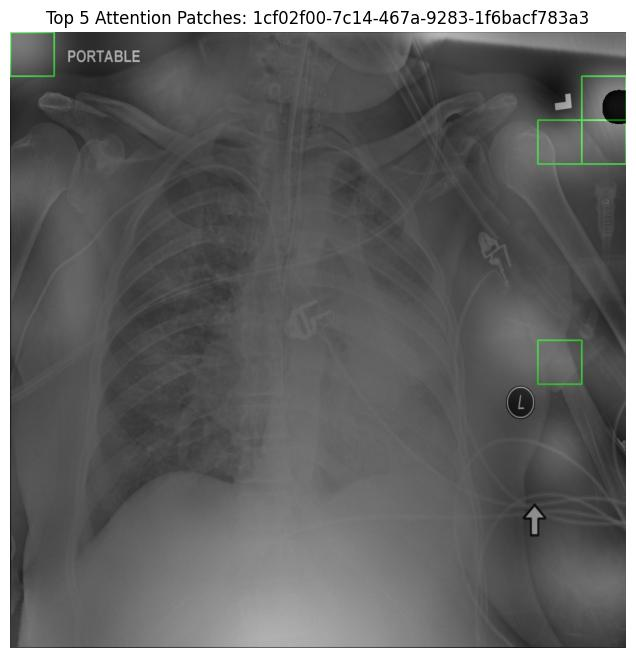

In [ ]:
# =======================
# Visualization: Top Patches + Blurred Attention Overlay
# =======================
rollout = AttentionRollout(model, discard_ratio=0.0, head_fusion="mean")
top_k = 5  # number of top-attended patches to show

for pid in sample_files:
    img_path = os.path.join(IMAGE_DIR, pid + ".png")
    pil_img = Image.open(img_path).convert("RGB")
    img_vis = np.array(pil_img).copy()  # original resolution
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    # --- Get rollout mask ---
    mask = rollout(img_tensor)                     # N x N
    num_patches = mask.shape[1] - 1
    cls_row = mask[0, 1:]                          # CLS to all patches
    cls_row = cls_row / (cls_row.max() + 1e-8)    # normalize

    side = int(math.sqrt(num_patches))
    patch_grid = cls_row.reshape(side, side).detach().cpu().numpy()

    # --- Upsample patch map to image size ---
    mask_img = cv2.resize(patch_grid, (img_vis.shape[1], img_vis.shape[0]), interpolation=cv2.INTER_CUBIC)

    # --- Draw top-attended patches ---
    flat = patch_grid.flatten()
    top_indices = flat.argsort()[-top_k:]  # top-k patches
    for idx in top_indices:
        i, j = divmod(idx, side)
        x0 = int(j * img_vis.shape[1] / side)
        y0 = int(i * img_vis.shape[0] / side)
        x1 = int((j+1) * img_vis.shape[1] / side)
        y1 = int((i+1) * img_vis.shape[0] / side)
        cv2.rectangle(img_vis, (x0, y0), (x1, y1), (0, 255, 0), 2)  # green box

    # --- Blurred overlay for context ---
    mask_blur = cv2.GaussianBlur(mask_img, (21,21), 0)
    overlay = (0.5 * img_vis + 0.5 * np.uint8(255*mask_blur[...,None])).astype(np.uint8)

    # --- Show ---
    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.title(f"Top {top_k} Attention Patches: {pid}")
    plt.axis("off")
    plt.show()


**Observations**: 

Analysis of the top 5 attention patches reveal that they're predominantly located in the image corners, despite IG and Grad-CAM variants having activations in the lung regions. This occurs due to the ViT's patch-based global attention mechanism, which can assign higher attention to the corner patches due to positional biases, initialization artifacts or global context aggregation. Consequently, top-attended patches do not necessarily correspond to the most important features for the model's predicitions. This highlights a key limitation of interpreting raw attention maps in ViTs.

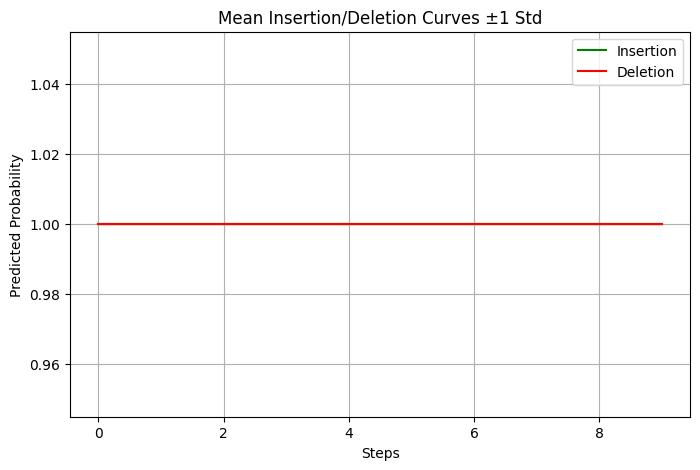

Entropy: 10.7804 ± 0.0214
Sparsity: 0.9500 ± 0.0000
Insertion AUC: 9.0000 ± 0.0000
Deletion AUC: 9.0000 ± 0.0000


In [ ]:
from sklearn.metrics import auc
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# --- Config ---
steps = 10  # number of steps for insertion/deletion curves
percentile_thresh = 95  # top X% considered "important" for sparsity

entropies, sparsities = [], []
all_prob_insertion, all_prob_deletion = [], []
all_insertion_aucs, all_deletion_aucs = [], []

for pid in sample_files:
    img_path = os.path.join(IMAGE_DIR, pid + ".png")
    pil_img = Image.open(img_path).convert("RGB")
    img_tensor = transform(pil_img).unsqueeze(0).to(DEVICE)

    # --- Attention Rollout ---
    mask_img = rollout_to_mask_global(rollout, img_tensor, final_size=IMG_SIZE, blur=True)

    # --- Entropy & Sparsity ---
    flat_norm = mask_img.ravel() / mask_img.sum()
    entropy = -np.sum(flat_norm * np.log(flat_norm + 1e-8))
    threshold_value = np.percentile(mask_img, percentile_thresh)
    sparsity = (mask_img < threshold_value).sum() / mask_img.size
    entropies.append(entropy)
    sparsities.append(sparsity)

    # --- Insertion Curve ---
    baseline = torch.zeros_like(img_tensor)
    prob_insertion = []

    # negative stride fix
    indices = np.argsort(mask_img.ravel())[::-1].copy()  # top-attention first
    step_size = len(indices) // steps

    for i in range(steps):
        start = i*step_size
        end = len(indices) if i == steps-1 else (i+1)*step_size
        idxs = indices[start:end]
        idxs_tensor = torch.tensor(idxs, device=img_tensor.device)

        baseline_flat = baseline.contiguous().view(-1)
        img_flat = img_tensor.contiguous().view(-1)
        baseline_flat[idxs_tensor] = img_flat[idxs_tensor]

        with torch.no_grad():
            pred = model(baseline)
            # use predicted class probability
            pred_class = pred.argmax(dim=1)
            prob = pred.softmax(dim=1)[0, pred_class]
        prob_insertion.append(prob.item())

    all_prob_insertion.append(prob_insertion)
    all_insertion_aucs.append(auc(range(steps), prob_insertion))

    # --- Deletion Curve ---
    img_mod = img_tensor.clone()
    prob_deletion = []

    for i in range(steps):
        start = i*step_size
        end = len(indices) if i == steps-1 else (i+1)*step_size
        idxs = indices[start:end]
        idxs_tensor = torch.tensor(idxs, device=img_tensor.device)

        img_flat = img_mod.contiguous().view(-1)
        img_flat[idxs_tensor] = 0

        with torch.no_grad():
            pred = model(img_mod)
            pred_class = pred.argmax(dim=1)
            prob = pred.softmax(dim=1)[0, pred_class]
        prob_deletion.append(prob.item())

    all_prob_deletion.append(prob_deletion)
    all_deletion_aucs.append(auc(range(steps), prob_deletion))

# --- Convert to numpy arrays ---
all_prob_insertion = np.array(all_prob_insertion)
all_prob_deletion = np.array(all_prob_deletion)

# --- Compute mean and std ---
mean_insertion = all_prob_insertion.mean(axis=0)
std_insertion = all_prob_insertion.std(axis=0)
mean_deletion = all_prob_deletion.mean(axis=0)
std_deletion = all_prob_deletion.std(axis=0)

# --- Plot mean curves with std ---
plt.figure(figsize=(8,5))
x = np.arange(steps)
plt.plot(x, mean_insertion, label="Insertion", color='green')
plt.fill_between(x, mean_insertion - std_insertion, mean_insertion + std_insertion, color='green', alpha=0.2)

plt.plot(x, mean_deletion, label="Deletion", color='red')
plt.fill_between(x, mean_deletion - std_deletion, mean_deletion + std_deletion, color='red', alpha=0.2)

plt.title("Mean Insertion/Deletion Curves ±1 Std")
plt.xlabel("Steps")
plt.ylabel("Predicted Probability")
plt.grid(True)
plt.legend()
plt.show()

# --- Summary ---
print(f"Entropy: {np.mean(entropies):.4f} ± {np.std(entropies):.4f}")
print(f"Sparsity: {np.mean(sparsities):.4f} ± {np.std(sparsities):.4f}")
print(f"Insertion AUC: {np.mean(all_insertion_aucs):.4f} ± {np.std(all_insertion_aucs):.4f}")
print(f"Deletion AUC: {np.mean(all_deletion_aucs):.4f} ± {np.std(all_deletion_aucs):.4f}")


**Observations**:

The extremely high Sparsity of the attention maps indicate that only a small subset of patches contribute strongly to the class token aggregation. The moderate entropy suggests that there's some variation in contribution among these patches. However, the unusual and overlapping Insertion and Deletion AUC values indicate that these high-attention patches, often located in the corners, do not meaningfully influence the model’s predictions. This highlights the key limitation of interpreting raw attention maps as an indicator of causal importance.